In [ ]:
#!/usr/bin/env python3
#############
#############
# PLT FILES #
#############
#############
from pywarpx import picmi
import os

output_directory = 'Physics_Sim_Outputs'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Physical constants
c = picmi.constants.c
q_e = picmi.constants.q_e

# Number of time steps
max_steps = 270

# Number of cells
nx = 32
ny = 32
nz = 256

# Physical domain
xmin = -30e-06
xmax =  30e-06
ymin = -30e-06
ymax =  30e-06
zmin = -56e-06
zmax =  12e-06

# Domain decomposition
max_grid_size = 64
blocking_factor = 32

# Create grid
grid = picmi.Cartesian3DGrid(
    number_of_cells = [nx, ny, nz],
    lower_bound = [xmin, ymin, zmin],
    upper_bound = [xmax, ymax, zmax],
    lower_boundary_conditions = ['periodic', 'periodic', 'dirichlet'],
    upper_boundary_conditions = ['periodic', 'periodic', 'dirichlet'],
    lower_boundary_conditions_particles = ['periodic', 'periodic', 'absorbing'],
    upper_boundary_conditions_particles = ['periodic', 'periodic', 'absorbing'],
    moving_window_velocity = [0., 0., c],
    warpx_max_grid_size = max_grid_size,
    warpx_blocking_factor = blocking_factor)

# Particles: plasma electrons
plasma_density = 2e23
plasma_xmin = -20e-06
plasma_ymin = -20e-06
plasma_zmin = 0
plasma_xmax = 20e-06
plasma_ymax = 20e-06
plasma_zmax = None
uniform_distribution = picmi.UniformDistribution(
    density = plasma_density,
    lower_bound = [plasma_xmin, plasma_ymin, plasma_zmin],
    upper_bound = [plasma_xmax, plasma_ymax, plasma_zmax],
    fill_in = True)
electrons = picmi.Species(
    particle_type = 'electron',
    name = 'electrons',
    initial_distribution = uniform_distribution,
    warpx_add_int_attributes = {'regionofinterest': "(z>12.0e-6) * (z<13.0e-6)"},
    warpx_add_real_attributes = {'initialenergy': "ux*ux + uy*uy + uz*uz"})

# Particles: beam electrons
q_tot = 1e-12
x_m = 0.
y_m = 0.
z_m = -28e-06
x_rms = 0.5e-06
y_rms = 0.5e-06
z_rms = 0.5e-06
ux_m = 0.
uy_m = 0.
uz_m = 500.
ux_th = 2.
uy_th = 2.
uz_th = 50.
gaussian_bunch_distribution = picmi.GaussianBunchDistribution(
    n_physical_particles = q_tot / q_e,
    rms_bunch_size = [x_rms, y_rms, z_rms],
    rms_velocity = [c*ux_th, c*uy_th, c*uz_th],
    centroid_position = [x_m, y_m, z_m],
    centroid_velocity = [c*ux_m, c*uy_m, c*uz_m])
beam = picmi.Species(
    particle_type = 'electron',
    name = 'beam',
    initial_distribution = gaussian_bunch_distribution)

# Laser
e_max = 16e12
position_z = 9e-06
profile_t_peak = 30.e-15
profile_focal_distance = 100e-06
laser = picmi.GaussianLaser(
    wavelength = 0.8e-06,
    waist = 5e-06,
    duration = 15e-15,
    focal_position = [0, 0, profile_focal_distance + position_z],
    centroid_position = [0, 0, position_z - c*profile_t_peak],
    propagation_direction = [0, 0, 1],
    polarization_direction = [0, 1, 0],
    E0 = e_max,
    fill_in = False)
laser_antenna = picmi.LaserAntenna(
    position = [0., 0., position_z],
    normal_vector = [0, 0, 1])

# Electromagnetic solver
solver = picmi.ElectromagneticSolver(
    grid = grid,
    method = 'Yee',
    cfl = 1.,
    divE_cleaning = 0)

# Diagnostics
diag_field_list = ['B', 'E', 'J', 'rho']
particle_diag = picmi.ParticleDiagnostic(
    name = 'diag1',
    period = 1,
    write_dir = output_directory,
    warpx_file_prefix = 'Python_LaserAcceleration_plt')
field_diag = picmi.FieldDiagnostic(
    name = 'diag1',
    grid = grid,
    period = 1,
    data_list = diag_field_list,
    write_dir = output_directory,
    warpx_file_prefix = 'Python_LaserAcceleration_plt')

# Set up simulation
sim = picmi.Simulation(
    solver = solver,
    max_steps = max_steps,
    verbose = 1,
    particle_shape = 'cubic',
    warpx_use_filter = 1,
    warpx_serialize_initial_conditions = 1,
    warpx_do_dynamic_scheduling = 0)

# Add plasma electrons
sim.add_species(
    electrons,
    layout = picmi.GriddedLayout(grid = grid, n_macroparticle_per_cell = [1, 1, 1]))

# Add beam electrons
sim.add_species(
    beam,
    layout = picmi.PseudoRandomLayout(grid = grid, n_macroparticles = 100))

# Add laser
sim.add_laser(
    laser,
    injection_method = laser_antenna)

# Add diagnostics
sim.add_diagnostic(particle_diag)
sim.add_diagnostic(field_diag)

# Write input file that can be used to run with the compiled version
sim.write_input_file(file_name = 'inputs_3d_picmi')

# Initialize inputs and WarpX instance
sim.initialize_inputs()
sim.initialize_warpx()

# Advance simulation until last time step
sim.step(max_steps)

In [ ]:
#!/usr/bin/env python3
#############
#############
# PMD FILES #
#############
#############
from pywarpx import picmi
from openpmd_viewer import OpenPMDTimeSeries
import os

output_directory = 'Physics_Sim_Outputs_PMD'

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Physical constants
c = picmi.constants.c
q_e = picmi.constants.q_e

# Number of time steps
max_steps = 270

# Number of cells
nx = 32
ny = 32
nz = 256

# Physical domain
xmin = -30e-06
xmax =  30e-06
ymin = -30e-06
ymax =  30e-06
zmin = -56e-06
zmax =  12e-06

# Domain decomposition
max_grid_size = 64
blocking_factor = 32

# Create grid
grid = picmi.Cartesian3DGrid(
    number_of_cells = [nx, ny, nz],
    lower_bound = [xmin, ymin, zmin],
    upper_bound = [xmax, ymax, zmax],
    lower_boundary_conditions = ['periodic', 'periodic', 'dirichlet'],
    upper_boundary_conditions = ['periodic', 'periodic', 'dirichlet'],
    lower_boundary_conditions_particles = ['periodic', 'periodic', 'absorbing'],
    upper_boundary_conditions_particles = ['periodic', 'periodic', 'absorbing'],
    moving_window_velocity = [0., 0., c],
    warpx_max_grid_size = max_grid_size,
    warpx_blocking_factor = blocking_factor)

# Particles: plasma electrons
plasma_density = 2e23
plasma_xmin = -20e-06
plasma_ymin = -20e-06
plasma_zmin = 0
plasma_xmax = 20e-06
plasma_ymax = 20e-06
plasma_zmax = None
uniform_distribution = picmi.UniformDistribution(
    density = plasma_density,
    lower_bound = [plasma_xmin, plasma_ymin, plasma_zmin],
    upper_bound = [plasma_xmax, plasma_ymax, plasma_zmax],
    fill_in = True)
electrons = picmi.Species(
    particle_type = 'electron',
    name = 'electrons',
    initial_distribution = uniform_distribution,
    warpx_add_int_attributes = {'regionofinterest': "(z>12.0e-6) * (z<13.0e-6)"},
    warpx_add_real_attributes = {'initialenergy': "ux*ux + uy*uy + uz*uz"})

# Particles: beam electrons. Are the fields not resolved because the bunch is not resolved? Are the bunch parameters set correctly?
q_tot = 1e-12
x_m = 0.
y_m = 0.
z_m = -28e-06
x_rms = 0.5e-06
y_rms = 0.5e-06
z_rms = 0.5e-06
ux_m = 0.
uy_m = 0.
uz_m = 500.
ux_th = 2.
uy_th = 2.
uz_th = 50.
gaussian_bunch_distribution = picmi.GaussianBunchDistribution(
    n_physical_particles = q_tot / q_e,
    rms_bunch_size = [x_rms, y_rms, z_rms],
    rms_velocity = [c*ux_th, c*uy_th, c*uz_th],
    centroid_position = [x_m, y_m, z_m],
    centroid_velocity = [c*ux_m, c*uy_m, c*uz_m])
beam = picmi.Species(
    particle_type = 'electron',
    name = 'beam',
    initial_distribution = gaussian_bunch_distribution)

# Laser
e_max = 16e12
position_z = 9e-06
profile_t_peak = 30.e-15
profile_focal_distance = 100e-06
laser = picmi.GaussianLaser(
    wavelength = 0.8e-06,
    waist = 5e-06,
    duration = 15e-15,
    focal_position = [0, 0, profile_focal_distance + position_z],
    centroid_position = [0, 0, position_z - c*profile_t_peak],
    propagation_direction = [0, 0, 1],
    polarization_direction = [0, 1, 0],
    E0 = e_max,
    fill_in = False)
laser_antenna = picmi.LaserAntenna(
    position = [0., 0., position_z],
    normal_vector = [0, 0, 1])

# Electromagnetic solver
solver = picmi.ElectromagneticSolver(
    grid = grid,
    method = 'Yee',
    cfl = 1.,
    divE_cleaning = 0)

# Diagnostics
diag_field_list = ['B', 'E', 'J', 'rho']
particle_diag = picmi.ParticleDiagnostic(
    name = 'diag1',
    period = 1,
    write_dir = output_directory,
    # warpx_file_prefix = 'Python_LaserAcceleration_plt'
    )
field_diag = picmi.FieldDiagnostic(
    name = 'diag1',
    grid = grid,
    period = 1,
    data_list = diag_field_list,
    write_dir = output_directory,
    # warpx_file_prefix = 'Python_LaserAcceleration_plt'
    )

# Set up simulation
sim = picmi.Simulation(
    solver = solver,
    max_steps = max_steps,
    verbose = 1,
    particle_shape = 'cubic',
    warpx_use_filter = 1,
    warpx_serialize_initial_conditions = 1,
    warpx_do_dynamic_scheduling = 0)

# Change the format of the output data to fit openPMD parsing functions
particle_diag.format = 'openpmd'
field_diag.format = 'openpmd'

# Add plasma electrons
sim.add_species(
    electrons,
    layout = picmi.GriddedLayout(grid = grid, n_macroparticle_per_cell = [1, 1, 1]))

# Add beam electrons
sim.add_species(
    beam,
    layout = picmi.PseudoRandomLayout(grid = grid, n_macroparticles = 100))

# Add laser
sim.add_laser(
    laser,
    injection_method = laser_antenna)

# Add diagnostics
sim.add_diagnostic(particle_diag)
sim.add_diagnostic(field_diag)

# Write input file that can be used to run with the compiled version
sim.write_input_file(file_name = 'inputs_3d_picmi')

# Initialize inputs and WarpX instance
sim.initialize_inputs()
sim.initialize_warpx()

# Advance simulation until last time step
sim.step(max_steps)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio.v2 as imageio
import os
import yt
import time

# 2D SIMULATION DEMO
# TODO: Make the output color bar not all jittery

yt.funcs.mylog.setLevel(50)  # suppress yt information unless its an error message.

# fig, ax = plt.subplots()

num_frames = 237  # give number of frames you want to render in gif
file_index = 0  # stores position in file list later

file_names = []  # List to store filenames for deletion
frames = []  # stores all the names of the generated frames

for i in range(num_frames):  # Keep looping for all frames desired in animation
    file_names.append(f"Physics_Sim_Outputs/Python_LaserAcceleration_plt{format(i, '06')}")  # Grab all respective output files that coorespond to number of frames & add them to file_names list


for file_index in range(len(file_names)):  # move through the file_names list
    start_time = time.time()
    fig = plt.figure(figsize=(10, 8))
    
    fn = file_names[file_index]  # give file name to variable 'fn' stands for 'file name'

    # Read the file
    ds = yt.load(fn)  # load the above file into variable ds

    # plot the laser field and absolute density
    fields = ["Ex", "Jx"]  # a list of fields representing physical quantities. Here it is electric field and density
    normal = "x"  # this is the axis that is perpendicular to the 2D plane
    slyce = yt.SlicePlot(ds, normal=normal, fields=fields)  # make this thing 2D
    for field in fields:  # go through the list of physical quantities
        slyce.set_log(field, False)  # don't do any logarithmic scaling
    
    # slyce.show()
    
    slyce._setup_plots()
    
    slyce.set_figure_size((4, 8))  # sets the dimensions of the figure height of 4in width of 8in
    fig = slyce.export_to_mpl_figure(nrows_ncols=(2, 1))  # converts sl SlicePlot object into a matplotlib figure. A matplotlib fig is like a canvas to display stuff on
    
    fig.suptitle("Frame - " + str(file_index + 1), fontsize=15)
    
    total_time = time.time() - start_time

    print(f"FILE #{file_index + 1} LOADED. {((file_index+1)/len(file_names))*100:.3g}% DONE. LOAD TIME: {total_time:.4g} seconds")  # output the progress of the outputs
    
    # Save each plot as a PNG file
    frame = f'Generated_PNGs/2D_plasma_{file_index}.png'  # name each frame of the gif
    plt.savefig(frame)  # save the slice/figure and assign the name of the frame
    plt.close(fig)  # Close the figure to release resources
    frames.append(frame)  # add the frame to the list of frames
    # plt.show()
    
print("Frame gathering complete!")  # Output when all frames are done rendering


# Generate the GIF from the saved PNG files
numpy_frames = []
gif_filename = '2D_Plasma_Simulation.gif'  # name of the output gif
with imageio.get_writer(gif_filename, mode='I') as writer:
    for frame in frames:  # for each frame in the list of frames...
        image = imageio.imread(frame)  # read each frame/convert to visible image
        writer.append_data(image)  # add to the writer list which will create a gif
        numpy_frames.append(image)

imageio.mimsave(gif_filename, numpy_frames, format='GIF', duration=0.5)  # save the gif with a frame duration of x amount of seconds per frame

print(f'GIF saved as {gif_filename}')  # state that the gif has downloaded

# Remove the image files after creating the GIF
for frame in frames:  # go through list of frames
    os.remove(frame)  # remove all images created that have the corresponding 'frame' name

print(f'Removed {len(frames)} temporary PNG files.')  # state how many of the files were removed 

FILE #1 LOADED. 0.422% DONE. LOAD TIME: 2.734 seconds
FILE #2 LOADED. 0.844% DONE. LOAD TIME: 2.562 seconds
FILE #3 LOADED. 1.27% DONE. LOAD TIME: 2.687 seconds
FILE #4 LOADED. 1.69% DONE. LOAD TIME: 1.963 seconds
FILE #5 LOADED. 2.11% DONE. LOAD TIME: 2.702 seconds
FILE #6 LOADED. 2.53% DONE. LOAD TIME: 3.158 seconds
FILE #7 LOADED. 2.95% DONE. LOAD TIME: 10.95 seconds
FILE #8 LOADED. 3.38% DONE. LOAD TIME: 2.735 seconds
FILE #9 LOADED. 3.8% DONE. LOAD TIME: 3.081 seconds
FILE #10 LOADED. 4.22% DONE. LOAD TIME: 2.723 seconds
FILE #11 LOADED. 4.64% DONE. LOAD TIME: 2.903 seconds
FILE #12 LOADED. 5.06% DONE. LOAD TIME: 2.952 seconds
FILE #13 LOADED. 5.49% DONE. LOAD TIME: 3.144 seconds
FILE #14 LOADED. 5.91% DONE. LOAD TIME: 2.97 seconds
FILE #15 LOADED. 6.33% DONE. LOAD TIME: 2.119 seconds
FILE #16 LOADED. 6.75% DONE. LOAD TIME: 2.524 seconds
FILE #17 LOADED. 7.17% DONE. LOAD TIME: 2.551 seconds
FILE #18 LOADED. 7.59% DONE. LOAD TIME: 2.545 seconds
FILE #19 LOADED. 8.02% DONE. LOAD TIM

/tmp/ipykernel_444805/691067141.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 8))


FILE #21 LOADED. 8.86% DONE. LOAD TIME: 2.599 seconds
FILE #22 LOADED. 9.28% DONE. LOAD TIME: 3.577 seconds
FILE #23 LOADED. 9.7% DONE. LOAD TIME: 3.978 seconds
FILE #24 LOADED. 10.1% DONE. LOAD TIME: 2.564 seconds
FILE #25 LOADED. 10.5% DONE. LOAD TIME: 2.614 seconds
FILE #26 LOADED. 11% DONE. LOAD TIME: 3.032 seconds
FILE #27 LOADED. 11.4% DONE. LOAD TIME: 3.55 seconds
FILE #28 LOADED. 11.8% DONE. LOAD TIME: 1.821 seconds
FILE #29 LOADED. 12.2% DONE. LOAD TIME: 2.711 seconds
FILE #30 LOADED. 12.7% DONE. LOAD TIME: 2.422 seconds
FILE #31 LOADED. 13.1% DONE. LOAD TIME: 3.137 seconds
FILE #32 LOADED. 13.5% DONE. LOAD TIME: 2.538 seconds
FILE #33 LOADED. 13.9% DONE. LOAD TIME: 2.267 seconds
FILE #34 LOADED. 14.3% DONE. LOAD TIME: 3.642 seconds
FILE #35 LOADED. 14.8% DONE. LOAD TIME: 3.128 seconds
FILE #36 LOADED. 15.2% DONE. LOAD TIME: 2.823 seconds
FILE #37 LOADED. 15.6% DONE. LOAD TIME: 2.257 seconds
FILE #38 LOADED. 16% DONE. LOAD TIME: 2.26 seconds
FILE #39 LOADED. 16.5% DONE. LOAD T

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [65]:
import numpy as np
import imageio
import os
import yt
from yt.visualization.volume_rendering.api import Scene, create_volume_source
import time

# 3D SIMULATION DEMO

yt.funcs.mylog.setLevel(50)  # suppress yt information unless its an error message.

num_frames = 5  # give number of frames you want to render in gif
file_index = 0  # stores position in file list later

file_names = []  # List to store filenames for deletion
frames = []  # stores all the names of the generated frames

yt.enable_parallelism()

for i in range(num_frames):  # Keep looping for all frames desired in animation
    file_names.append(f"Physics_Sim_Outputs/Python_LaserAcceleration_plt{format(i, '06')}")  # Grab all respective output files that coorespond to number of frames & add them to file_names list
    
for file_index in range(len(file_names)):  # move through the file_names list
    # ax = plt.axes(projection='3d')
    start_time = time.time()

    fn = file_names[file_index]  # give file name to variable 'fn' stands for 'file name'

    # Read the file
    ds = yt.load(fn)  # load the above file into variable ds
    ad = ds.all_data()
    
    ds.force_periodicity()
    
    # Take data from input file (Ex, Ey, Ex, Jx, Jy, Jz, x, y, z)
    
    # Plasma
    body_x = ad['nbody', 'particle_position_x'].v
    body_y = ad['nbody', 'particle_position_y'].v
    body_z = ad['nbody', 'particle_position_z'].v
    
    # Beam
    beam_x = ad['beam', 'particle_position_x'].v
    beam_y = ad['beam', 'particle_position_y'].v
    beam_z = ad['beam', 'particle_position_z'].v
    
    # Electric field
    ex = ad['boxlib', 'Ex'].v
    ey = ad['boxlib', 'Ey'].v
    ez = ad['boxlib', 'Ez'].v
    
    # Current density 
    jx = ad['boxlib', 'jx'].v
    jy = ad['boxlib', 'jy'].v
    jz = ad['boxlib', 'jz'].v

    # Absolute density?
    rho = ad['boxlib', 'rho']
    
    scene = yt.create_scene(ds, 'rho', lens_type="perspective")  # auto defaulted to gas, density, lens options are ‘plane-parallel’, ‘perspective’, and ‘fisheye’
    
    # display particles on screen
    vertices_particles = np.column_stack((body_x, body_y, body_z))
    color_choice1 = [1., 0., 0., 1.]
    colors_particles = np.tile(color_choice1, (vertices_particles.shape[0], 1))
    point_source_particles = yt.visualization.volume_rendering.render_source.PointSource(vertices_particles, colors=colors_particles, radii=5)
    scene.add_source(point_source_particles)
    
    # display electric field on screen
    vertices_electric_field = np.column_stack((ex, ey, ez))  # takes the electric field data and puts it into a 2D array
    color_choice2 = [1., 1., 0., 1.]  # yellow
    colors_electric_field = np.tile(color_choice2, (vertices_electric_field.shape[0], 1))  # Set color for electric field
    point_source_electric_field = yt.visualization.volume_rendering.render_source.PointSource(vertices_electric_field, colors=colors_electric_field, radii=2)  # create point source
    point_source_electric_field = yt.apply_colormap((vertices_electric_field))
    scene.add_source(point_source_electric_field)


    # # Example creation of vertices_electric_field
    # nlines = 10
    # vertices_electric_field = np.random.rand(nlines, 2, 3)  # 10 lines, each with 2 points (start and end), each point has 3 coordinates

    # # Example creation of colors3
    # colors3 = np.random.random([nlines, 4])
    # colors3[:, 3] = 0.1
    # point_source_electric_field = yt.visualization.volume_rendering.render_source.LineSource(vertices_electric_field, colors=colors3)  # create line source
    # colors = yt.apply_colormap(np.log10(surface[("boxlib", "rho")]), cmap_name="hot")
    # scene.add_source(point_source_electric_field)  # set point source in 3D
    
    # display current density on screen
    vertices_current_density = np.column_stack((jx, jy, jz))
    color_choice3 = [0., 1., 0., 1.]  # red
    colors_current_density = np.tile(color_choice3, (vertices_current_density.shape[0], 1))
    point_source_current_density = yt.visualization.volume_rendering.render_source.PointSource(vertices_current_density, colors=colors_current_density, radii=2)
    scene.add_source(point_source_current_density)
    
    # display beam on screen
    vertices_beam = np.column_stack((beam_x, beam_y, beam_z))
    color_choice4 = [0, 0., 1., 1.]  # blue
    colors_beam = np.tile(color_choice4, (vertices_beam.shape[0], 1))
    point_source_beam = yt.visualization.volume_rendering.render_source.PointSource(vertices_beam, colors=colors_beam, radii=2)
    scene.add_source(point_source_beam)
    
    # Get a reference to the VolumeSource associated with this scene
    # It is the first source associated with the scene, so we can refer to it
    # using index 0.
    source = scene[0]

    camera = scene.camera
    camera.focus = ds.domain_center
    camera.resolution = 1024
    camera.north_vector = [0, 0, 1]
    camera.position = [1, 1, 1]
    
    source.set_field(("boxlib", "Ey"))
    source.set_log(True)

    bounds = (np.min(ey), np.max(ey))  # Adjust bounds based on the range of Ey values

    # Since this rendering is done in log space, the transfer function needs
    # to be specified in log space.
    tf = yt.ColorTransferFunction(np.log10(bounds))

    tf.add_layers(5, colormap="cmyt.arbre")

    source.tfh.tf = tf
    source.tfh.bounds = bounds

    # Plot the transfer function, along with the CDF of the density field to
    # see how the transfer function corresponds to structure in the CDF
    source.tfh.plot(f"transfer_function_{file_index}.png", profile_field=('boxlib', 'Ey'))
    
    # You may need to adjust the alpha values to get an image with good contrast.
    # For the annotate_domain call, the fourth value in the color tuple is the
    # alpha value.
    scene.annotate_domain(ds, color=[1, 1, 1, 1])  # changes color of domain of the dataset??
    
    scene.render()
    
    frame = f'Generated_PNGs/3D_plasma_{file_index}.png'
    
    # save the image, flooring especially bright pixels for better contrast
    scene.save(frame, sigma_clip=1.)
    
    # Save each plot as a PNG file
    frames.append(frame)  # add the frame to the list of frames
    
    total_time = time.time() - start_time

    print(f"FILE #{file_index + 1} LOADED. {((file_index+1)/len(file_names))*100:.3g}% DONE. LOAD TIME: {total_time:.4g} seconds")  # output the progress of the outputs

    
print("Frame gathering complete!")  # Output when all frames are done rendering

# Generate the GIF from the saved PNG files
numpy_frames = []
gif_filename = '3D_Plasma_Simulation.gif'  # name of the output gif
with imageio.get_writer(gif_filename, mode='I') as writer:
    for frame in frames:  # for each frame in the list of frames...
        image = imageio.imread(frame)  # read each frame/convert to visible image
        writer.append_data(image)  # add to the writer list which will create a gif
        numpy_frames.append(image)

imageio.mimsave(gif_filename, numpy_frames, format='GIF', duration=0.5)  # save the gif with a frame duration of x amount of seconds per frame
        
print(f'GIF saved as {gif_filename}')  # state that the gif has downloaded

# Remove the image files after creating the GIF
for frame in frames:  # go through list of frames
    os.remove(frame)  # remove all images created that have the corresponding 'frame' name

print(f'Removed {len(frames)} temporary PNG files.')  # state how many of the files were removed 

/tmp/ipykernel_1998105/2833190881.py:121: RuntimeWarning: divide by zero encountered in log10
  tf = yt.ColorTransferFunction(np.log10(bounds))
/global/homes/g/ginella/.conda/envs/warpx/lib/python3.12/site-packages/numpy/core/function_base.py:139: RuntimeWarning: invalid value encountered in scalar subtract
  delta = stop - start
/global/homes/g/ginella/.conda/envs/warpx/lib/python3.12/site-packages/yt/visualization/volume_rendering/transfer_functions.py:875: RuntimeWarning: invalid value encountered in scalar subtract
  dist = self.x_bounds[1] - self.x_bounds[0]
/global/homes/g/ginella/.conda/envs/warpx/lib/python3.12/site-packages/yt/visualization/volume_rendering/transfer_functions.py:740: RuntimeWarning: invalid value encountered in scalar subtract
  rel = (v - self.x_bounds[0]) / (self.x_bounds[1] - self.x_bounds[0])
/global/homes/g/ginella/.conda/envs/warpx/lib/python3.12/site-packages/yt/visualization/volume_rendering/transfer_function_helper.py:155: RuntimeWarning: divide by ze

ValueError: Axis limits cannot be NaN or Inf

In [2]:
rm -r Generated_PNGs/3D_p*

In [35]:
rm -r tran*

rm: cannot remove 'tran*': No such file or directory


In [10]:
rm -r sli*

In [1]:
rm -r Physics_Sim_Outputs/Pyth*

In [ ]:
import numpy as np
import imageio.v2 as imageio
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from openpmd_viewer import OpenPMDTimeSeries
import time

# 3D SIMULATION DEMO USING OPENPMD

num_frames = 259 # give number of frames you want to render in gif
file_index = 0  # stores position in file list later
starting_point = 145

file_names = []  # List to store filenames for deletion
frames = []  # stores all the names of the generated frames

ts_3d = OpenPMDTimeSeries('Physics_Sim_Outputs_PMD/diag1', check_all_files=False)

for i in range(num_frames):  # Keep looping for all frames desired in animation
    file_names.append(f'Physics_Sim_Outputs_PMD/diag1/openpmd_{format(i, '06')}.bp')  # Grab all respective output files that coorespond to number of frames & add them to file_names list

for file_index in range(starting_point, len(file_names)):  # move through the file_names list
    # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize =(14, 8))
    fig, (ax2) = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize =(14, 8))
    # fig, (ax1) = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize =(14, 8))
    
    # Begin time for each frame iteration
    start_time = time.time()
    
    # Declare the fixed bounds of the 3D plot
    xmin1, ymin1, zmin1 = -30e-06, -30e-06, -56e-06
    xmax1, ymax1, zmax1 = 30e-06, 30e-06, 12e-06
    
    xmin2, ymin2, zmin2 = -30e-06, -30e-06, -56e-06
    xmax2, ymax2, zmax2 = 30e-06, 30e-06, 12e-06
    
    xmin3, ymin3, zmin3 = -.5e-4, -.5e-4, -.5e-4
    xmax3, ymax3, zmax3 = .5e-4, .5e-4, .5e-4
    
    # Set the fixed bounds to each axis
#     ax1.set_xlim([xmin1, xmax1])
#     ax1.set_ylim([ymin1, ymax1])
#     ax1.set_zlim([zmin1, zmax1])
    
    ax2.set_xlim([xmin2, xmax2])
    ax2.set_ylim([ymin2, ymax2])
    ax2.set_zlim([zmin2, zmax2])
    
#     ax3.set_xlim([xmin3, xmax3])
#     ax3.set_ylim([ymin3, ymax3])
#     ax3.set_zlim([zmin3, zmax3])
    
    # Label the axes for each plot
#     ax1.set_xlabel('X axis')
#     ax1.set_ylabel('Y axis')
#     ax1.set_title('Electric Field:')
    
    ax2.set_xlabel('X axis')
    ax2.set_ylabel('Y axis')
    ax2.set_title('Magnetic Field:')
    
#     ax3.set_xlabel('X axis')
#     ax3.set_ylabel('Y axis')
#     ax3.set_title('Plasma & Beam:')

    # Does warpx output charge, rho? if it outputs rho, no need to parsing script. Just flatten arrays into 1D arrays, save as numpy files. Then train on dynamic res neural network script. (dynamic.py)
    # Jason is binning then interpolating. If theres already 3D arrays, we dont need to parse for binning.
    # For training: Pick 2 timesteps when theres lots of activity, then the neural network will find changes from one step to another. Then if you do that over 1000 epochs (epoch = box of timesteps), the loss should converge
    # The loss: Basically just (actual - predicted) basically accuracy. Which timesteps do I choose?
    
    # ipywidgets: original data visualization
    
    # Declare dimensionality for 3D arrays
    nx = 32
    ny = 256
    nz = 32
    
    # Read the file
    ts_3d = OpenPMDTimeSeries('Physics_Sim_Outputs_PMD/diag1', check_all_files=False)
    it = ts_3d.iterations
    time_PMD = ts_3d.t
    
    # print(f'Available Species: {ts_3d.avail_species}')
    # print(f'Available Fields: {ts_3d.avail_fields}')
    
    # Create field 3D arrays for electric field and current density.
    Ex_3d, info_Ex_3d = ts_3d.get_field(field='E', coord='x', iteration=file_index, slice_across=None)
    Ey_3d, info_Ey_3d = ts_3d.get_field(field='E', coord='y', iteration=file_index, slice_across=None)
    Ez_3d, info_Ez_3d = ts_3d.get_field(field='E', coord='z', iteration=file_index, slice_across=None)
    
    Jx_3d, info_Ez_3d = ts_3d.get_field(field='j', coord='x', iteration=file_index, slice_across=None)
    Jy_3d, info_Ez_3d = ts_3d.get_field(field='j', coord='y', iteration=file_index, slice_across=None)
    Jz_3d, info_Ez_3d = ts_3d.get_field(field='j', coord='z', iteration=file_index, slice_across=None)    
    
    Bx_3d, info_Ez_3d = ts_3d.get_field(field='B', coord='x', iteration=file_index, slice_across=None)
    By_3d, info_Ez_3d = ts_3d.get_field(field='B', coord='y', iteration=file_index, slice_across=None)
    Bz_3d, info_Ez_3d = ts_3d.get_field(field='B', coord='z', iteration=file_index, slice_across=None)
    
    rho, info_rho = ts_3d.get_field(iteration=file_index, field='rho')
    
    # Get particle positions for the plasma and the beam.
    plasma_x, plasma_y, plasma_z = ts_3d.get_particle(var_list=['x', 'y', 'z'], iteration=file_index, species='electrons', plot=False)
    beam_x, beam_y, beam_z = ts_3d.get_particle(var_list=['x', 'y', 'z'], iteration=file_index, species='beam', plot=False)  # put this in the data parsing file...
    
    # Create meshgrid that matches the dimensions of the electric and magnetic fields.
    x, y, z = np.meshgrid(np.arange(xmin1, xmax1, (xmax1-xmin1)/nx), np.arange(ymin1, ymax1, (ymax1-ymin1)/ny), np.arange(zmin1, zmax1, (zmax1-zmin1)/nz))

    print(f'Electric Field Dimensions: {Ex_3d.shape, Ey_3d.shape, Ez_3d.shape}')
    print(f'Current Density Dimensions: {Jx_3d.shape, Jy_3d.shape, Jz_3d.shape}')
    print(f'Magnetic Field Dimensions: {Bx_3d.shape, By_3d.shape, Bz_3d.shape}')
    print(f'Rho Dimensions: {rho.shape}')
    
    # CHANGE RANGE OF COLOR MAP & CHECK DIFFERENT COLOR MAPS. MAP DENSITY TO COLORS IN QUIVER PLOT? Try with random data beforehand.
    
    # Get the magnitude for the electric field vectors
    magnitude_electric_field = np.sqrt(Ex_3d**2 + Ey_3d**2 + Ez_3d**2)  # freaky function
    
    # Get the magnitude for the electric field vectors
    magnitude_magnetic_field = np.sqrt(Bx_3d**2 + By_3d**2 + Bz_3d**2) # freaky function
    
    # Normalize magnitude for colormap
    magnitude_electric_field_flat = magnitude_electric_field.ravel()  # flatten mutli dimensional array into 1D for colormap
    norm = plt.Normalize(vmin=magnitude_electric_field_flat.min(), vmax=magnitude_electric_field_flat.max()/8000)  # scale magnitude data from [0 -> 1] range for colormap scale
    # electric_colors = cm.hot(norm(magnitude_electric_field_flat))  # assign the specific colormap 
    electric_colors = cm.viridis(norm(magnitude_electric_field_flat))
    
    # Normalize magnitude for colormap
    magnitude_magnetic_field_flat = magnitude_magnetic_field.ravel()  # flatten mutli dimensional array into 1D for colormap
    norm = plt.Normalize(vmin=magnitude_magnetic_field_flat.min(), vmax=magnitude_magnetic_field_flat.max()/8000)  # scale magnitude data from [0 -> 1] range for colormap scale
    # magnetic_colors = cm.hot(norm(magnitude_magnetic_field_flat))  # assign the specific colormap 
    magnetic_colors = cm.plasma(norm(magnitude_magnetic_field_flat))  # Using 'plasma' colormap for more colors
    
    # fig.colorbar(cm.ScalarMappable(norm=norm, cmap='autumn_r'), ax=ax1)

    # Plot the electric and magnetic fields as vector fields on separate plots
    # ax1.quiver(x, y, z, Ex_3d, Ey_3d, Ez_3d, color=electric_colors, length=1e-7, normalize=True)
    ax2.quiver(x, y, z, Bx_3d, By_3d, Bz_3d, color=magnetic_colors, length=1e-7, normalize=True)
    
    # electric_field_surface = ax.plot_surface(Ex_3d, 0, Ez_3d, cmap="autumn_r", lw=0.5, rstride=1, cstride=1, alpha=0.5)
    # ax2.plot_surface(x, y, Jz_3d, cmap="winter", lw=0.5, rstride=1, cstride=1, alpha=0.5)
    # ax.plot_surface(x, y, charge_density_magnitude, cmap="autumn_r", lw=0.5, rstride=1, cstride=1, alpha=0.5)
    # current_density_surface = ax.plot_surface(beam_x, beam_y, Ex_3d, cmap="autumn_r", lw=0.5, rstride=1, cstride=1, alpha=0.5)
    
    # electric_field_contour = ax.contour(Ex_3d, Ey_3d, Ez_3d, 10, cmap="autumn_r", linestyles="solid", offset=-1)
    # current_density_contour = ax.contour(Jx_3d, Jy_3d, Jz_3d, 10, cmap="winter", linestyles="solid", offset=-1)
    
    # Add the beam and plasma values declared above to the plot as points in 3D space.
    # ax3.scatter(beam_x, beam_y, beam_z, c='b', marker='o')
    # ax3.scatter(plasma_x, plasma_y, plasma_z, c='r', marker='o')
    
    plasma_density_flat = rho  # how can i get the dimensions of rho to match that of the number of plasma particles
    norm = plt.Normalize(vmin=plasma_density_flat.min(), vmax=plasma_density_flat.max())
    colors = cm.viridis(norm(plasma_density_flat))
    
    plasma_x_flat = plasma_x.ravel()
    plasma_y_flat = plasma_y.ravel()
    plasma_z_flat = plasma_z.ravel()
    c_flat = colors
    
    print(len(plasma_x_flat), len(plasma_y_flat), len(plasma_z_flat), len(c_flat))
    
    # ax2.scatter(beam_x, beam_y, beam_z, c='b', marker='o')
    # ax2.scatter(plasma_x, plasma_y, plasma_z, c=colors, marker='o')
    
    fig.suptitle("Frame - " + str(file_index + 1), fontsize=15)
    
    frame = f'Generated_PNGs/3D_plasma_{file_index}.png'

    plt.tight_layout()
    plt.savefig(frame)  # save the slice/figure and assign the name of the frame
    
    # Save each plot as a PNG file
    frames.append(frame)  # add the frame to the list of frames
    total_time = time.time() - start_time
    print(f"FILE #{file_index + 1} LOADED. {((file_index+1)/len(file_names))*100:.3g}% DONE. LOAD TIME: {total_time:.4g} seconds")  # output the progress of the outputs
    # plt.show()
    plt.close(fig)  # Close the figure to release resources

print("Frame gathering complete!")  # Output when all frames are done rendering

# Generate the GIF from the saved PNG files
numpy_frames = []
gif_filename = '3D_Plasma_Simulation.gif'  # name of the output gif
with imageio.get_writer(gif_filename, mode='I', duration=0.1, loop=0) as writer:
    for frame in frames:  # for each frame in the list of frames...
        image = imageio.imread(frame)  # read each frame/convert to visible image
        writer.append_data(image)  # add to the writer list which will create a gif
        numpy_frames.append(image)

print(f'GIF saved as {gif_filename}')  # state that the gif has downloaded

# Remove the image files after creating the GIF
# for frame in frames:  # go through list of frames
#     os.remove(frame)  # remove all images created that have the corresponding 'frame' name

print(f'Removed {len(frames)} temporary PNG files.')  # state how many of the files were removed 

Electric Field Dimensions: ((256, 32, 32), (256, 32, 32), (256, 32, 32))
Current Density Dimensions: ((256, 32, 32), (256, 32, 32), (256, 32, 32))
Magnetic Field Dimensions: ((256, 32, 32), (256, 32, 32), (256, 32, 32))
Rho Dimensions: (256, 32, 32)
90508 90508 90508 256
FILE #146 LOADED. 56.4% DONE. LOAD TIME: 42.45 seconds
Electric Field Dimensions: ((256, 32, 32), (256, 32, 32), (256, 32, 32))
Current Density Dimensions: ((256, 32, 32), (256, 32, 32), (256, 32, 32))
Magnetic Field Dimensions: ((256, 32, 32), (256, 32, 32), (256, 32, 32))
Rho Dimensions: (256, 32, 32)
90992 90992 90992 256
FILE #147 LOADED. 56.8% DONE. LOAD TIME: 41.78 seconds
Electric Field Dimensions: ((256, 32, 32), (256, 32, 32), (256, 32, 32))
Current Density Dimensions: ((256, 32, 32), (256, 32, 32), (256, 32, 32))
Magnetic Field Dimensions: ((256, 32, 32), (256, 32, 32), (256, 32, 32))
Rho Dimensions: (256, 32, 32)
91476 91476 91476 256
FILE #148 LOADED. 57.1% DONE. LOAD TIME: 41.88 seconds
Electric Field Dime

In [1]:
##################################################################################################################
# Allows the user to grab older frames of simulations and stitch them together if kernel fails to run all frames #
##################################################################################################################
import imageio.v2 as imageio
import os

num_pngs = 242 # give number of frames you want to render in gif
file_index = 0  # stores position in file list later
starting_point = 0

file_names = []  # List to store filenames for deletion
png_list = []  # stores all the names of the generated frames
file_paths = []
file_path = ""

for file_index in range(starting_point, num_pngs):
    file_paths.append(f'Generated_PNGs/3D_plasma_{file_index}.png')

for file_path in file_paths:
    with open(file_path, 'rb') as file:
        # Read the file's binary data
        png_data = file.read()
        # Append the binary data to the list
        png_list.append(png_data)

numpy_frames = []
gif_filename = '3D_Plasma_Simulation.gif'  # name of the output gif
with imageio.get_writer(gif_filename, mode='I', duration=0.1, loop=0) as writer:
    for png in png_list:  # for each frame in the list of frames...
        image = imageio.imread(png)  # read each frame/convert to visible image
        writer.append_data(image)  # add to the writer list which will create a gif
        numpy_frames.append(image)

print(f'GIF saved as {gif_filename}')  # state that the gif has downloaded

GIF saved as 3D_Plasma_Simulation.gif


In [12]:
########################################################################################
# Program for storing WarpX output data to a numpy file for dynamic res neural network #
########################################################################################
import numpy as np
from openpmd_viewer import OpenPMDTimeSeries

num_timesteps = 260 # give number of frames you want to render in gif
file_index = 0  # stores position in file list later
starting_point = 0

file_names = []  # List to store filenames for deletion

ts_3d = OpenPMDTimeSeries('Physics_Sim_Outputs_PMD/diag1', check_all_files=False)

for i in range(num_timesteps):  # Keep looping for all frames desired in animation
    file_names.append(f'Physics_Sim_Outputs_PMD/diag1/openpmd_{format(i, '06')}.bp')  # Grab all respective output files that coorespond to number of frames & add them to file_names list

for file_index in range(starting_point, len(file_names)):  # move through the file_names list
    # Read the file
    ts_3d = OpenPMDTimeSeries('Physics_Sim_Outputs_PMD/diag1', check_all_files=False)
    it = ts_3d.iterations
    time_PMD = ts_3d.t
    
    pixel_dimensions = (32, 32, 256)
    
    # print(f'Available Species: {ts_3d.avail_species}')
    # print(f'Available Fields: {ts_3d.avail_fields}')
    
    # Create field 3D numpy arrays for electric field and current density.
    Ex_3d, info_Ex_3d = ts_3d.get_field(field='E', coord='x', iteration=file_index, slice_across=None)
    Ey_3d, info_Ey_3d = ts_3d.get_field(field='E', coord='y', iteration=file_index, slice_across=None)
    Ez_3d, info_Ez_3d = ts_3d.get_field(field='E', coord='z', iteration=file_index, slice_across=None)
    
    Jx_3d, info_Ez_3d = ts_3d.get_field(field='j', coord='x', iteration=file_index, slice_across=None)
    Jy_3d, info_Ez_3d = ts_3d.get_field(field='j', coord='y', iteration=file_index, slice_across=None)
    Jz_3d, info_Ez_3d = ts_3d.get_field(field='j', coord='z', iteration=file_index, slice_across=None)    
    
    Bx_3d, info_Ez_3d = ts_3d.get_field(field='B', coord='x', iteration=file_index, slice_across=None)
    By_3d, info_Ez_3d = ts_3d.get_field(field='B', coord='y', iteration=file_index, slice_across=None)
    Bz_3d, info_Ez_3d = ts_3d.get_field(field='B', coord='z', iteration=file_index, slice_across=None)
    
    rho, info_rho = ts_3d.get_field(iteration=file_index, field='rho')
    
    # beam_x, beam_y, beam_z = ts_3d.get_particle(var_list=['x', 'y', 'z'], iteration=file_index, species='beam', plot=False)
    
    # Flatten all the 3D numpy arrays into 1D numpy arrays
#     Ex_3d_flat = Ex_3d.flatten()
#     Ey_3d_flat = Ey_3d.flatten()
#     Ez_3d_flat = Ez_3d.flatten()
    
#     Jx_3d_flat = Jx_3d.flatten()
#     Jy_3d_flat = Jy_3d.flatten()
#     Jz_3d_flat = Jz_3d.flatten()
    
#     Bx_3d_flat = Bx_3d.flatten()
#     By_3d_flat = By_3d.flatten()
#     Bz_3d_flat = Bz_3d.flatten()
    
#     rho_flat = rho.flatten()
    
    # beam_x_flat = beam_x.flatten()
    # beam_y_flat = beam_y.flatten()
    # beam_z_flat = beam_z.flatten()
    
    # Save 3D numpy arrays to binary files
    np.save(f'Training_data/Electric_field_data/Ex/Ex_3D_vol_{pixel_dimensions[0]}_{pixel_dimensions[1]}_{pixel_dimensions[2]}_{file_index}.npy', Ex_3d)
    np.save(f'Training_data/Electric_field_data/Ey/Ey_3D_vol_{pixel_dimensions[0]}_{pixel_dimensions[1]}_{pixel_dimensions[2]}_{file_index}.npy', Ey_3d)
    np.save(f'Training_data/Electric_field_data/Ez/Ez_3D_vol_{pixel_dimensions[0]}_{pixel_dimensions[1]}_{pixel_dimensions[2]}_{file_index}.npy', Ez_3d)
    
    np.save(f'Training_data/Current_density_data/Jx/Jx_3D_vol_{pixel_dimensions[0]}_{pixel_dimensions[1]}_{pixel_dimensions[2]}_{file_index}.npy', Jx_3d)
    np.save(f'Training_data/Current_density_data/Jy/Jy_3D_vol_{pixel_dimensions[0]}_{pixel_dimensions[1]}_{pixel_dimensions[2]}_{file_index}.npy', Jy_3d)
    np.save(f'Training_data/Current_density_data/Jz/Jz_3D_vol_{pixel_dimensions[0]}_{pixel_dimensions[1]}_{pixel_dimensions[2]}_{file_index}.npy', Jz_3d)
    
    np.save(f'Training_data/Magnetic_field_data/Bx/Bx_3D_vol_{pixel_dimensions[0]}_{pixel_dimensions[1]}_{pixel_dimensions[2]}_{file_index}.npy', Bx_3d)
    np.save(f'Training_data/Magnetic_field_data/By/By_3D_vol_{pixel_dimensions[0]}_{pixel_dimensions[1]}_{pixel_dimensions[2]}_{file_index}.npy', By_3d)
    np.save(f'Training_data/Magnetic_field_data/Bz/Bz_3D_vol_{pixel_dimensions[0]}_{pixel_dimensions[1]}_{pixel_dimensions[2]}_{file_index}.npy', Bz_3d)
    
    np.save(f'Training_data/Rho_data/q_3D_vol_{pixel_dimensions[0]}_{pixel_dimensions[1]}_{pixel_dimensions[2]}_{file_index}.npy', rho)

    
    
    print(f'Saved to file for index: {file_index}')

Saved to file for index: 0
Saved to file for index: 1
Saved to file for index: 2
Saved to file for index: 3
Saved to file for index: 4
Saved to file for index: 5
Saved to file for index: 6
Saved to file for index: 7
Saved to file for index: 8
Saved to file for index: 9
Saved to file for index: 10
Saved to file for index: 11
Saved to file for index: 12
Saved to file for index: 13
Saved to file for index: 14
Saved to file for index: 15
Saved to file for index: 16
Saved to file for index: 17
Saved to file for index: 18
Saved to file for index: 19
Saved to file for index: 20
Saved to file for index: 21
Saved to file for index: 22
Saved to file for index: 23
Saved to file for index: 24
Saved to file for index: 25
Saved to file for index: 26
Saved to file for index: 27
Saved to file for index: 28
Saved to file for index: 29
Saved to file for index: 30
Saved to file for index: 31
Saved to file for index: 32
Saved to file for index: 33
Saved to file for index: 34
Saved to file for index: 35
Sa

Index: 0


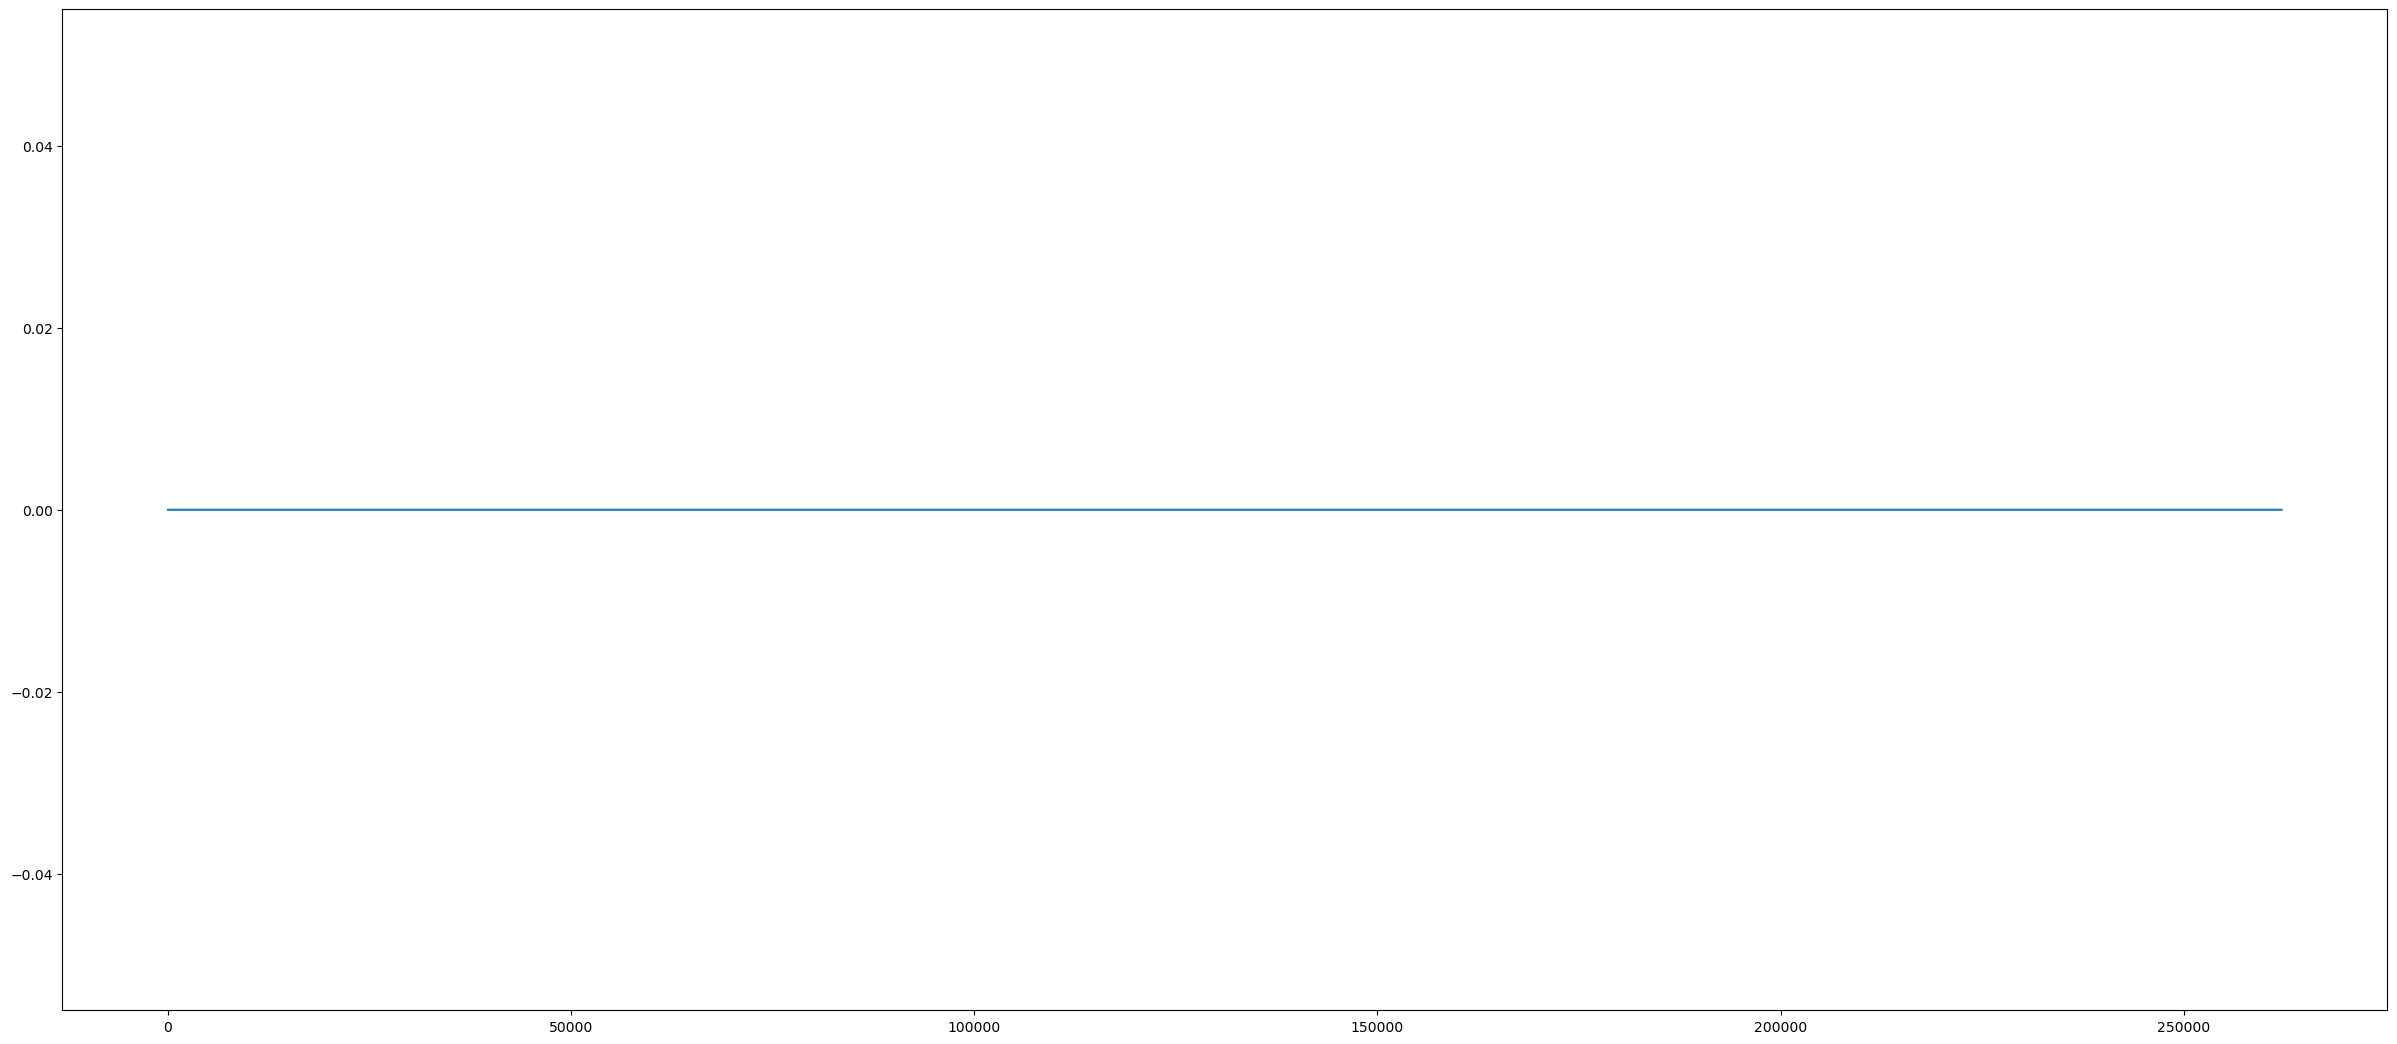

Index: 1


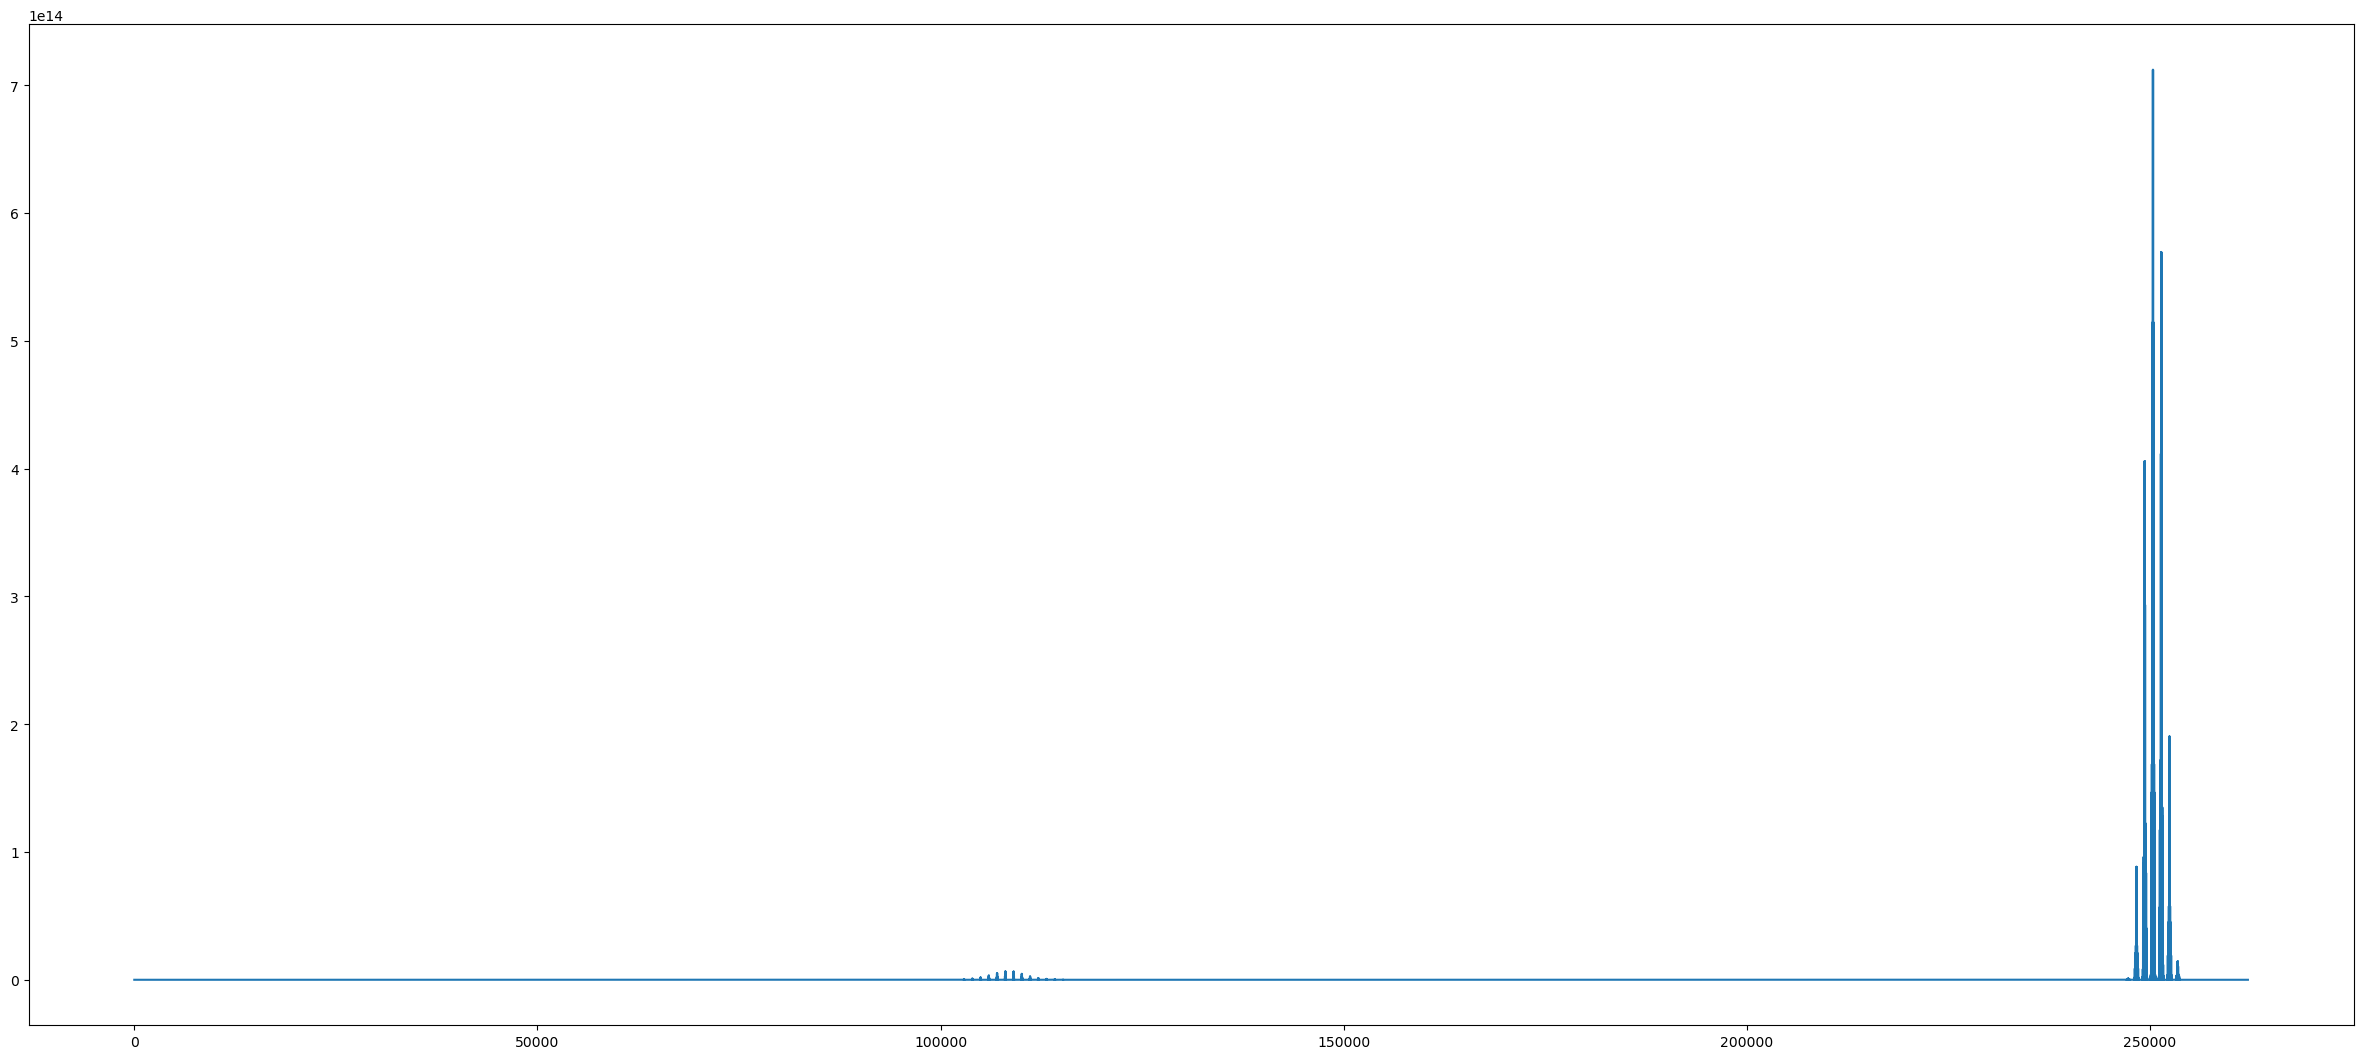

Index: 2


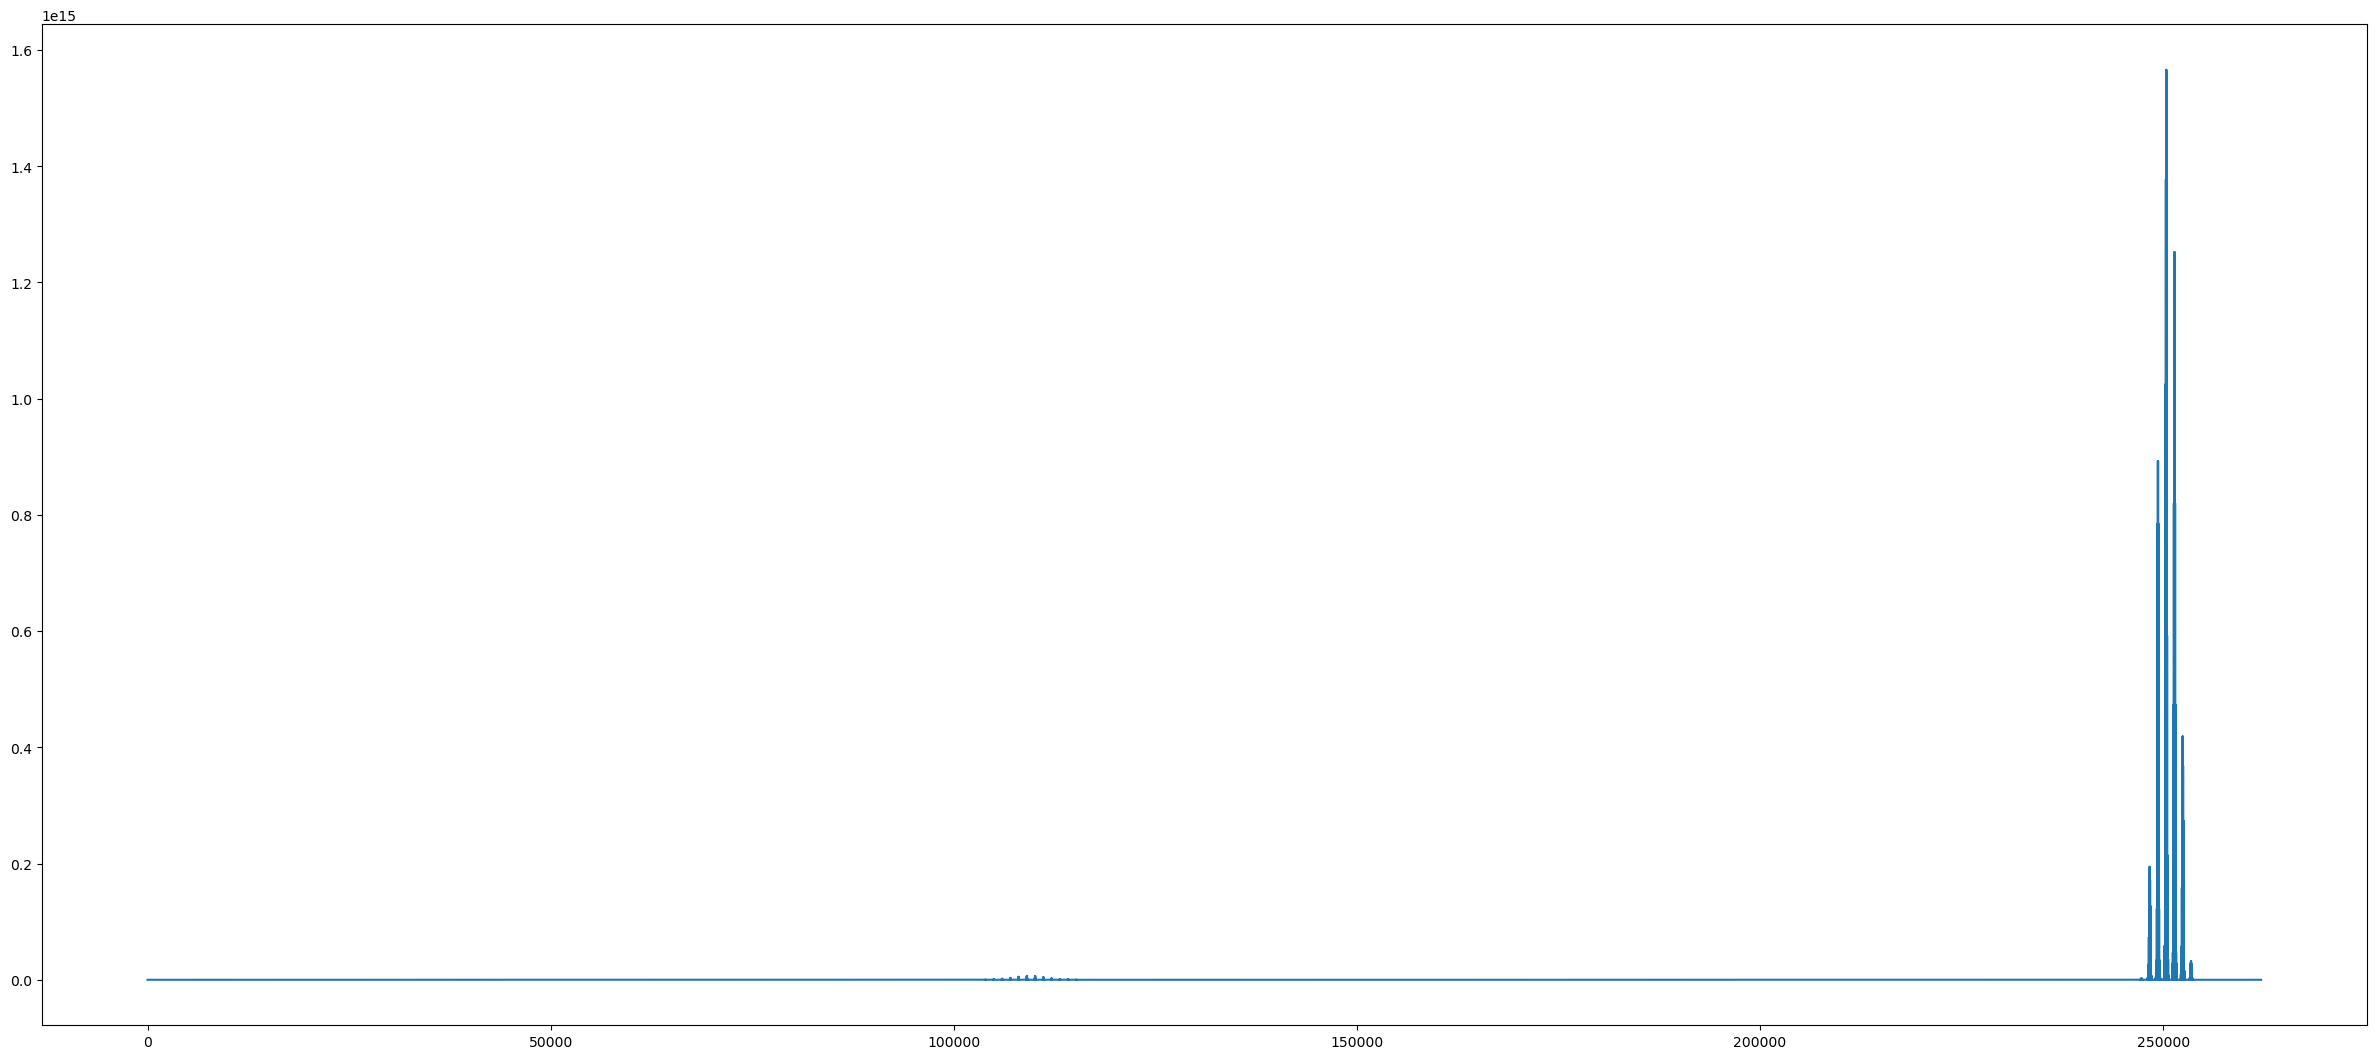

Index: 3


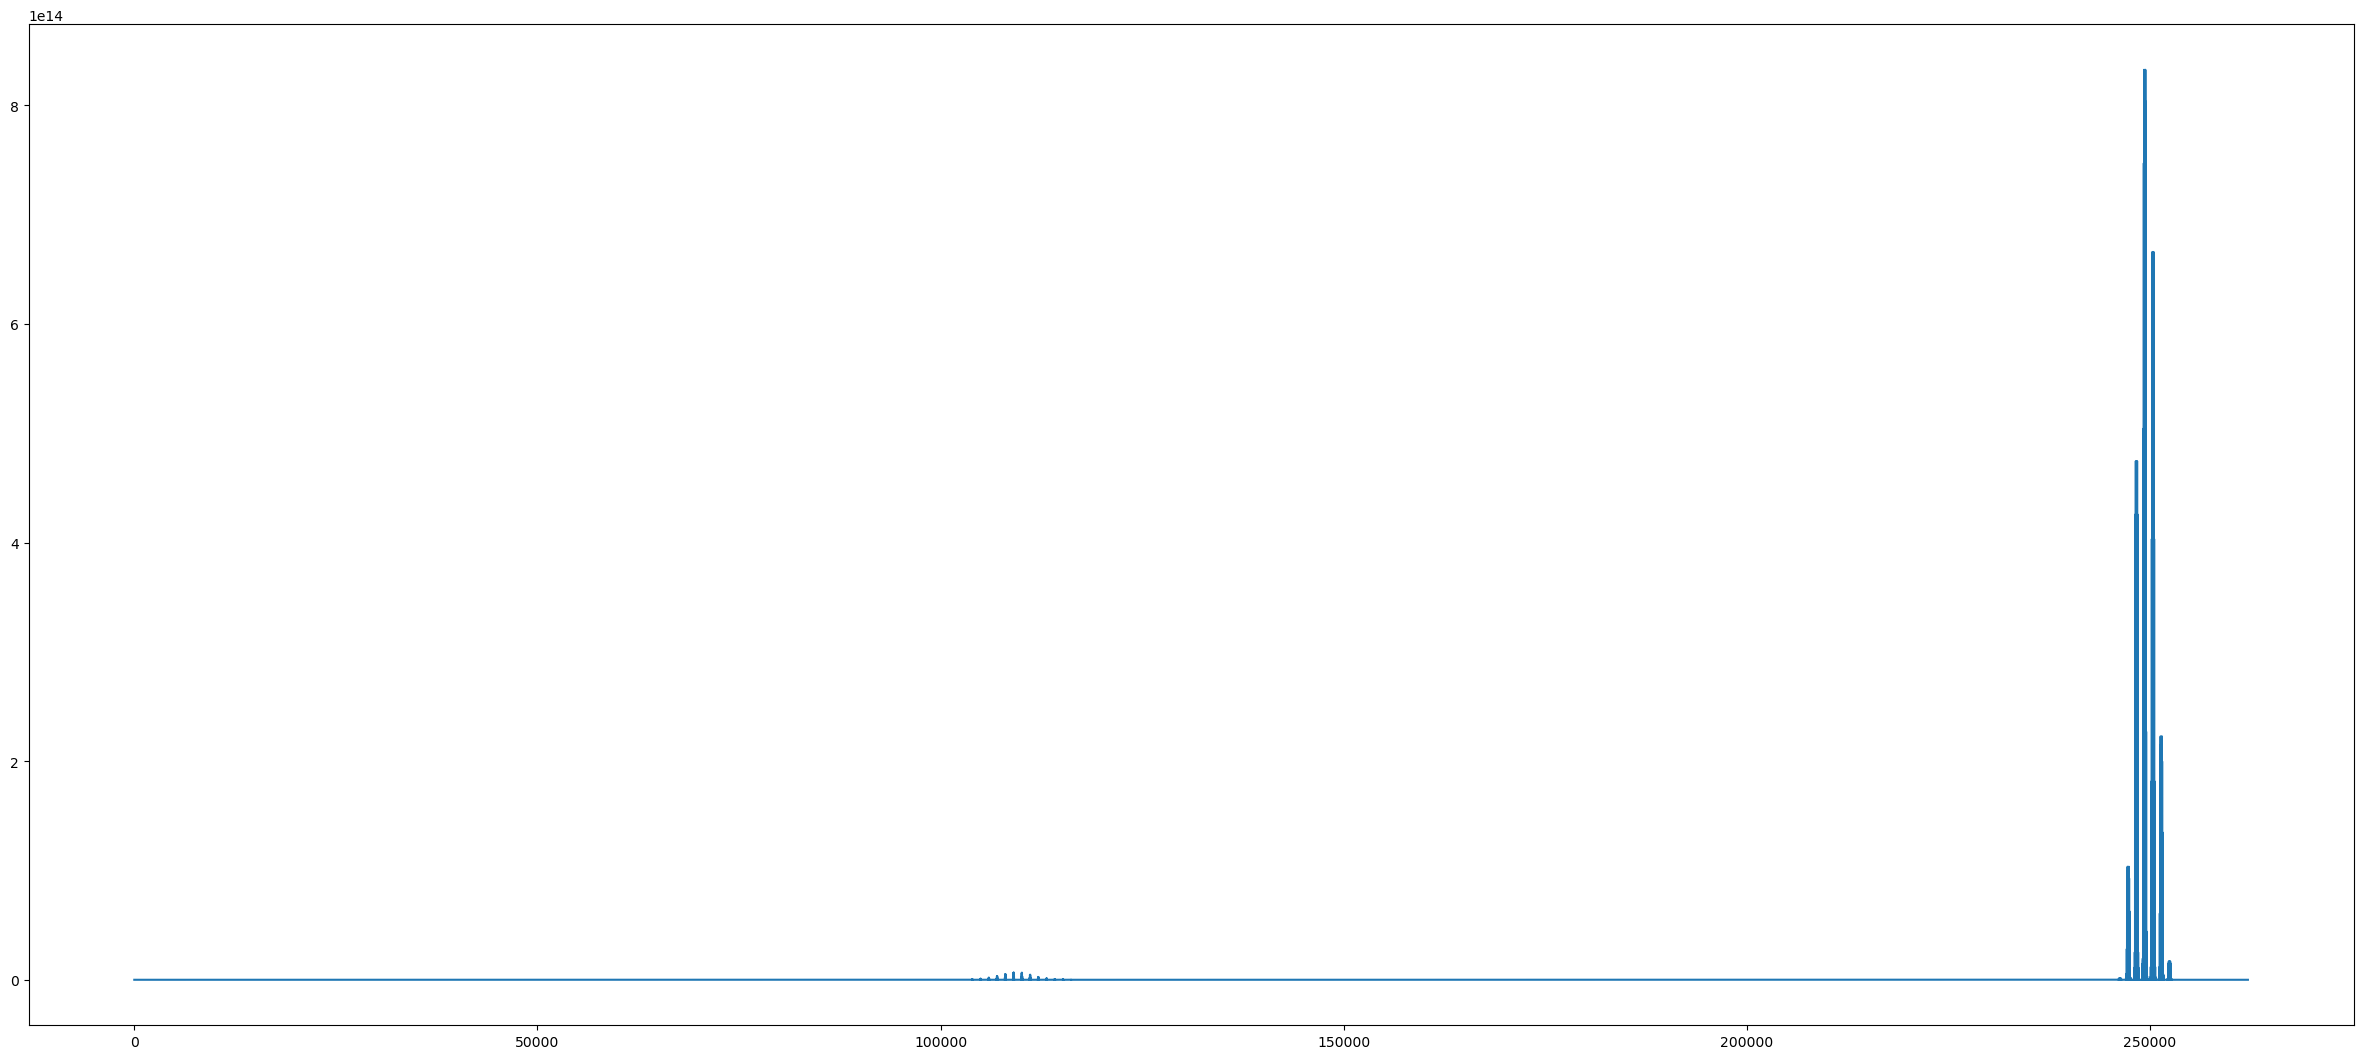

Index: 4


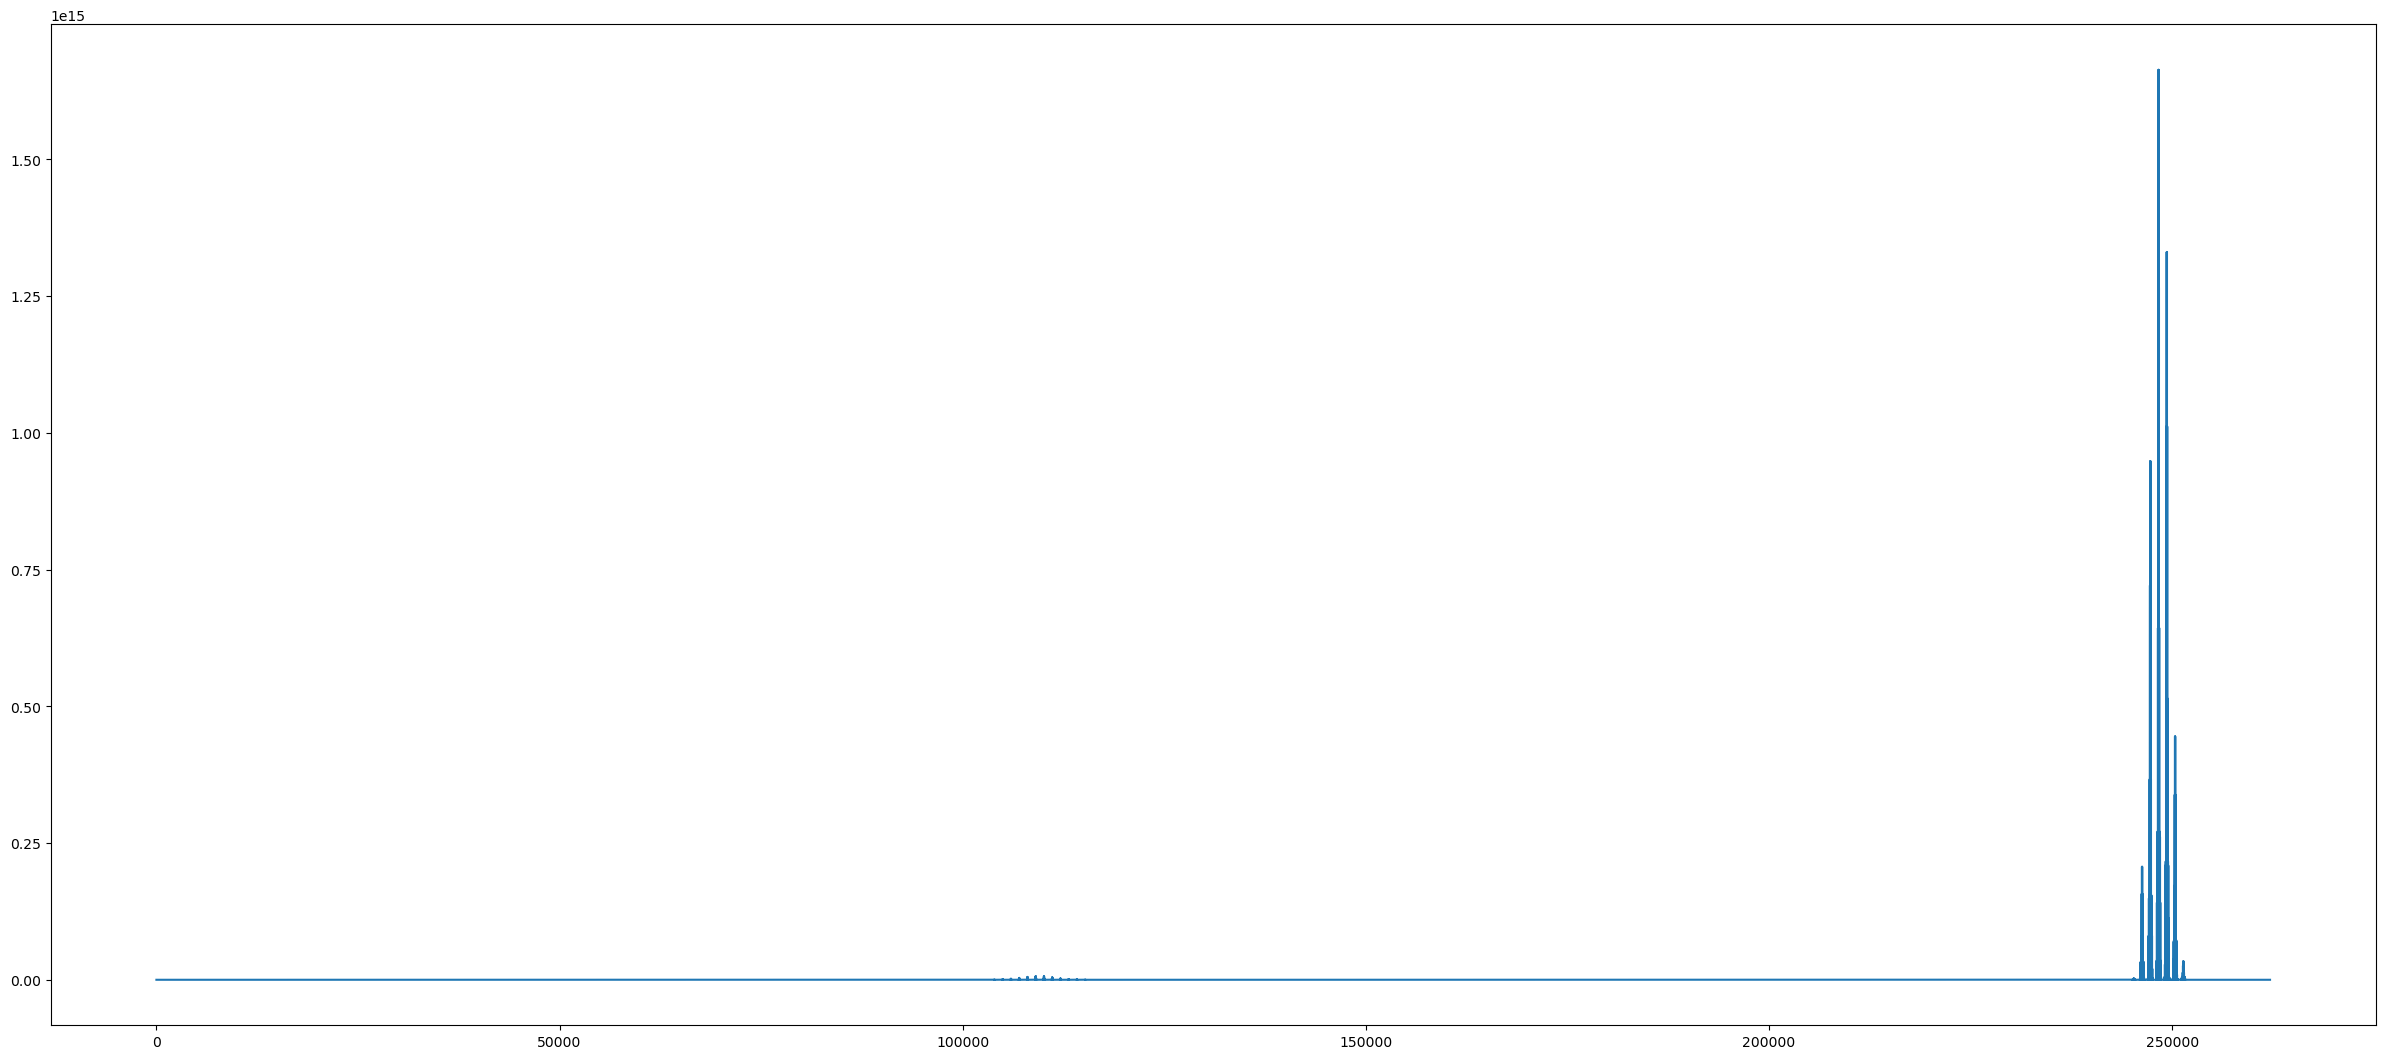

Index: 5


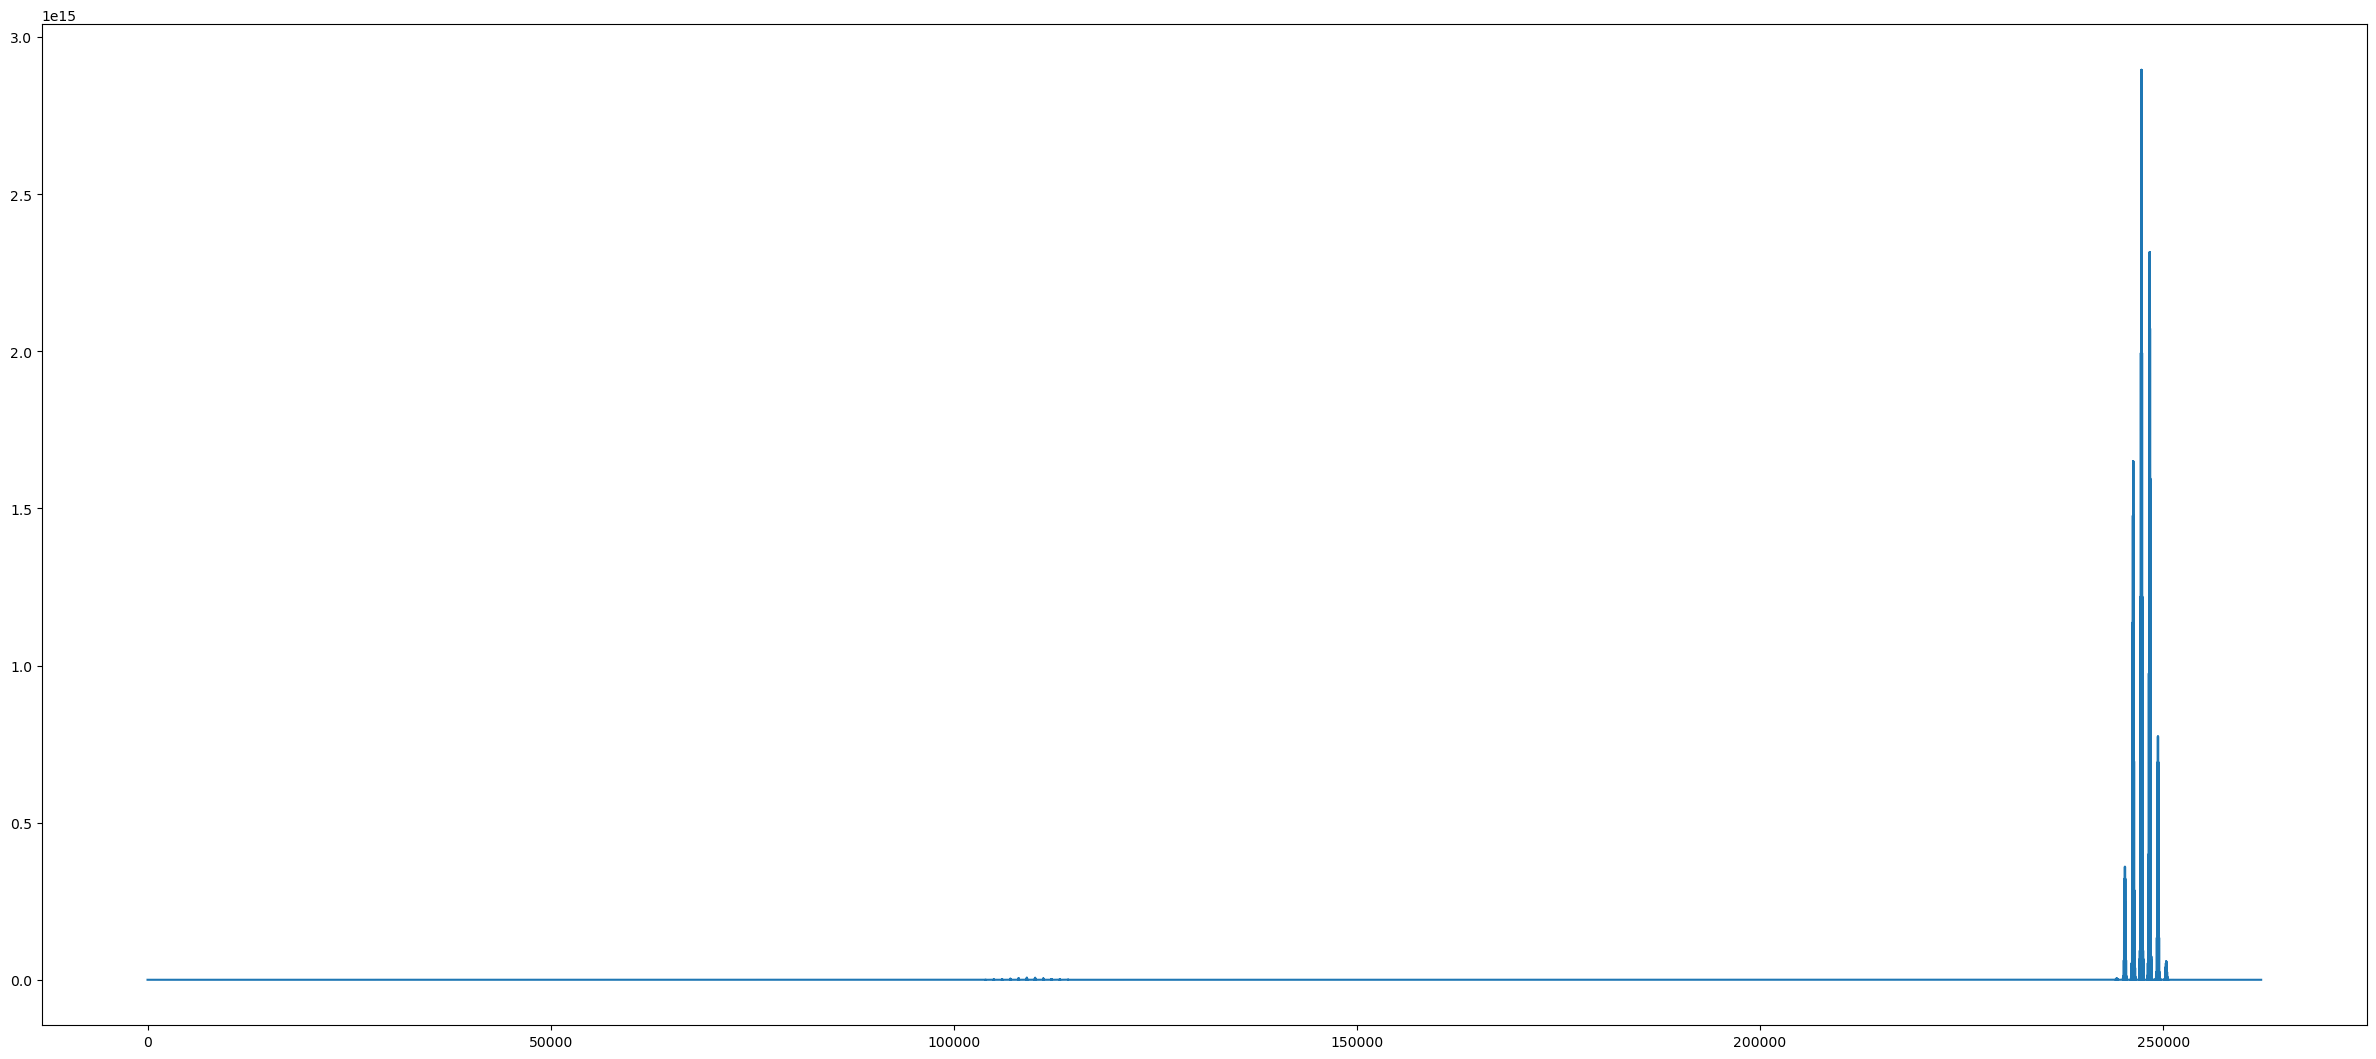

Index: 6


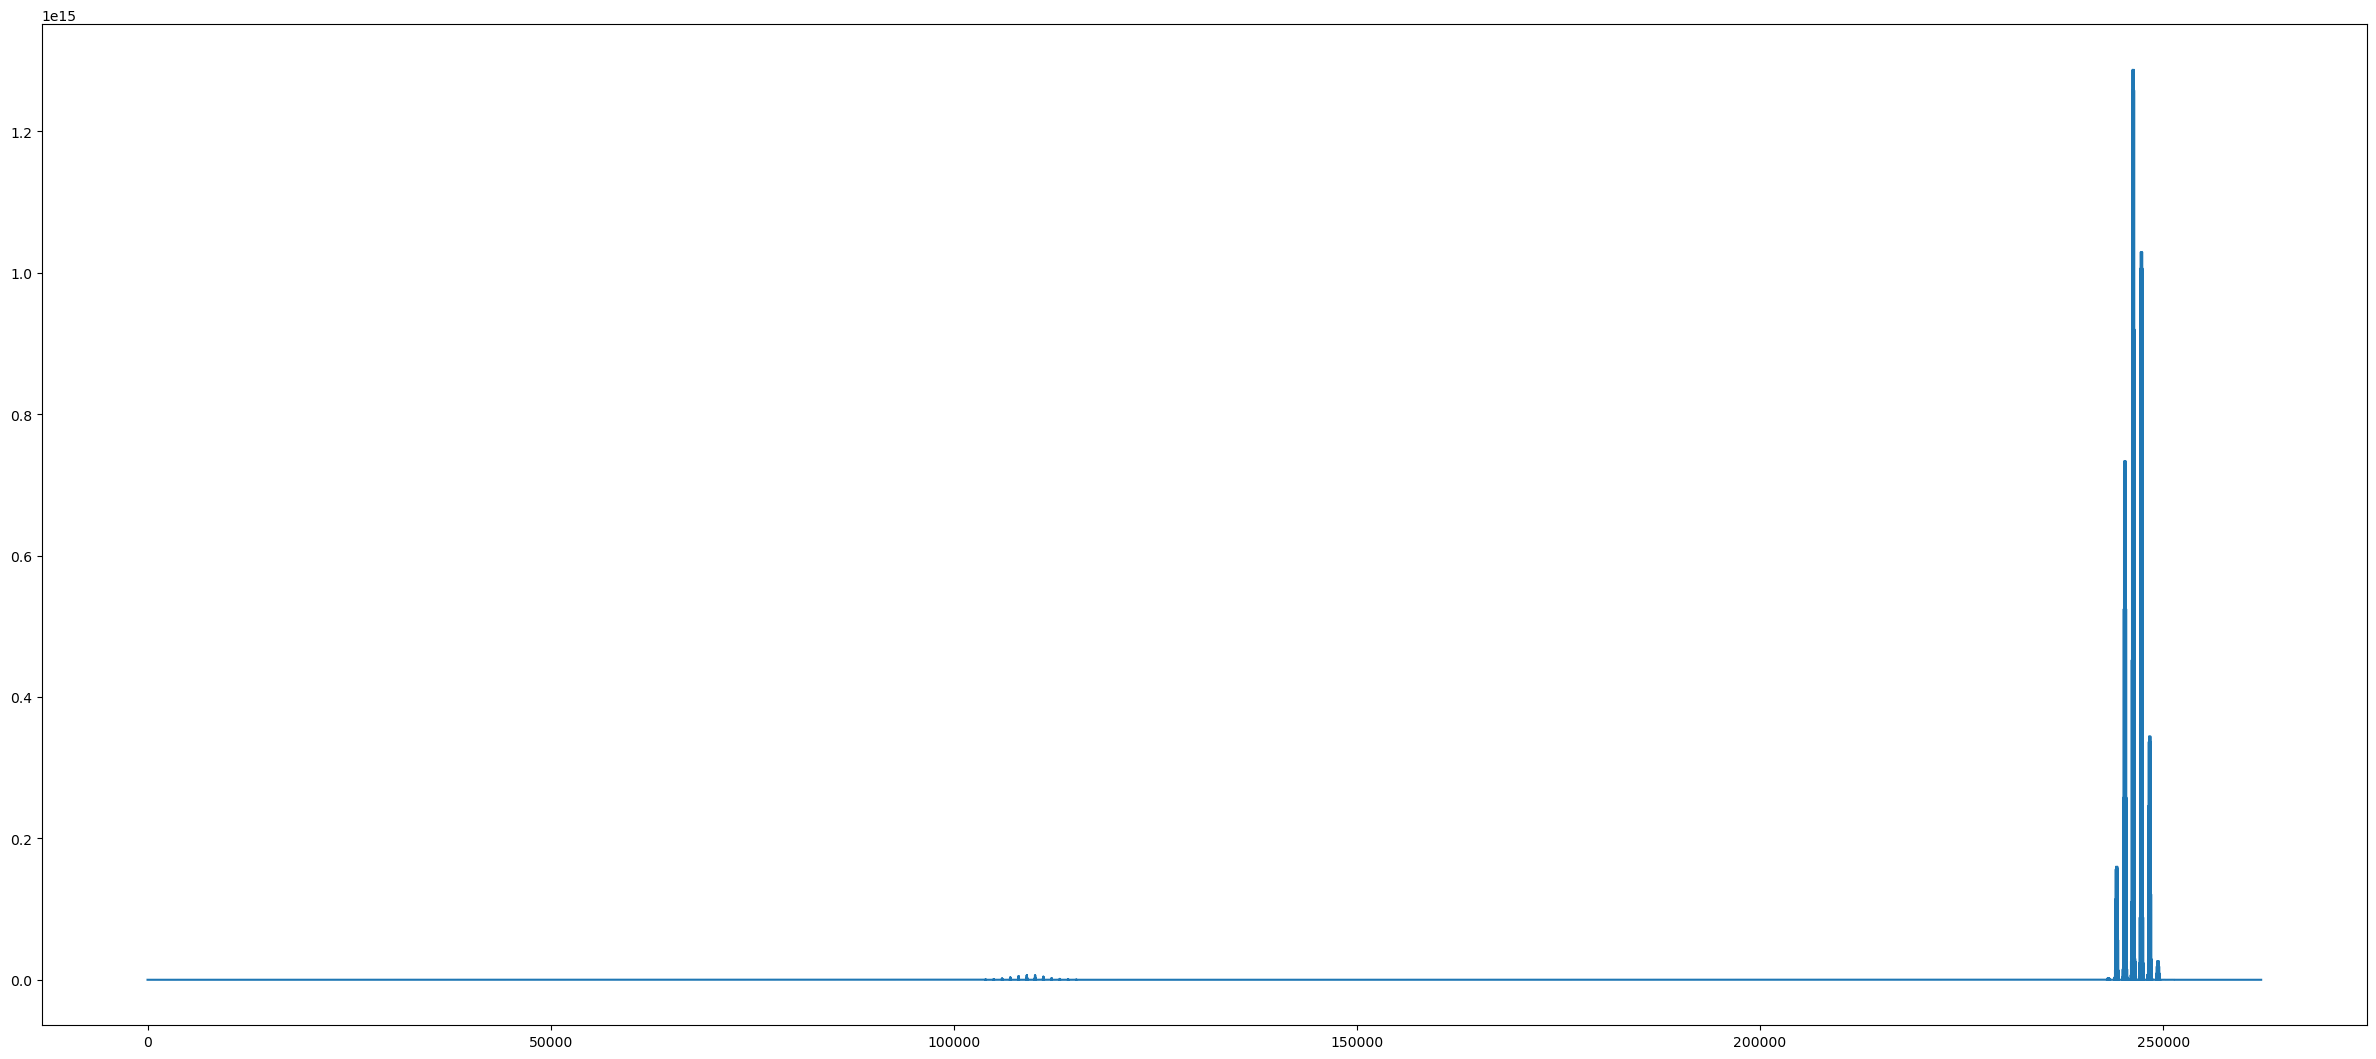

Index: 7


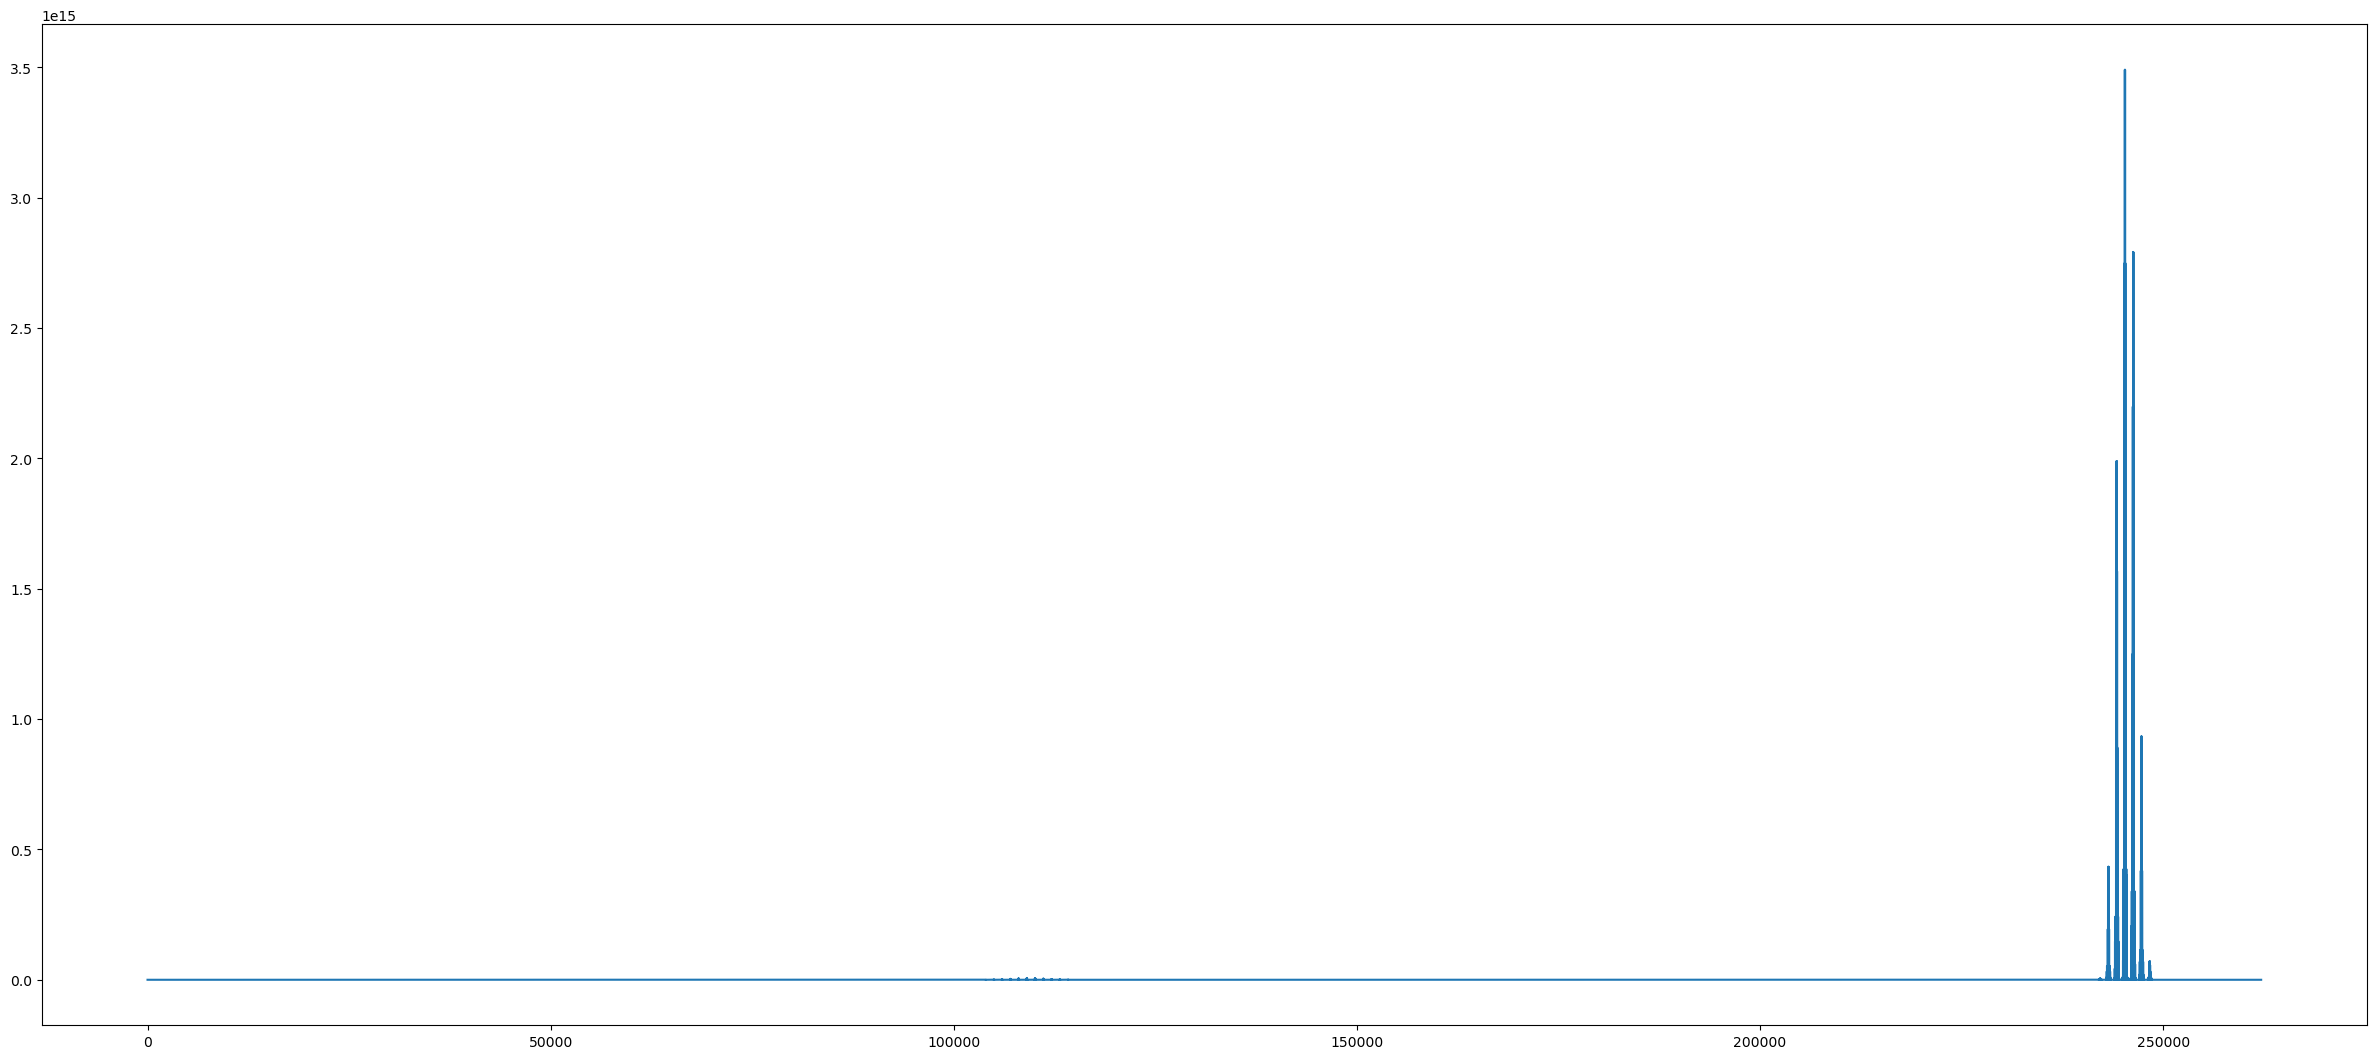

Index: 8


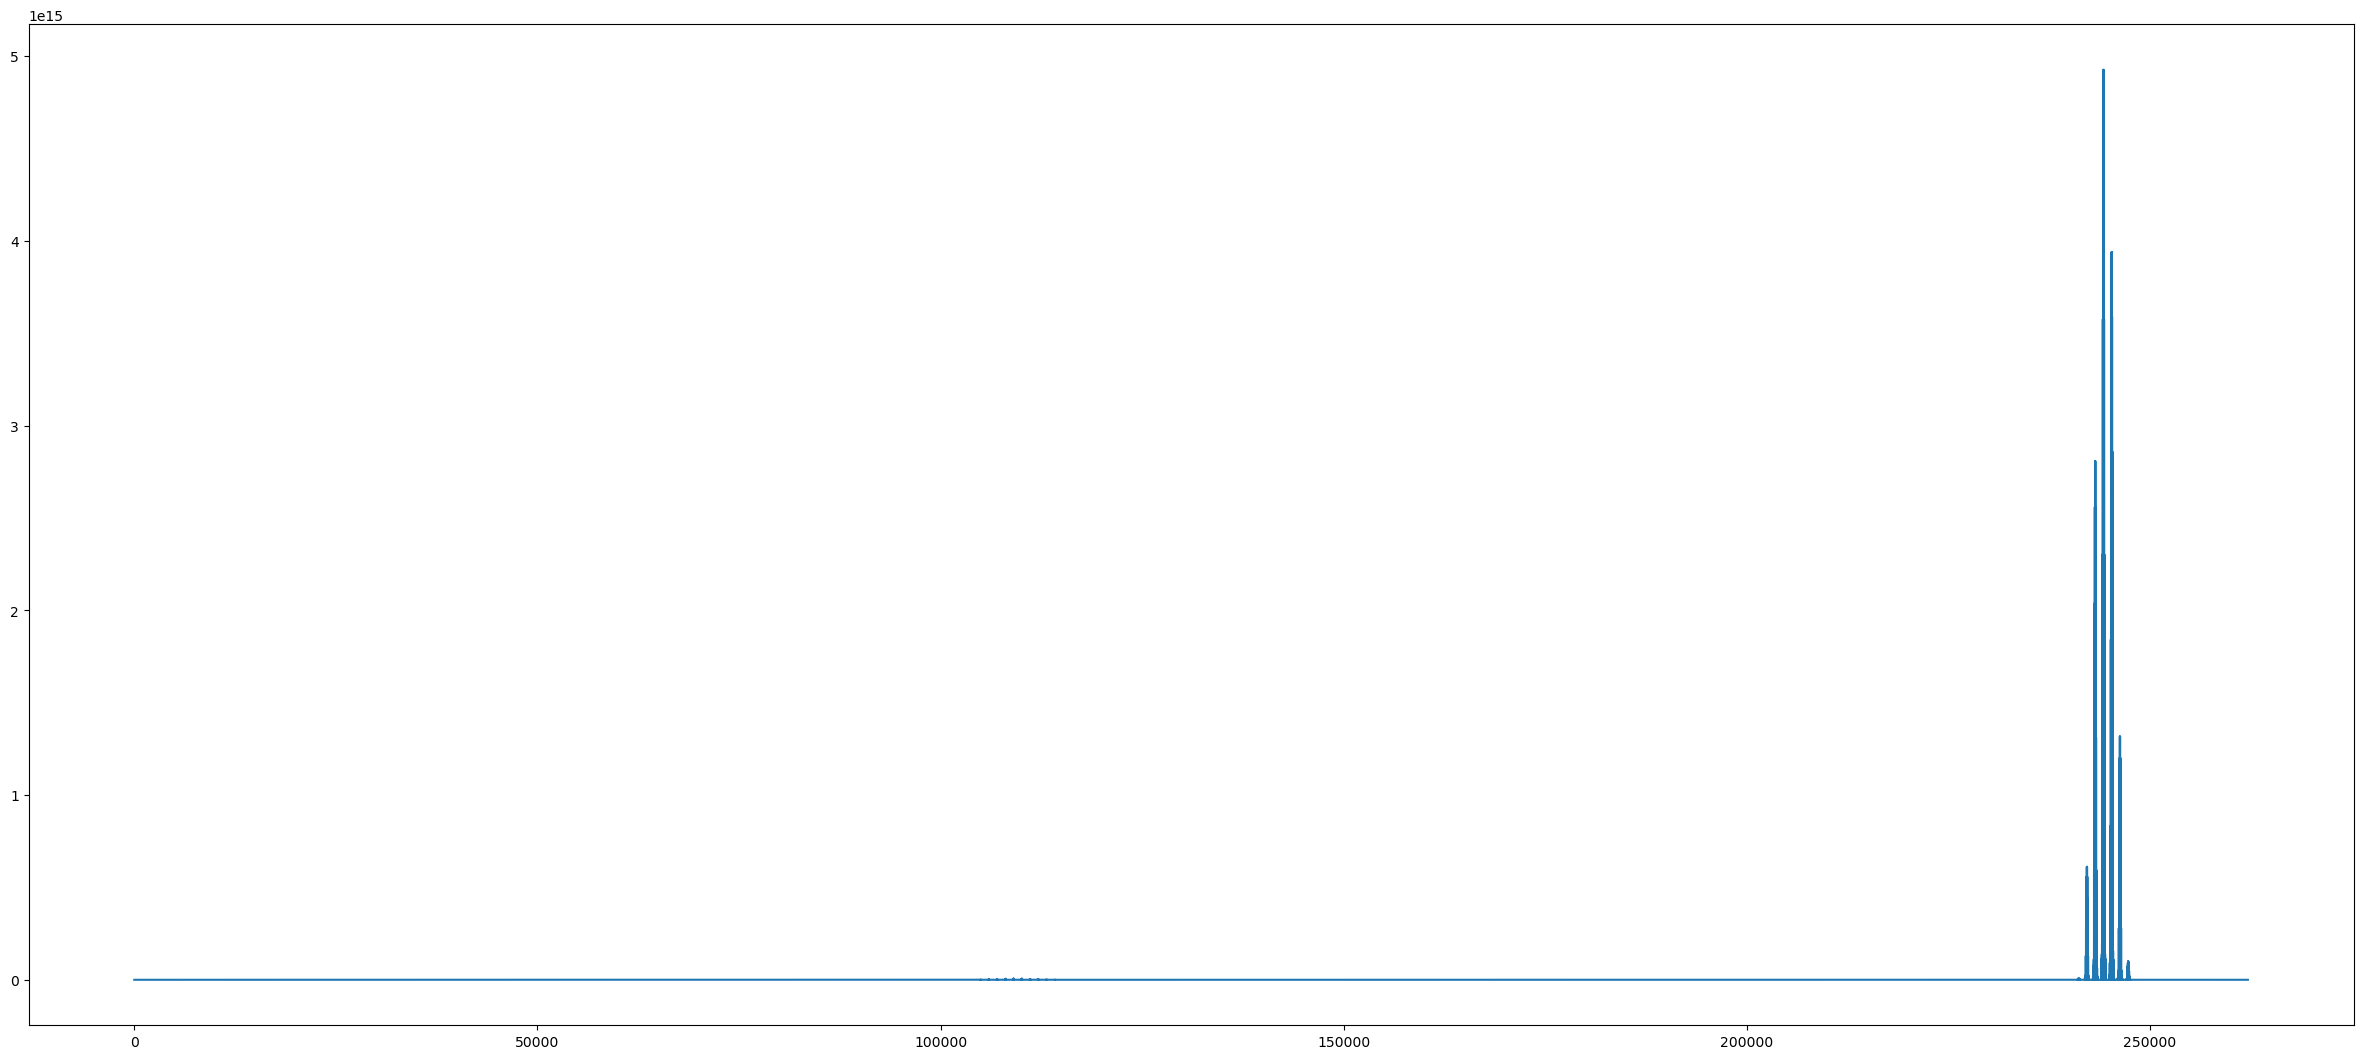

Index: 9


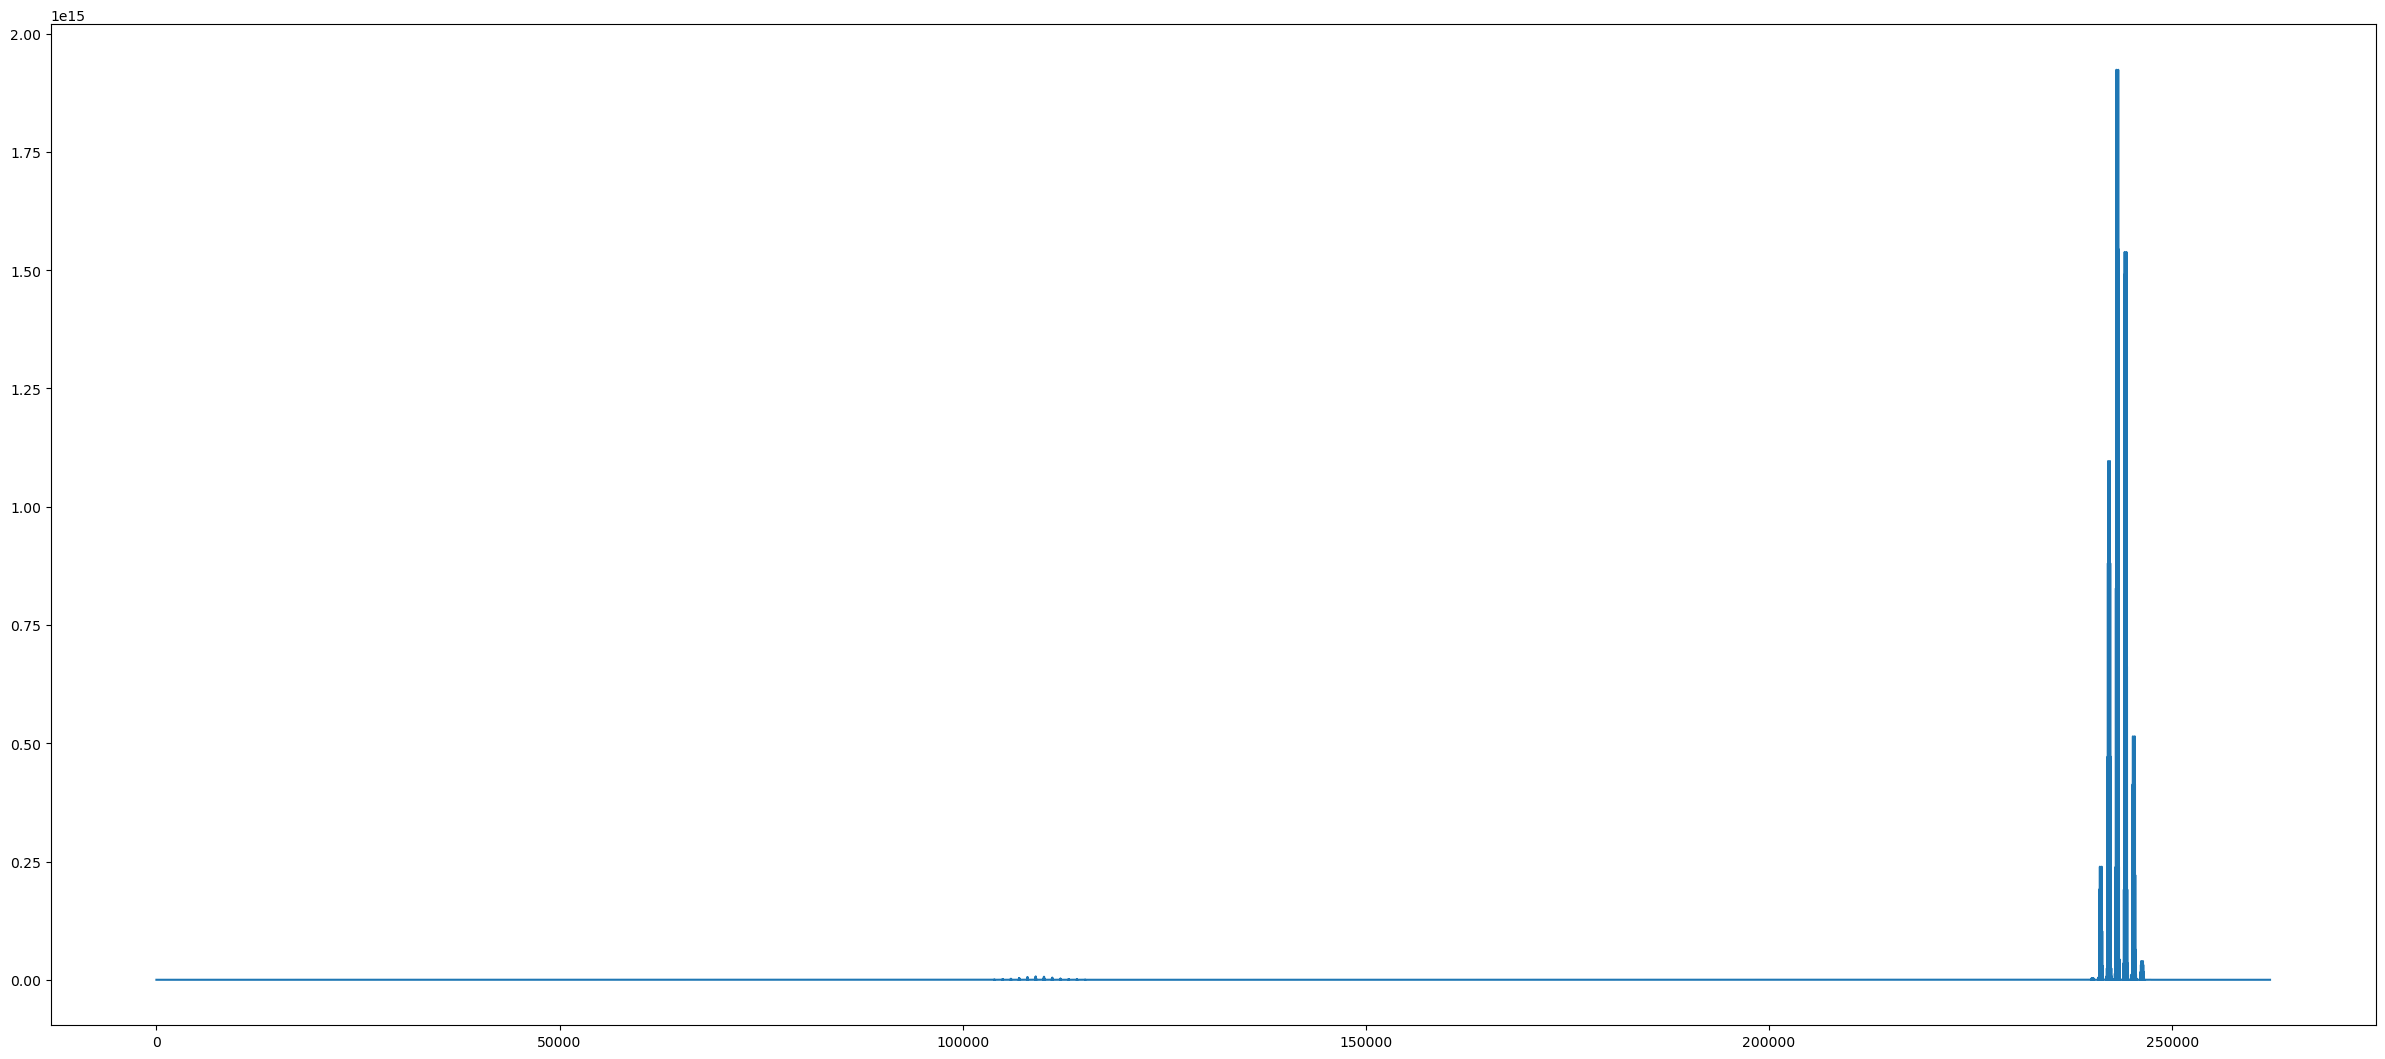

Index: 10


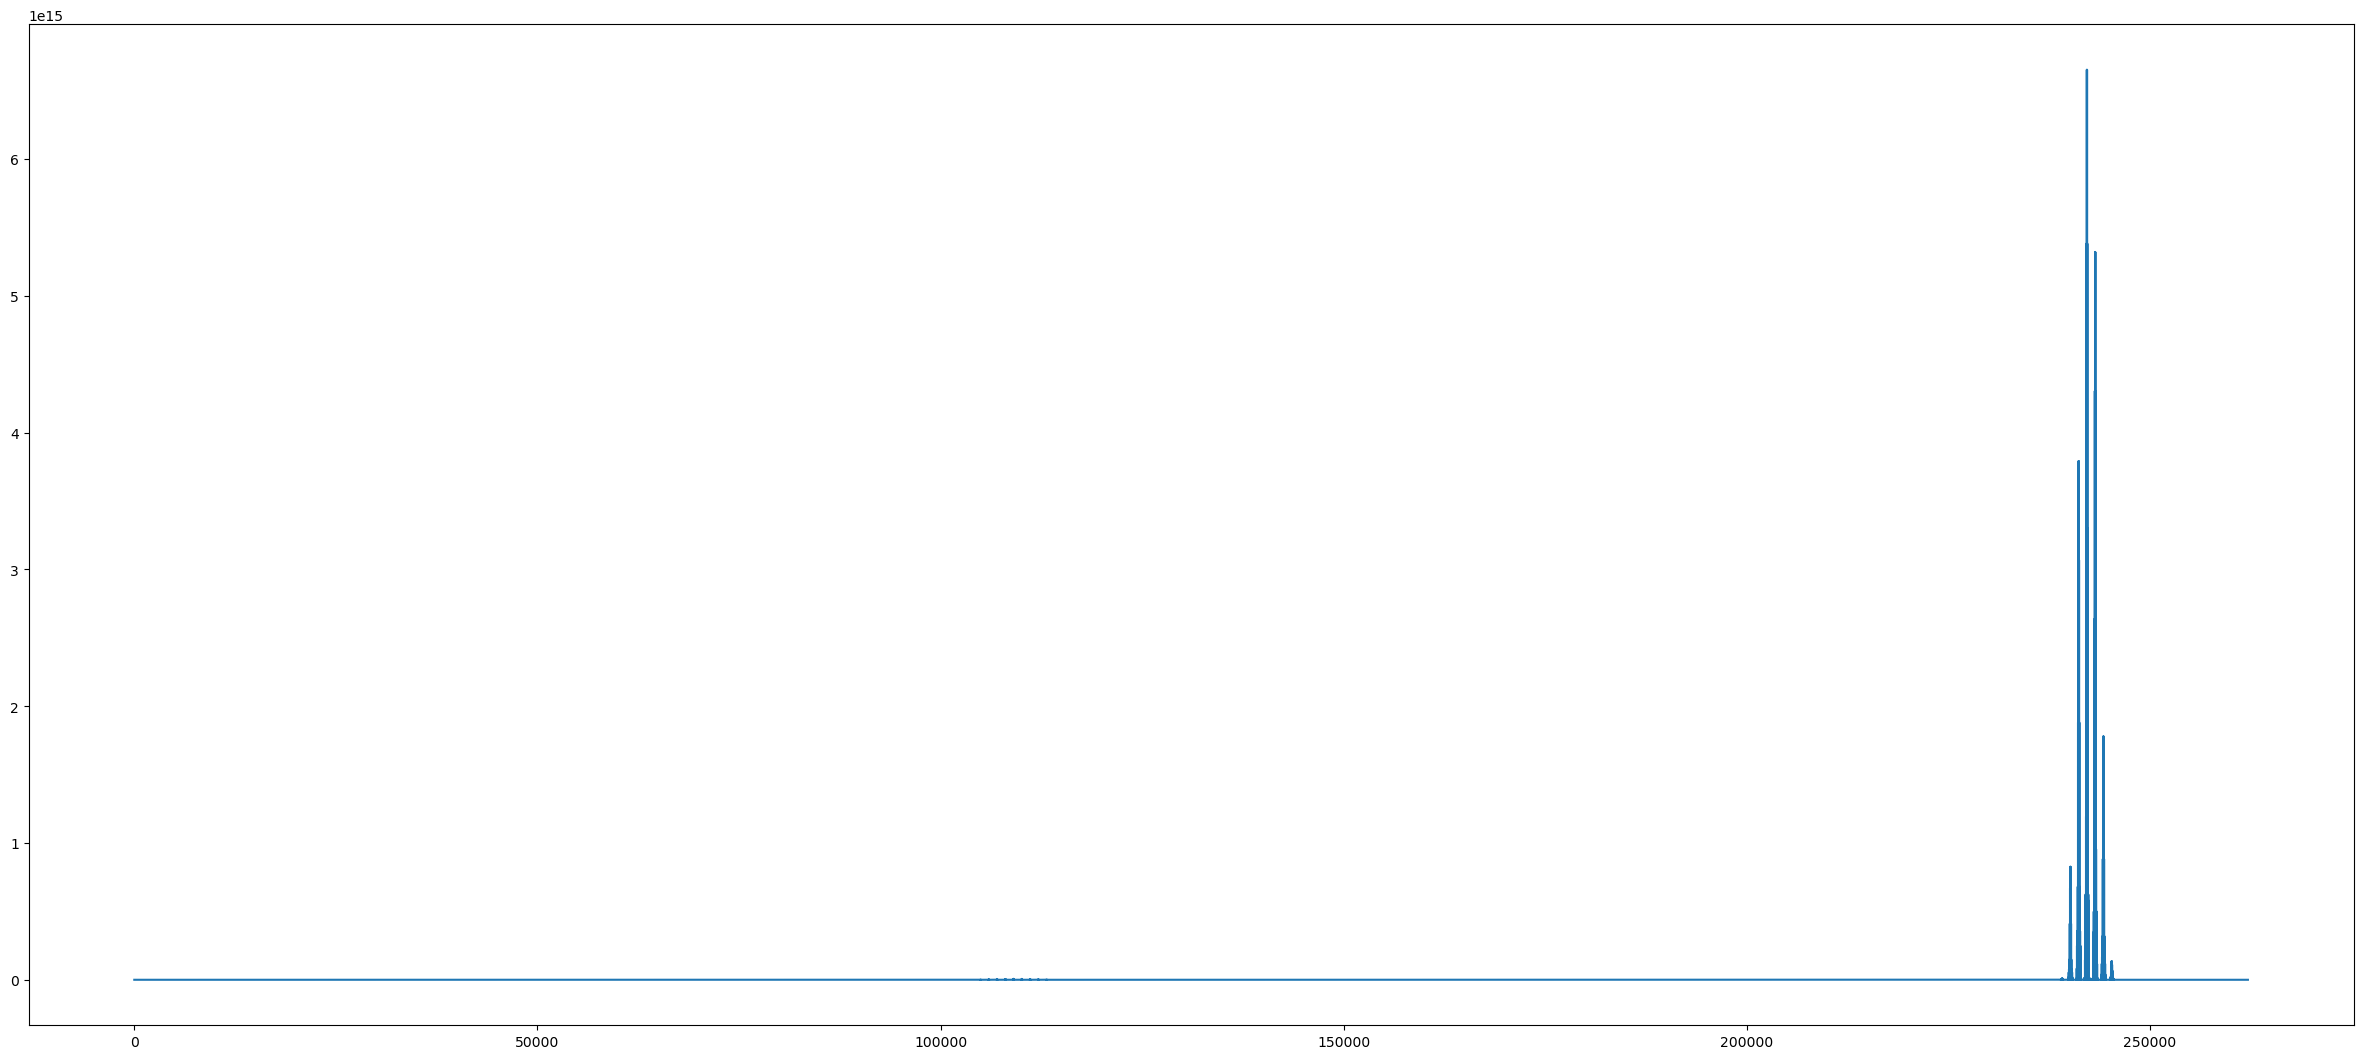

Index: 11


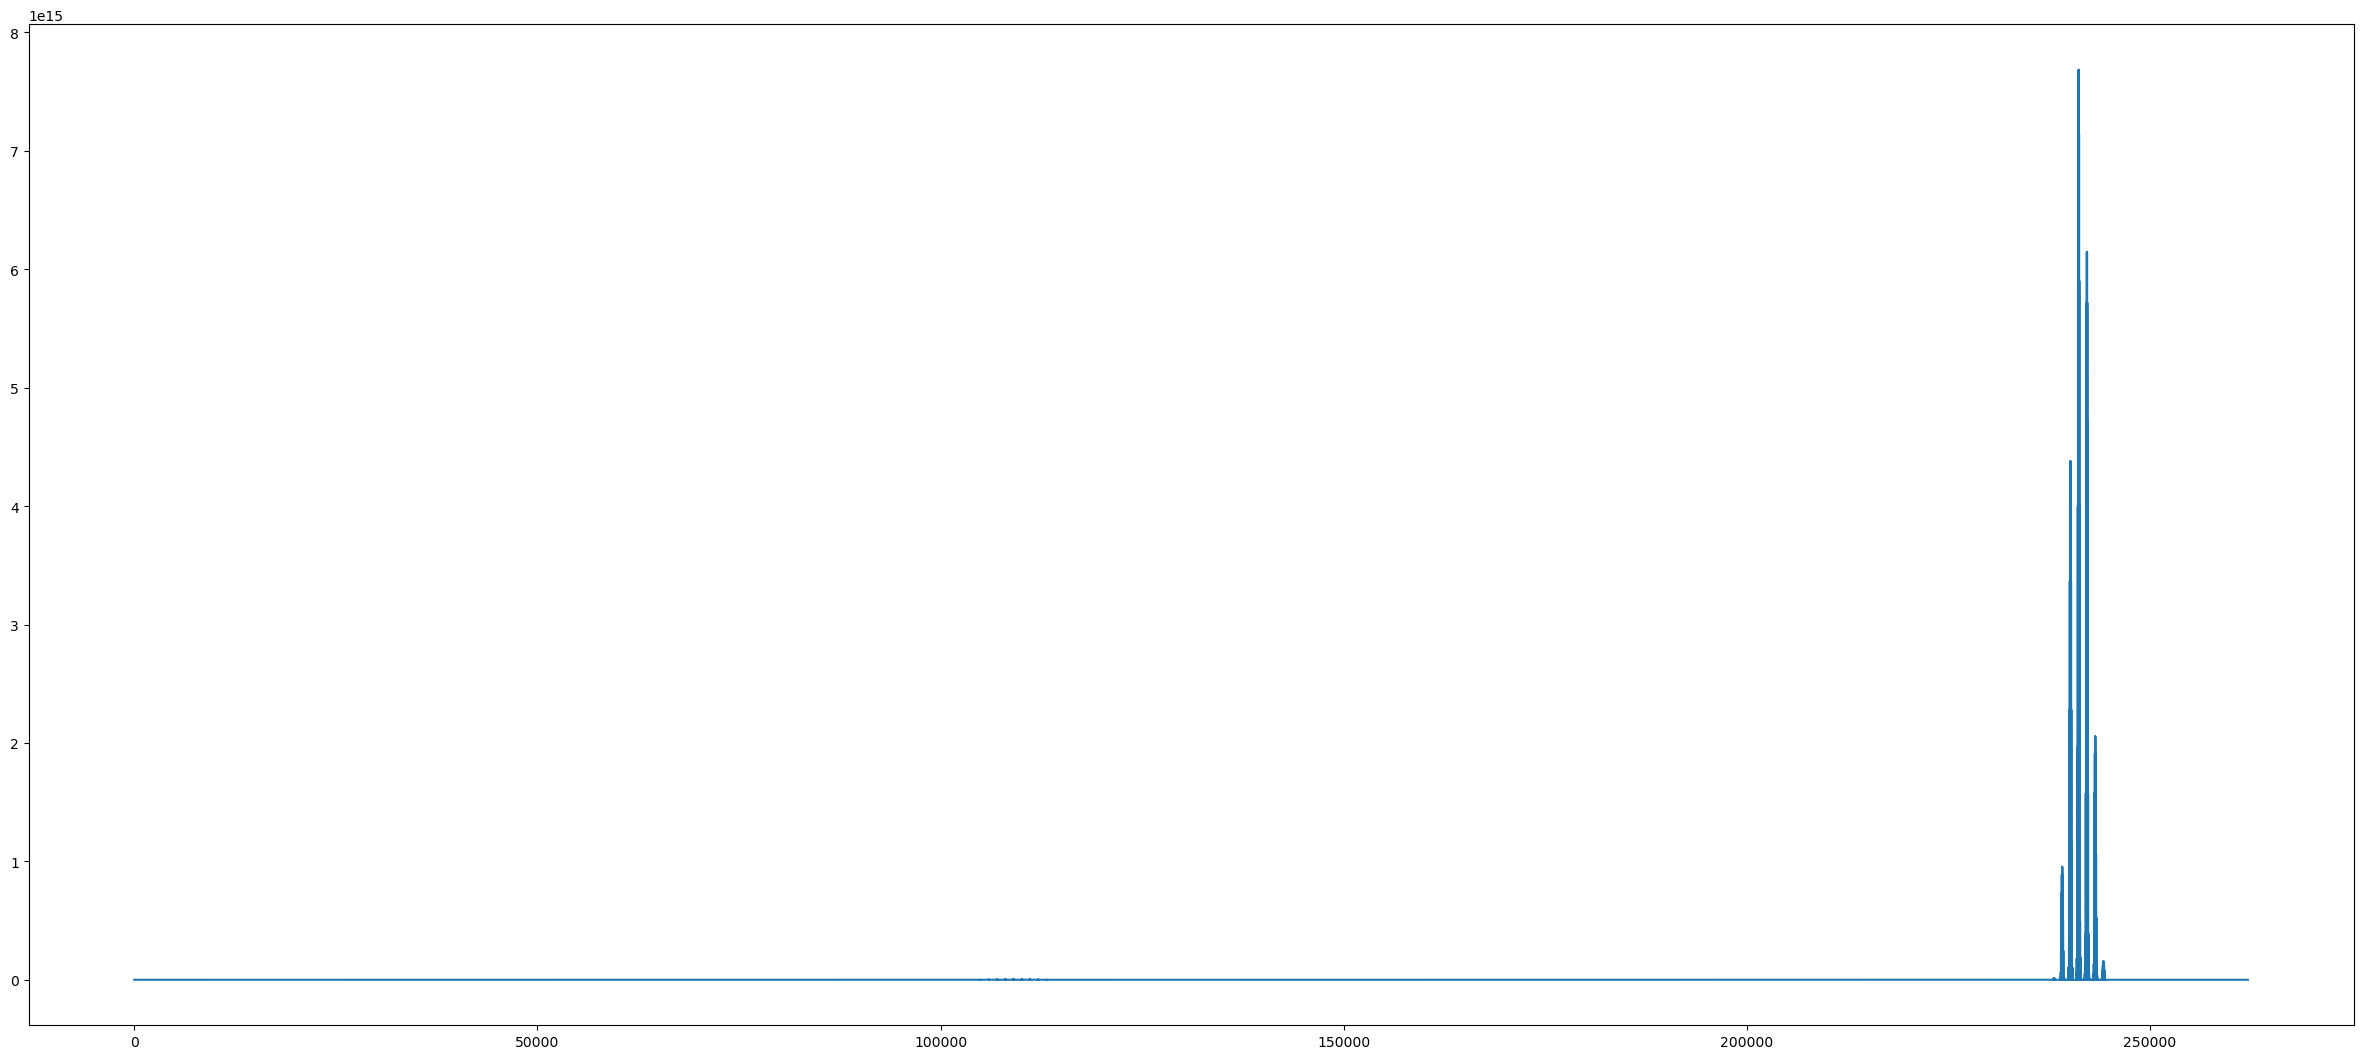

Index: 12


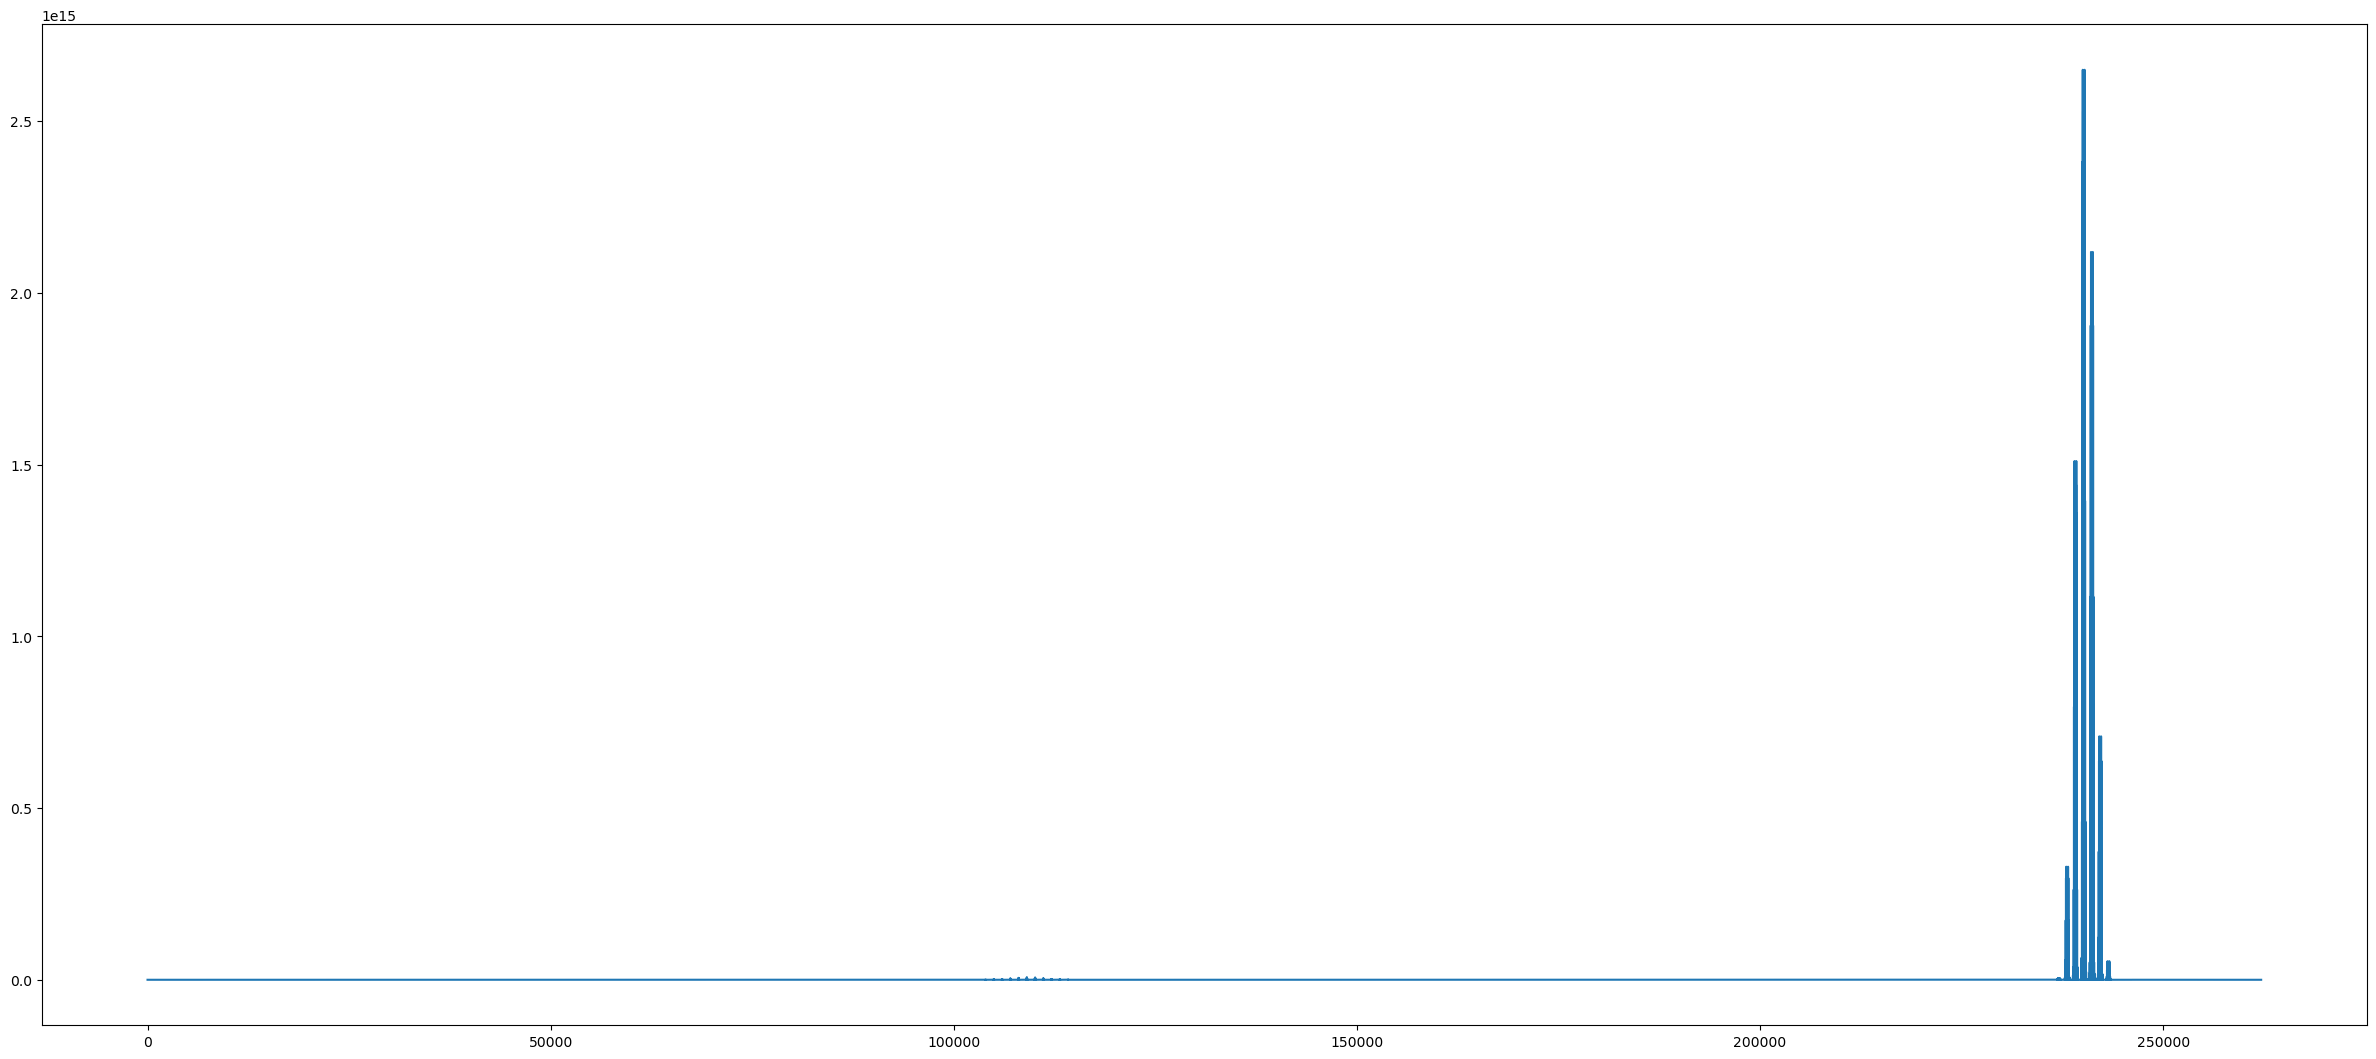

Index: 13


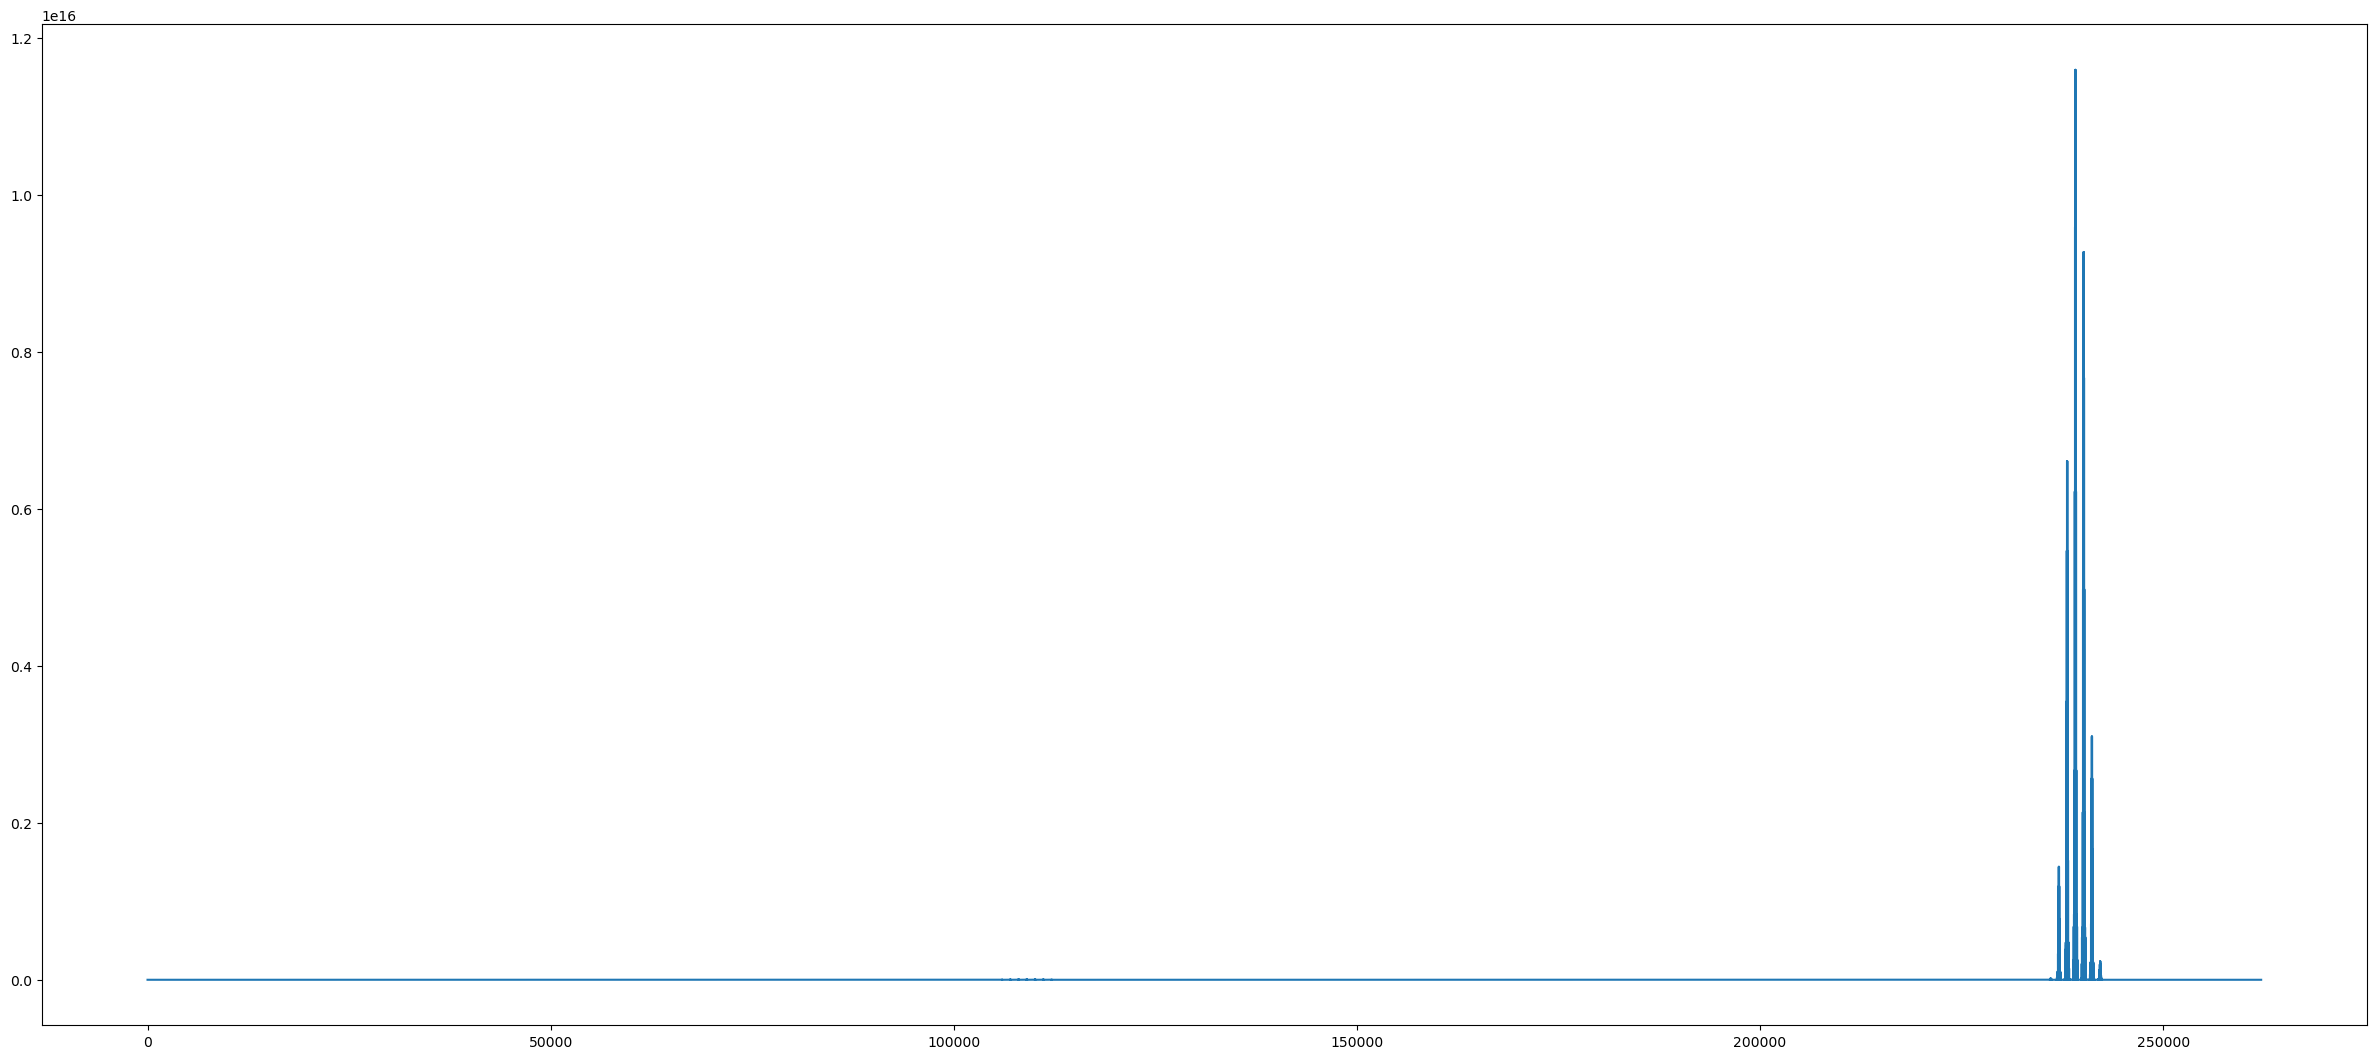

Index: 14


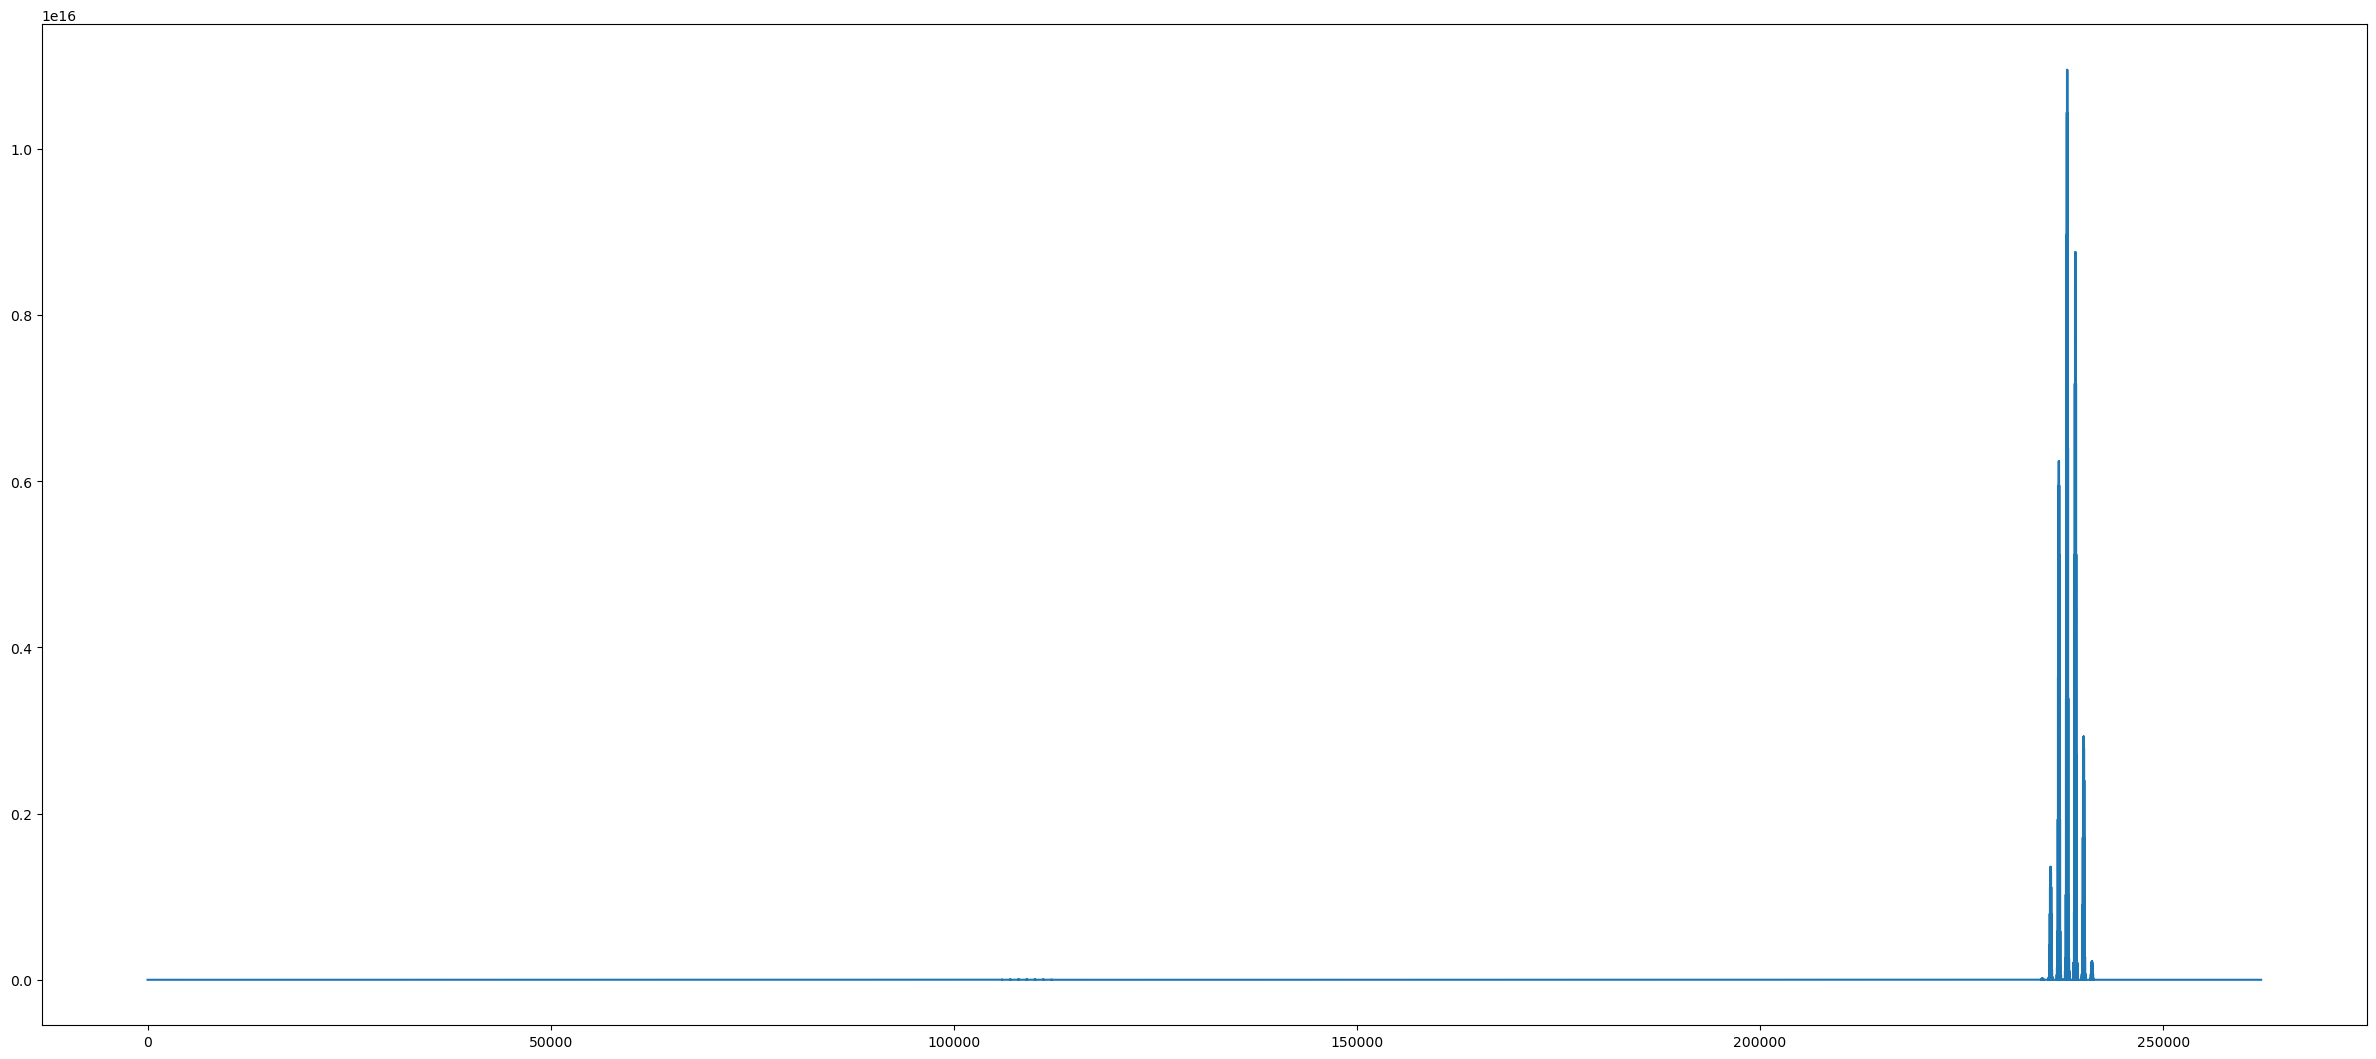

Index: 15


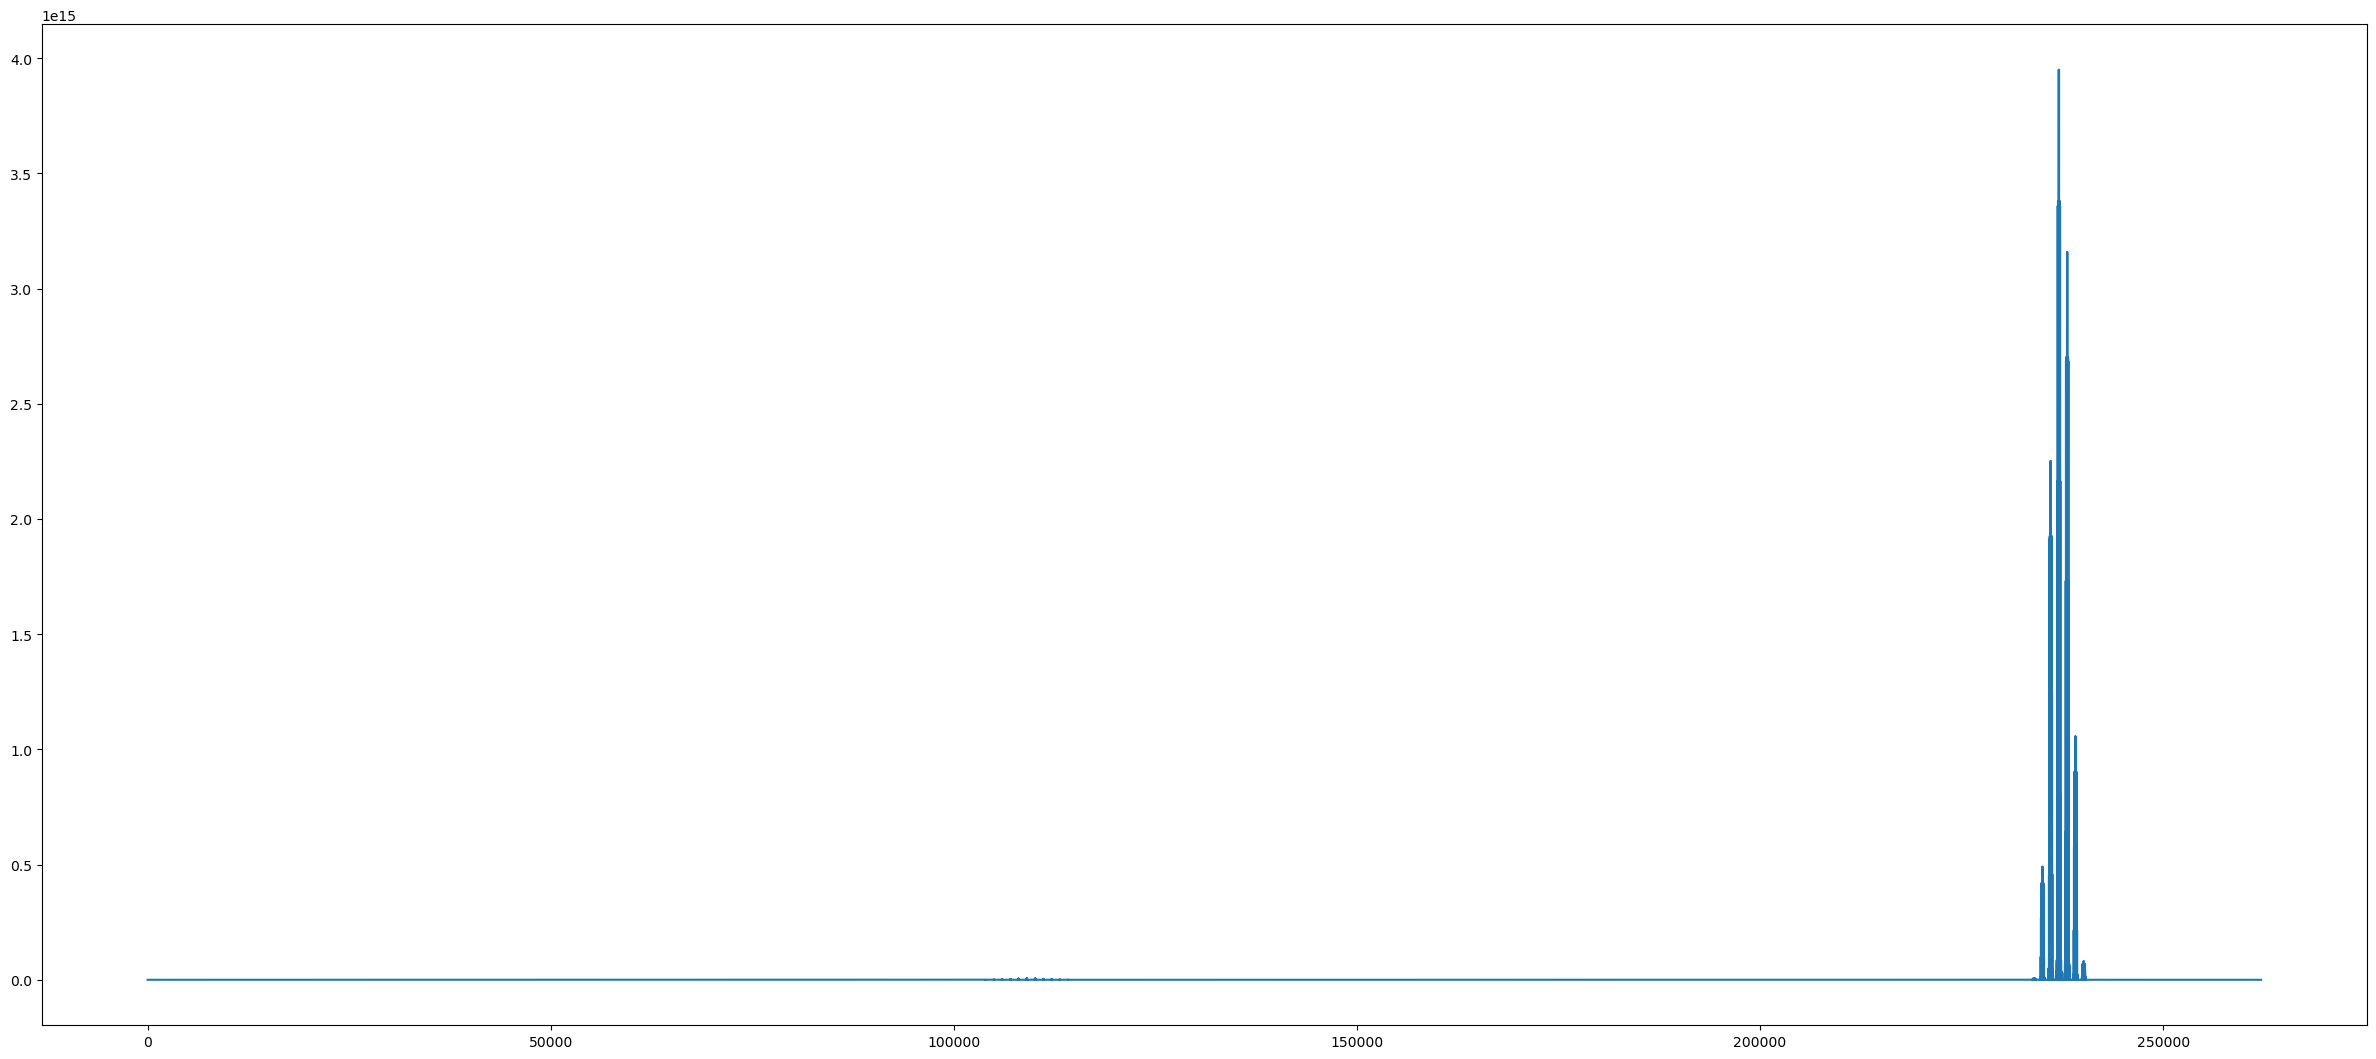

Index: 16


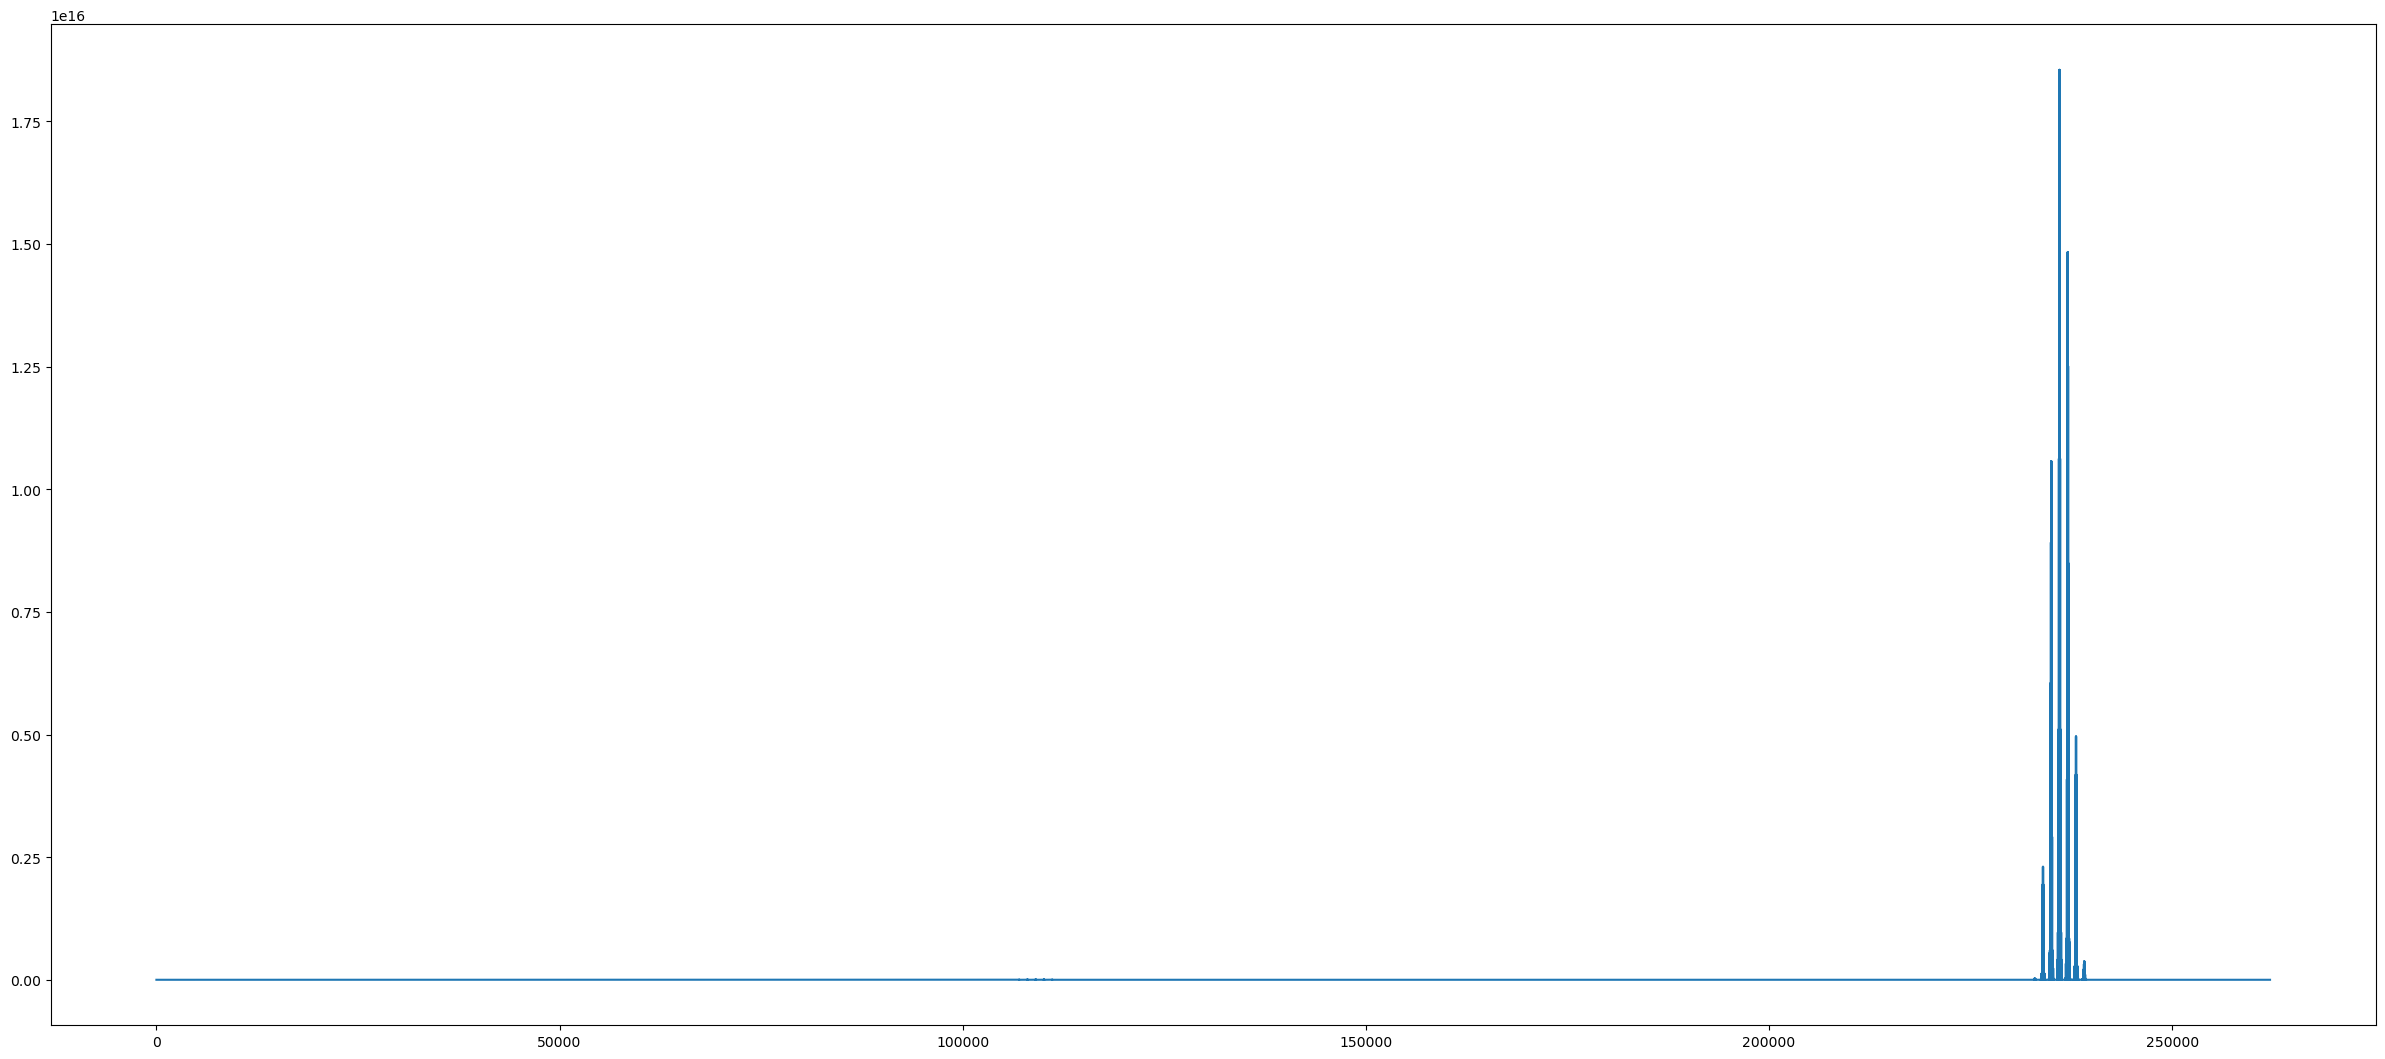

Index: 17


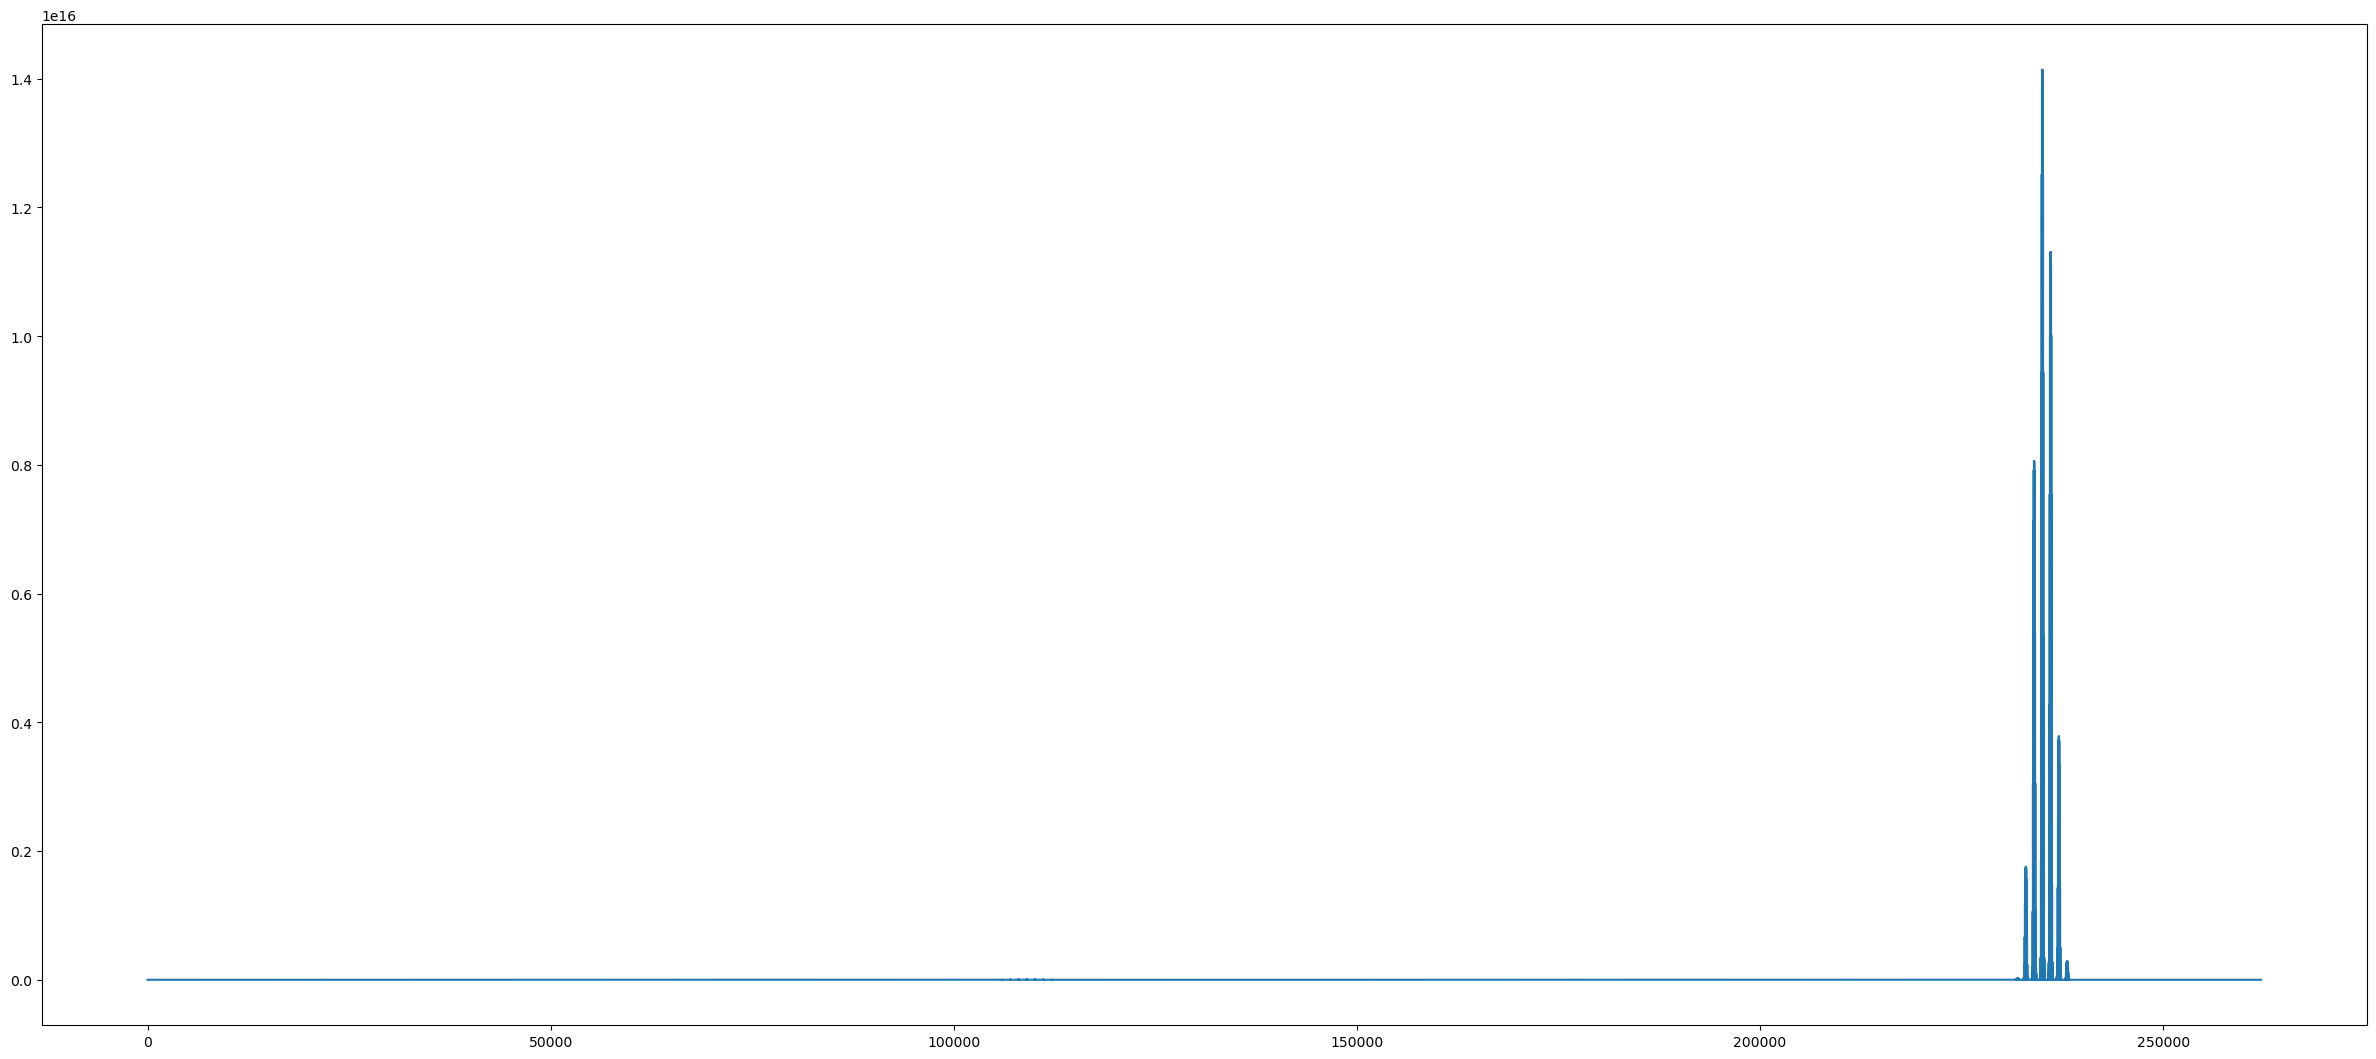

Index: 18


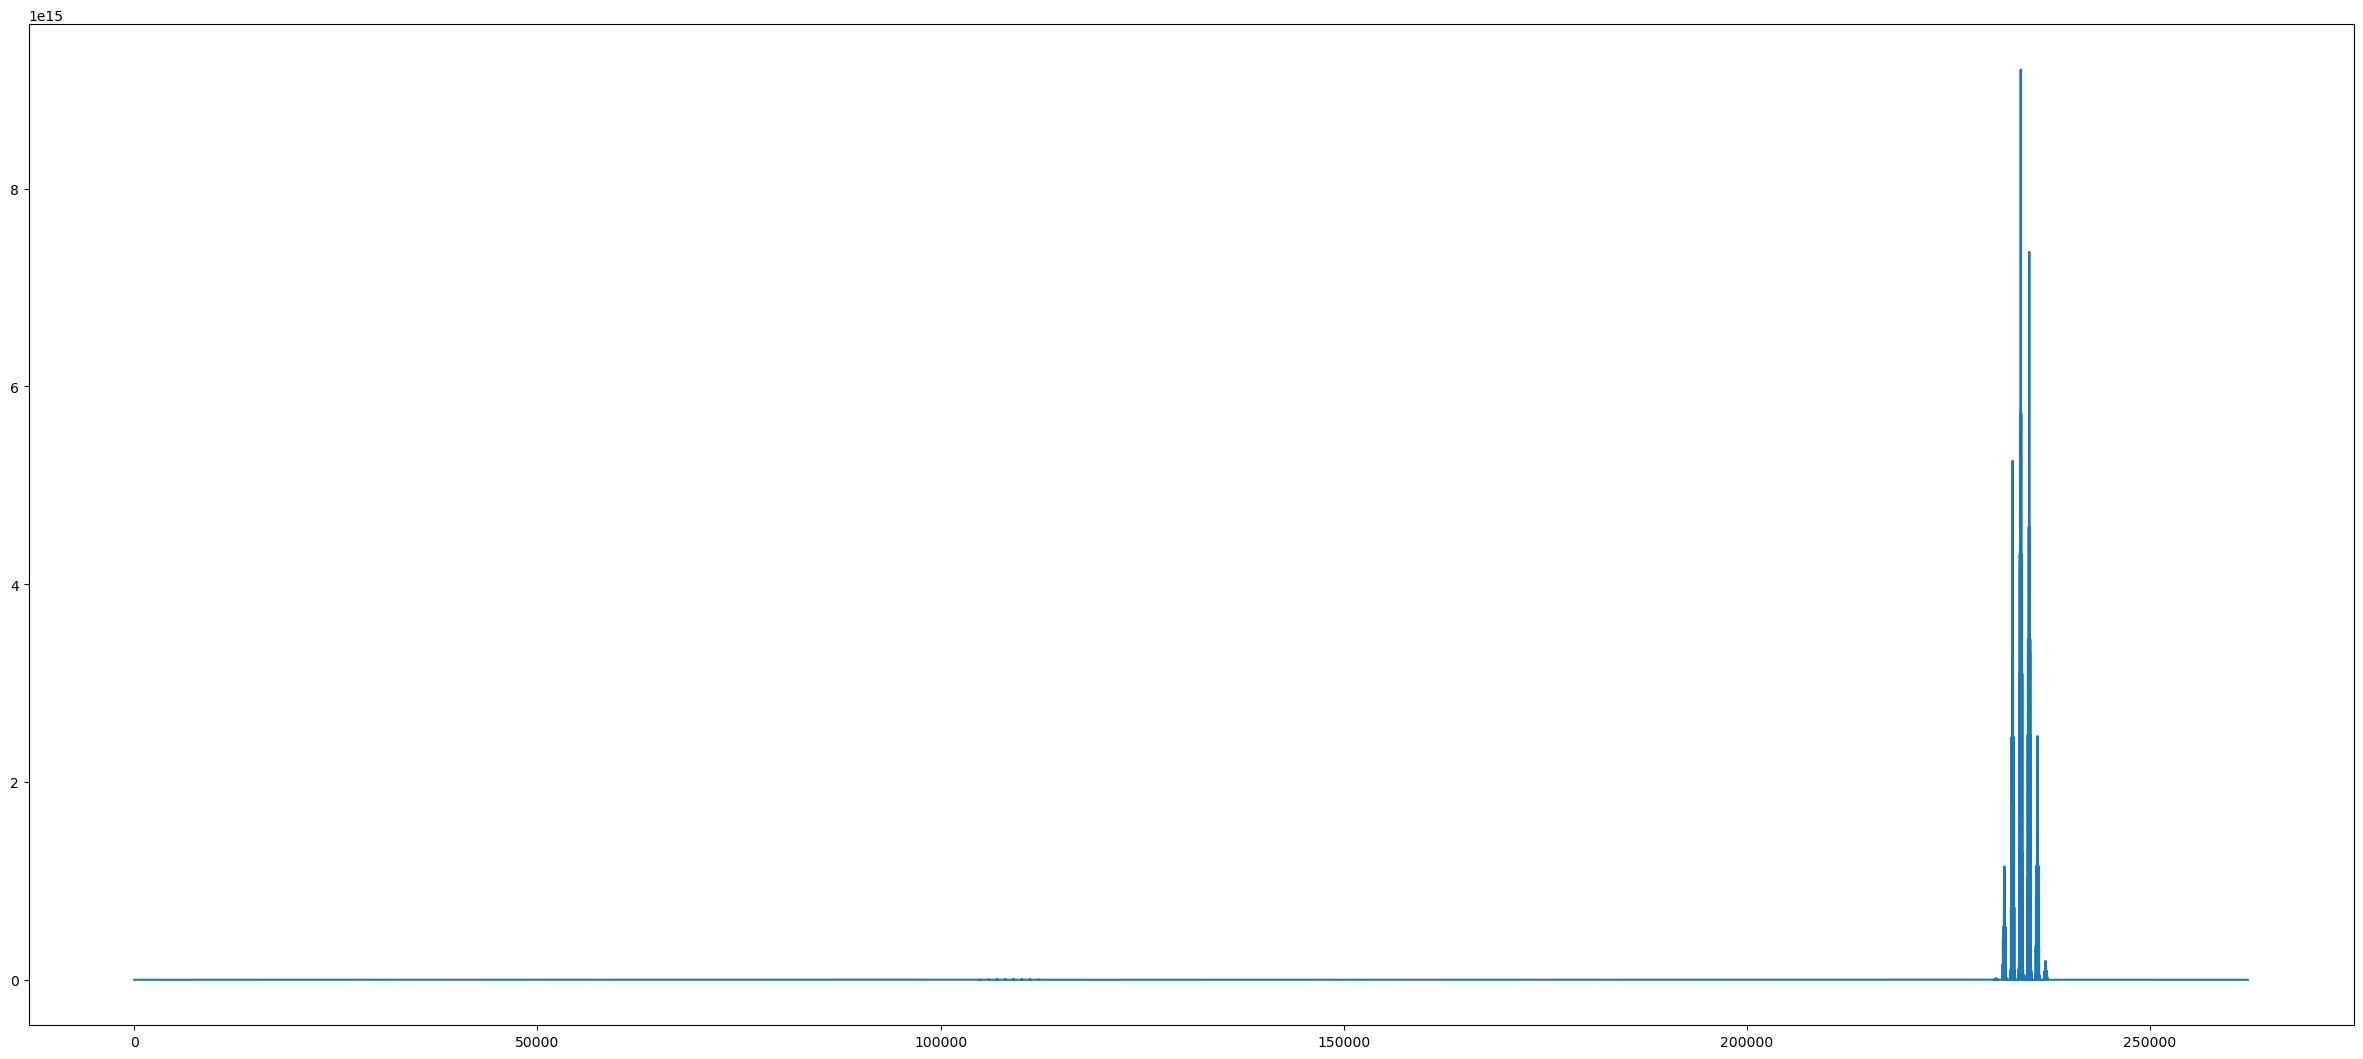

Index: 19


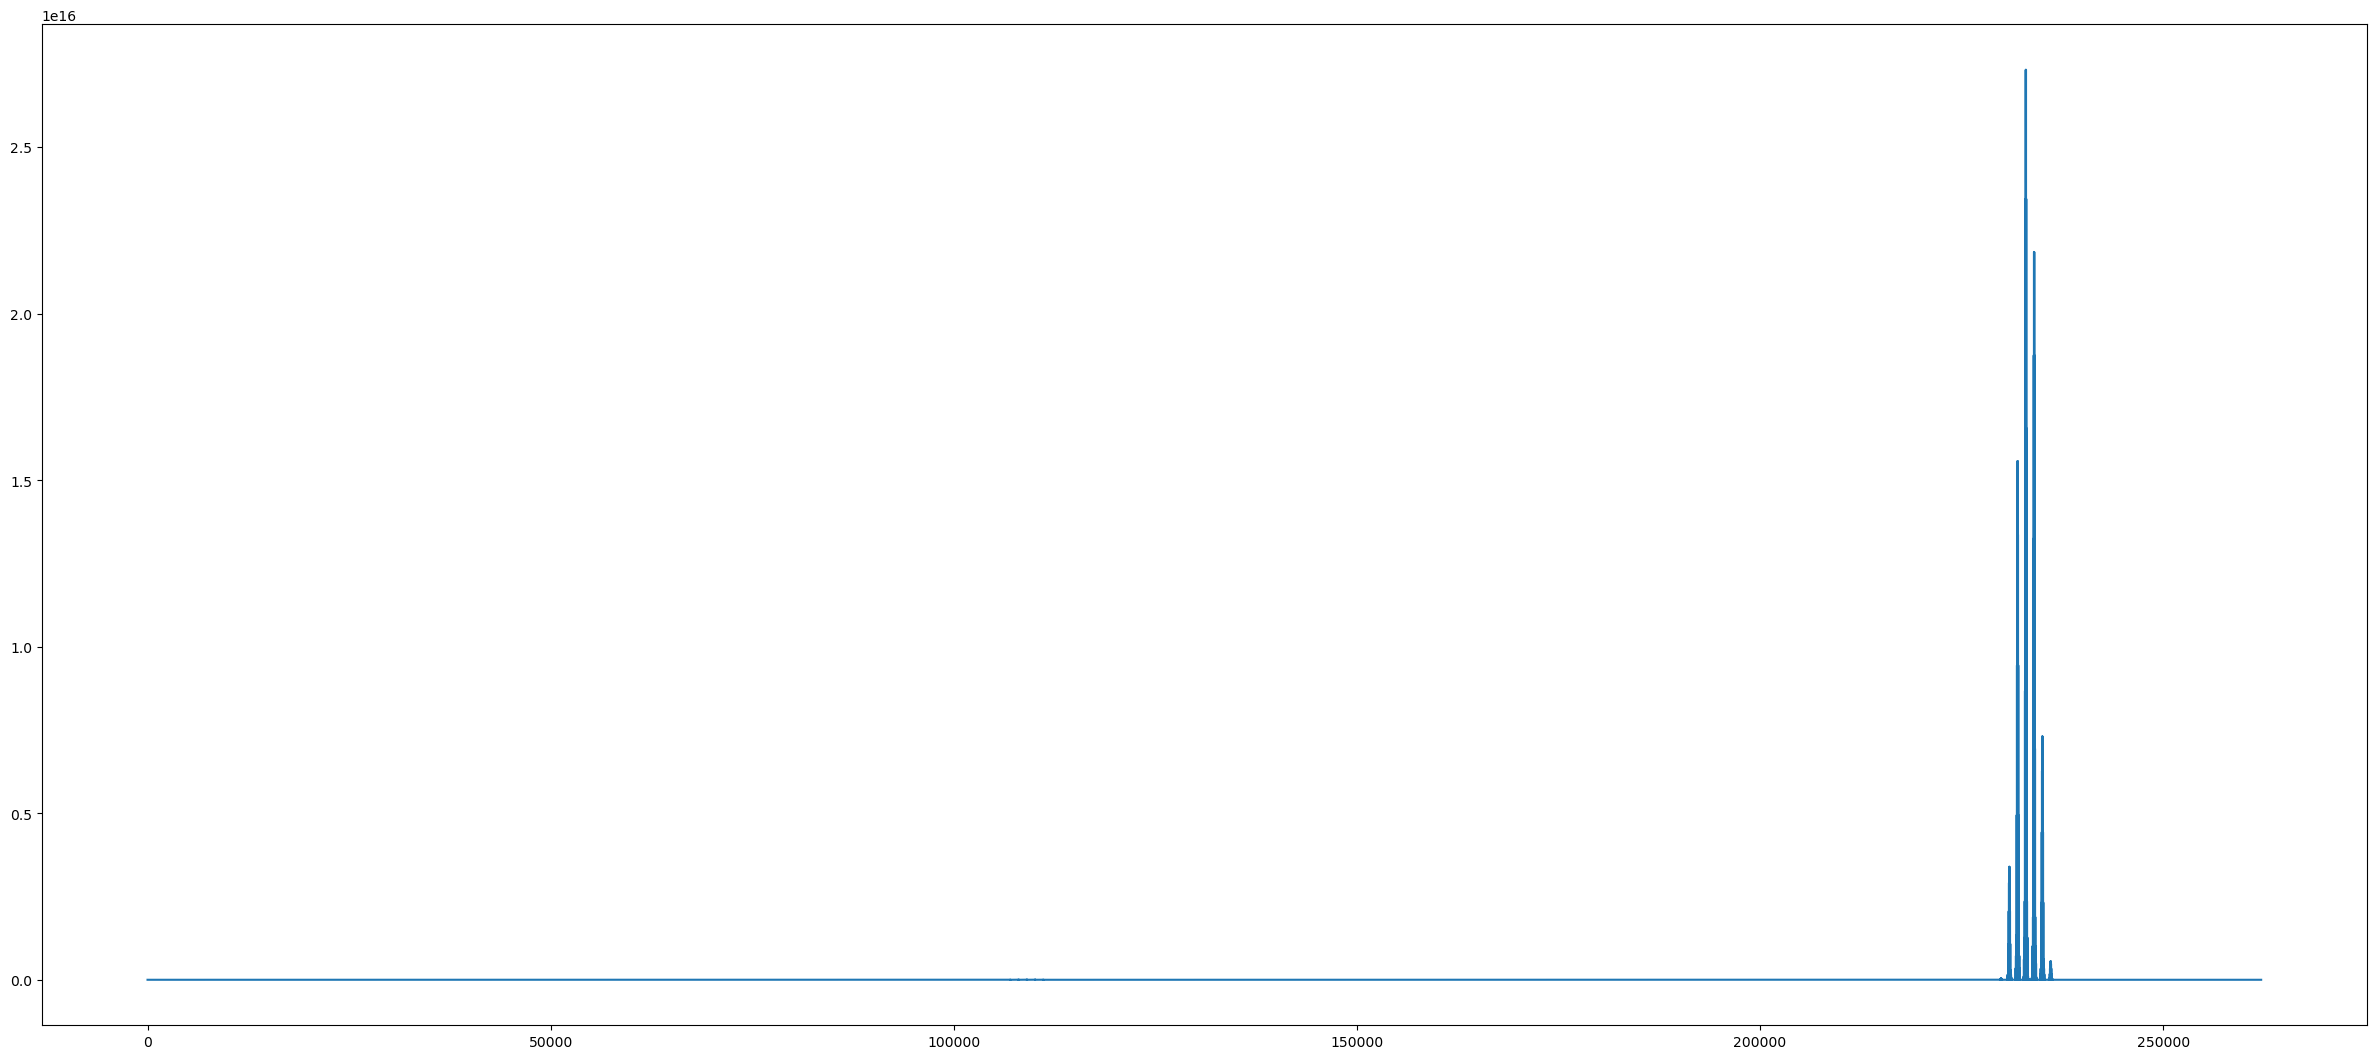

Index: 20


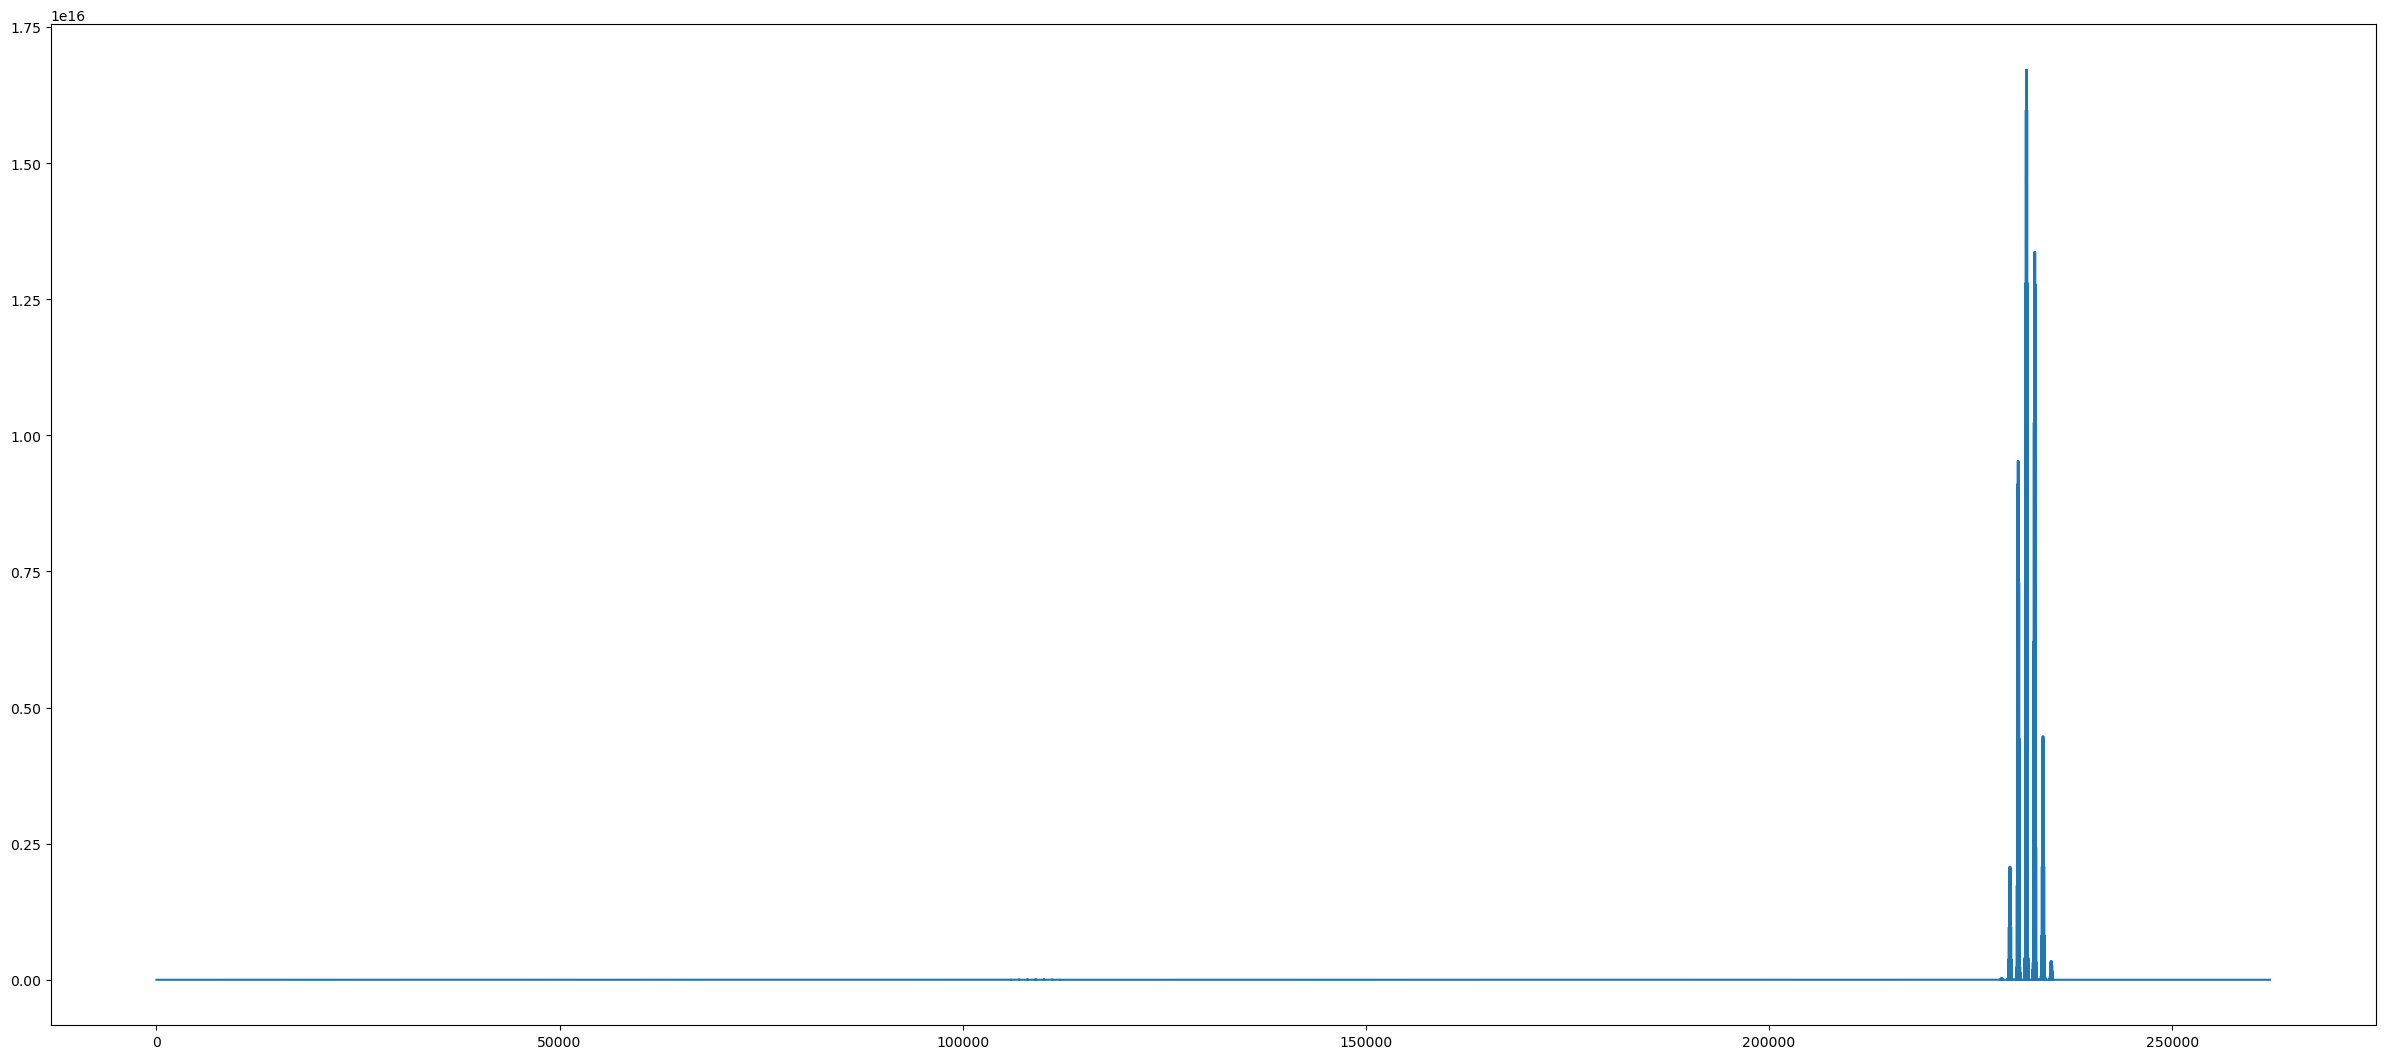

Index: 21


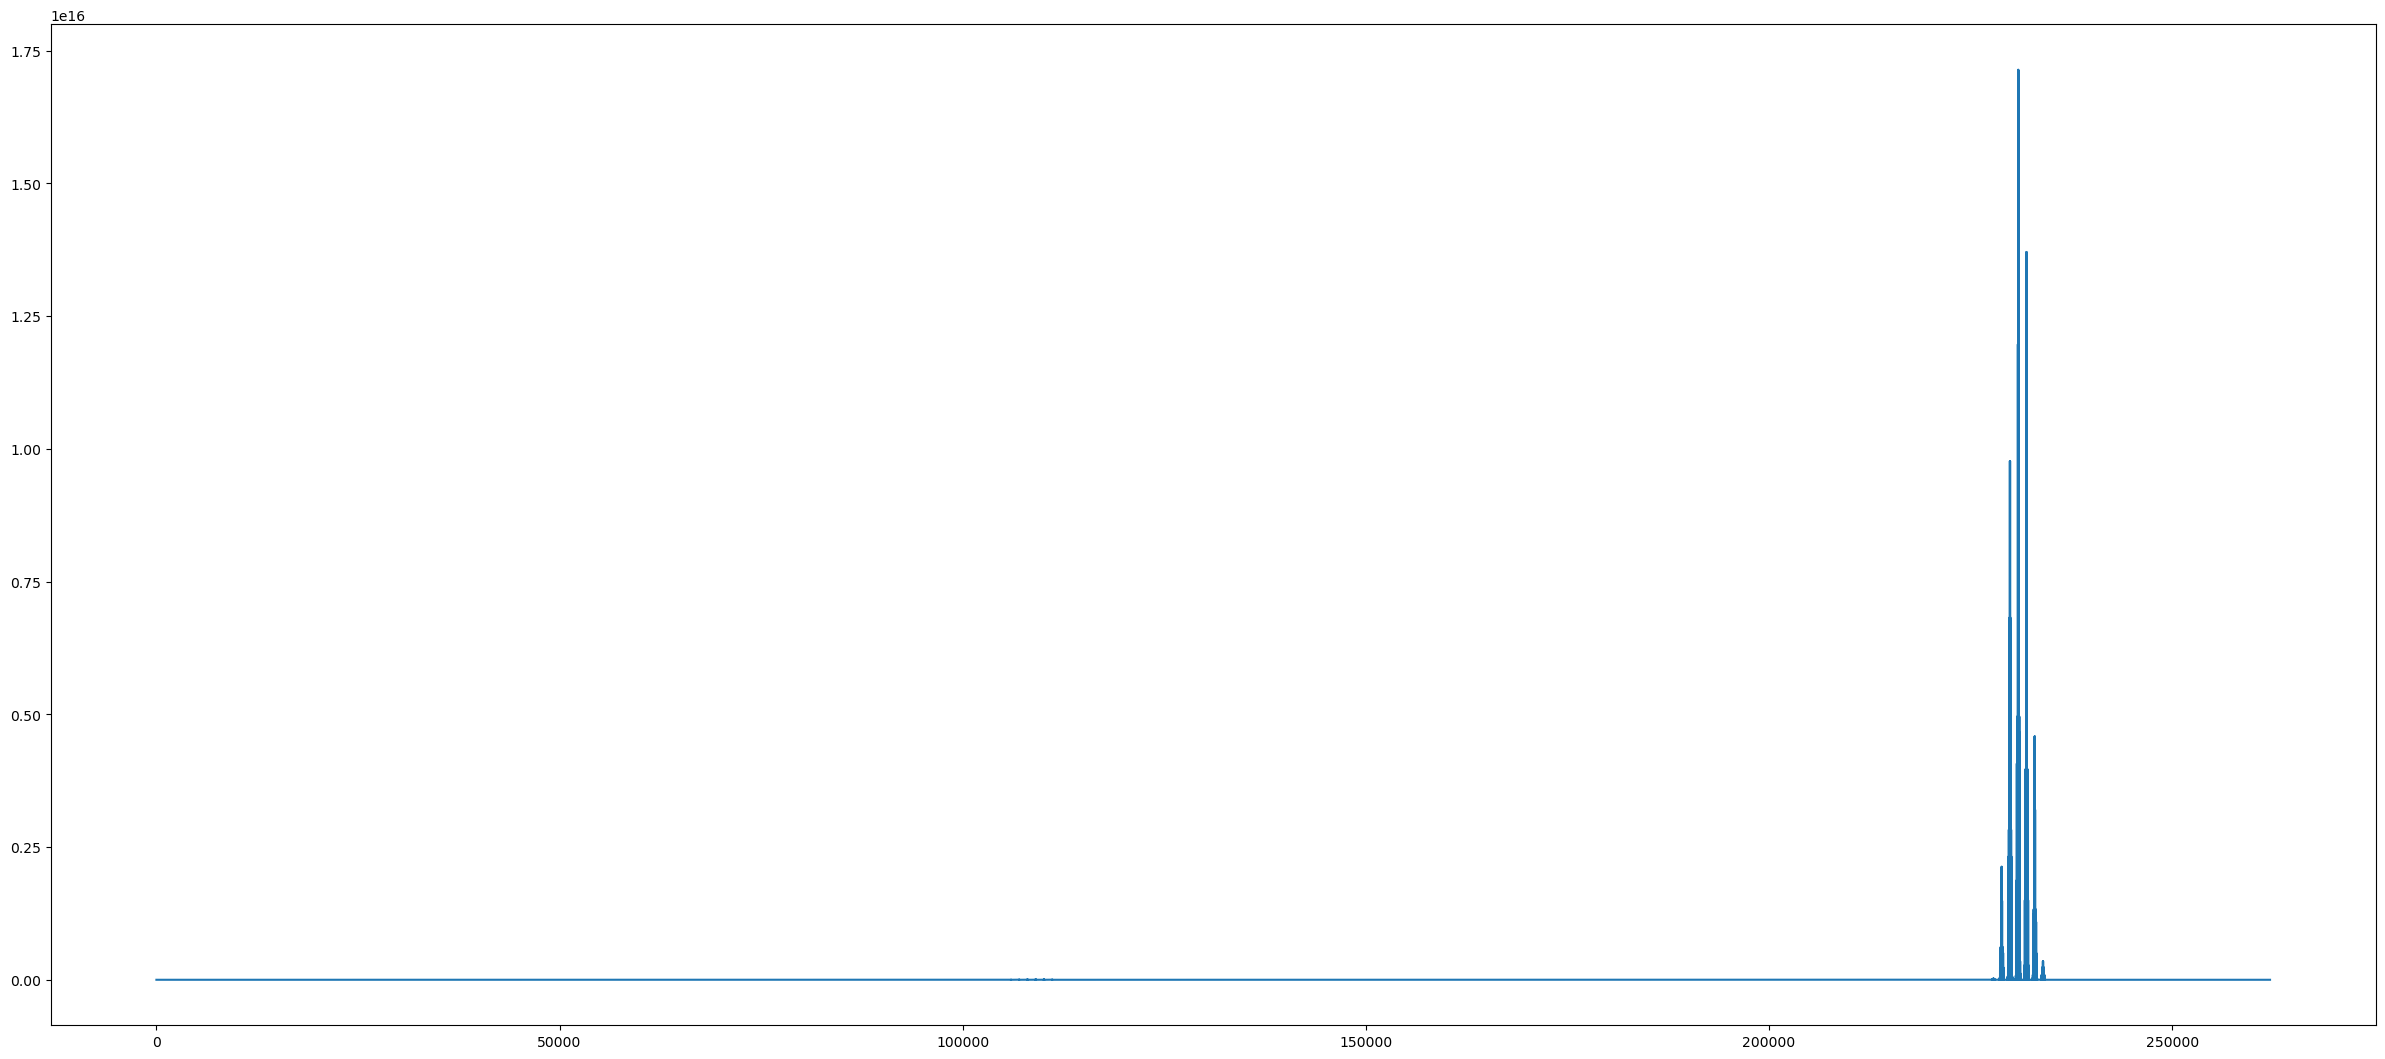

Index: 22


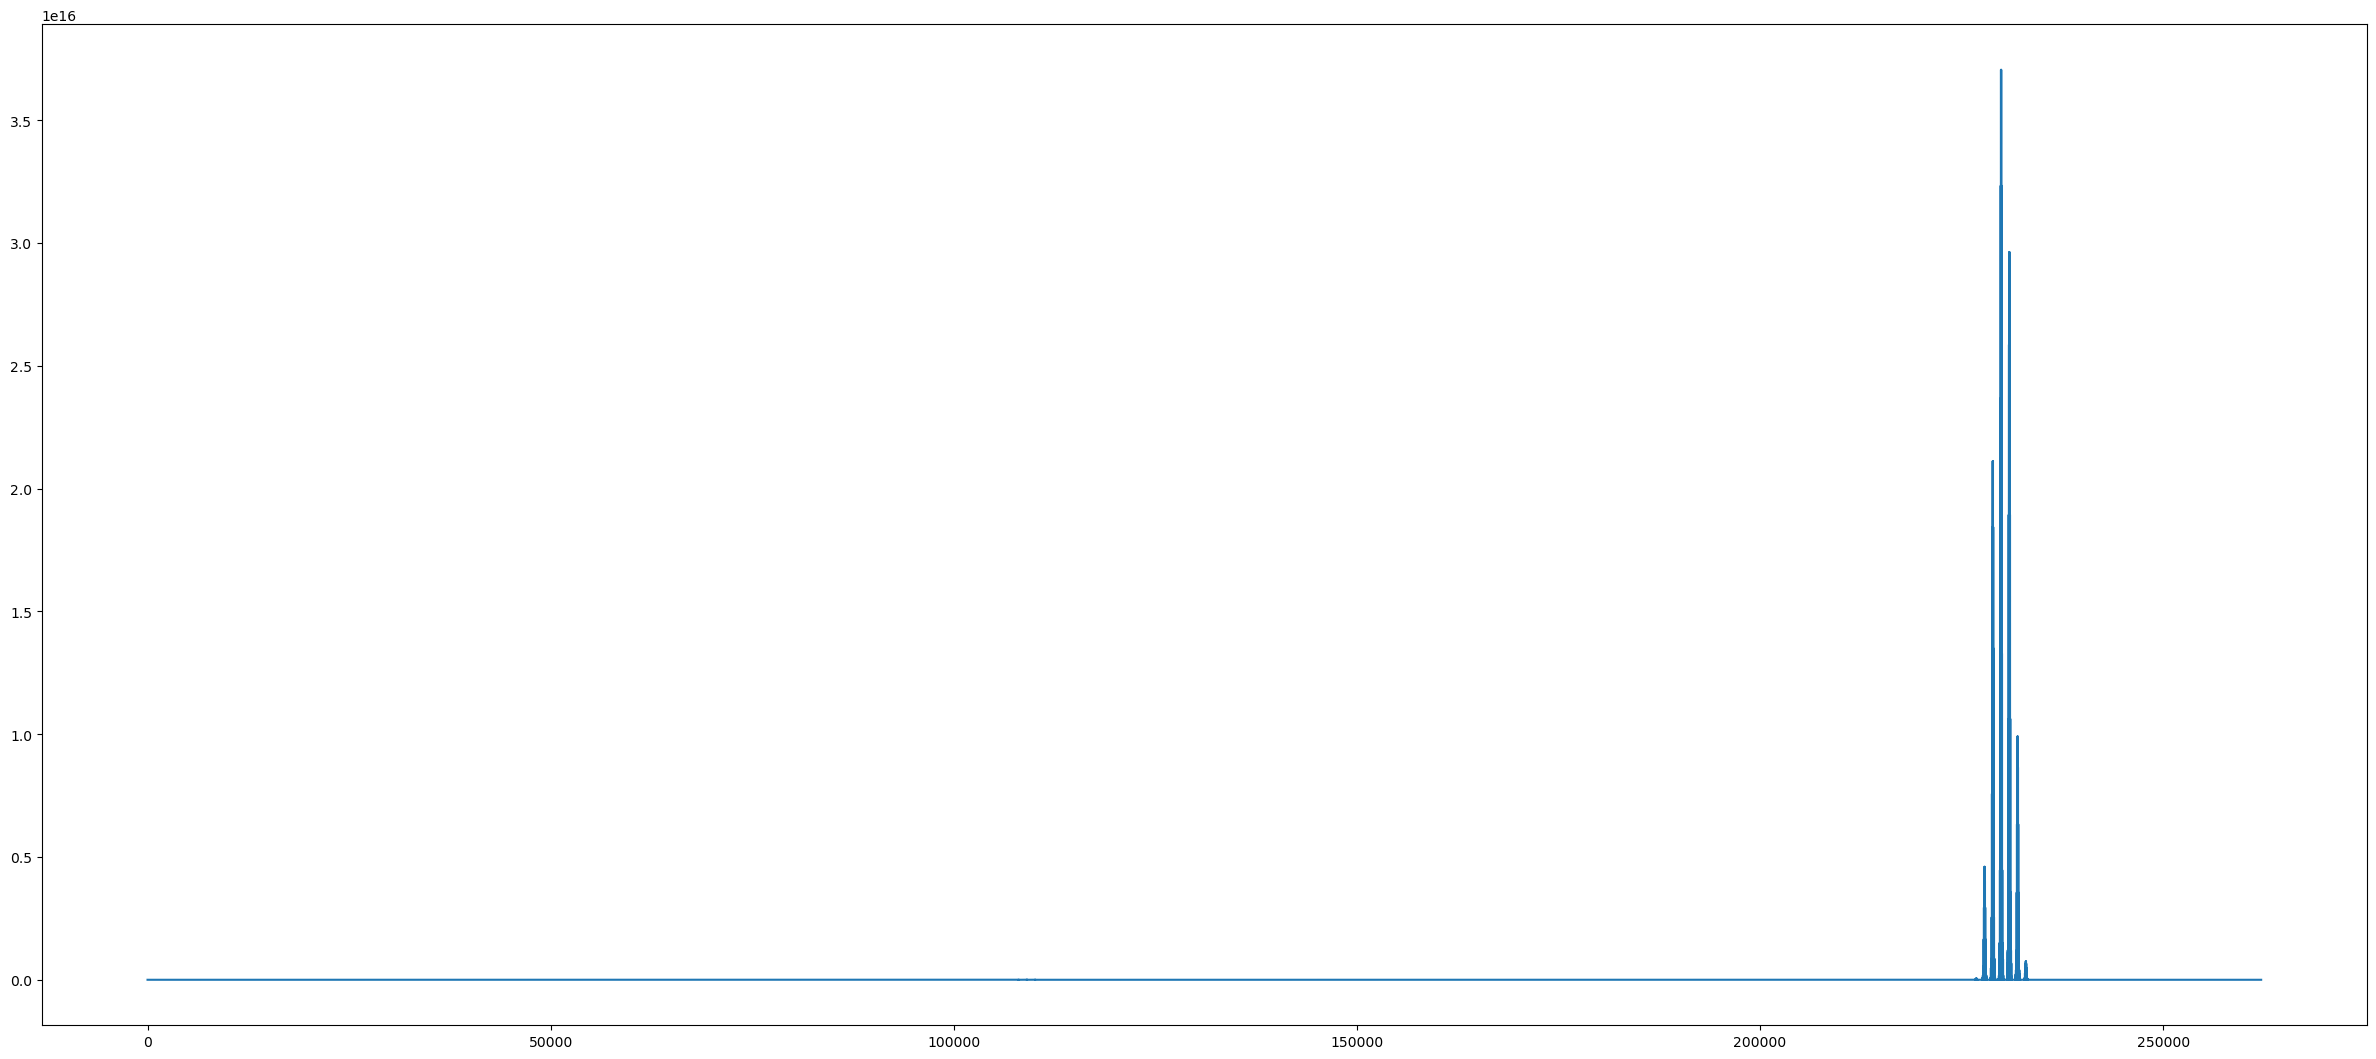

Index: 23


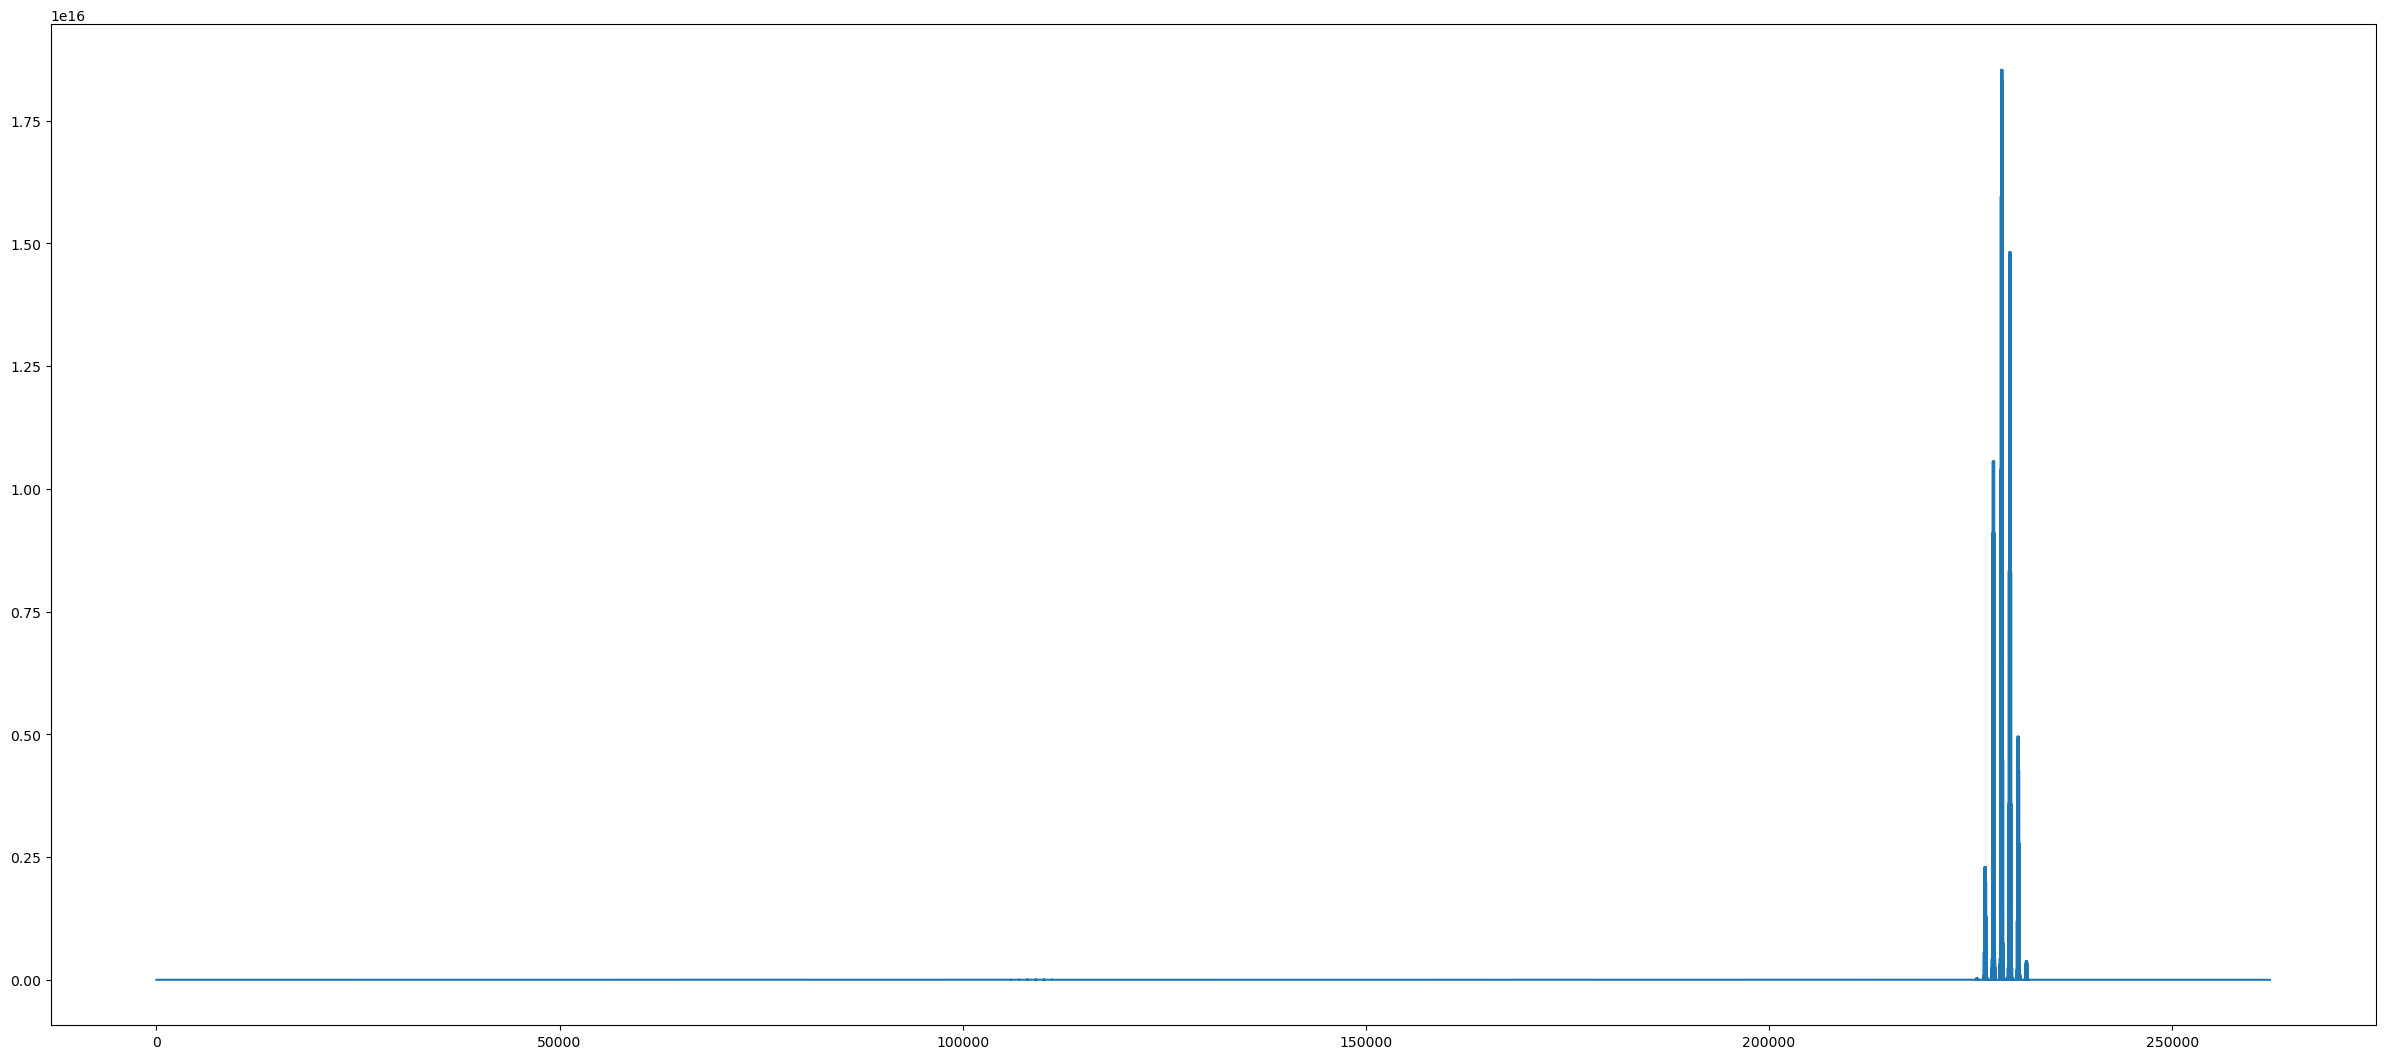

Index: 24


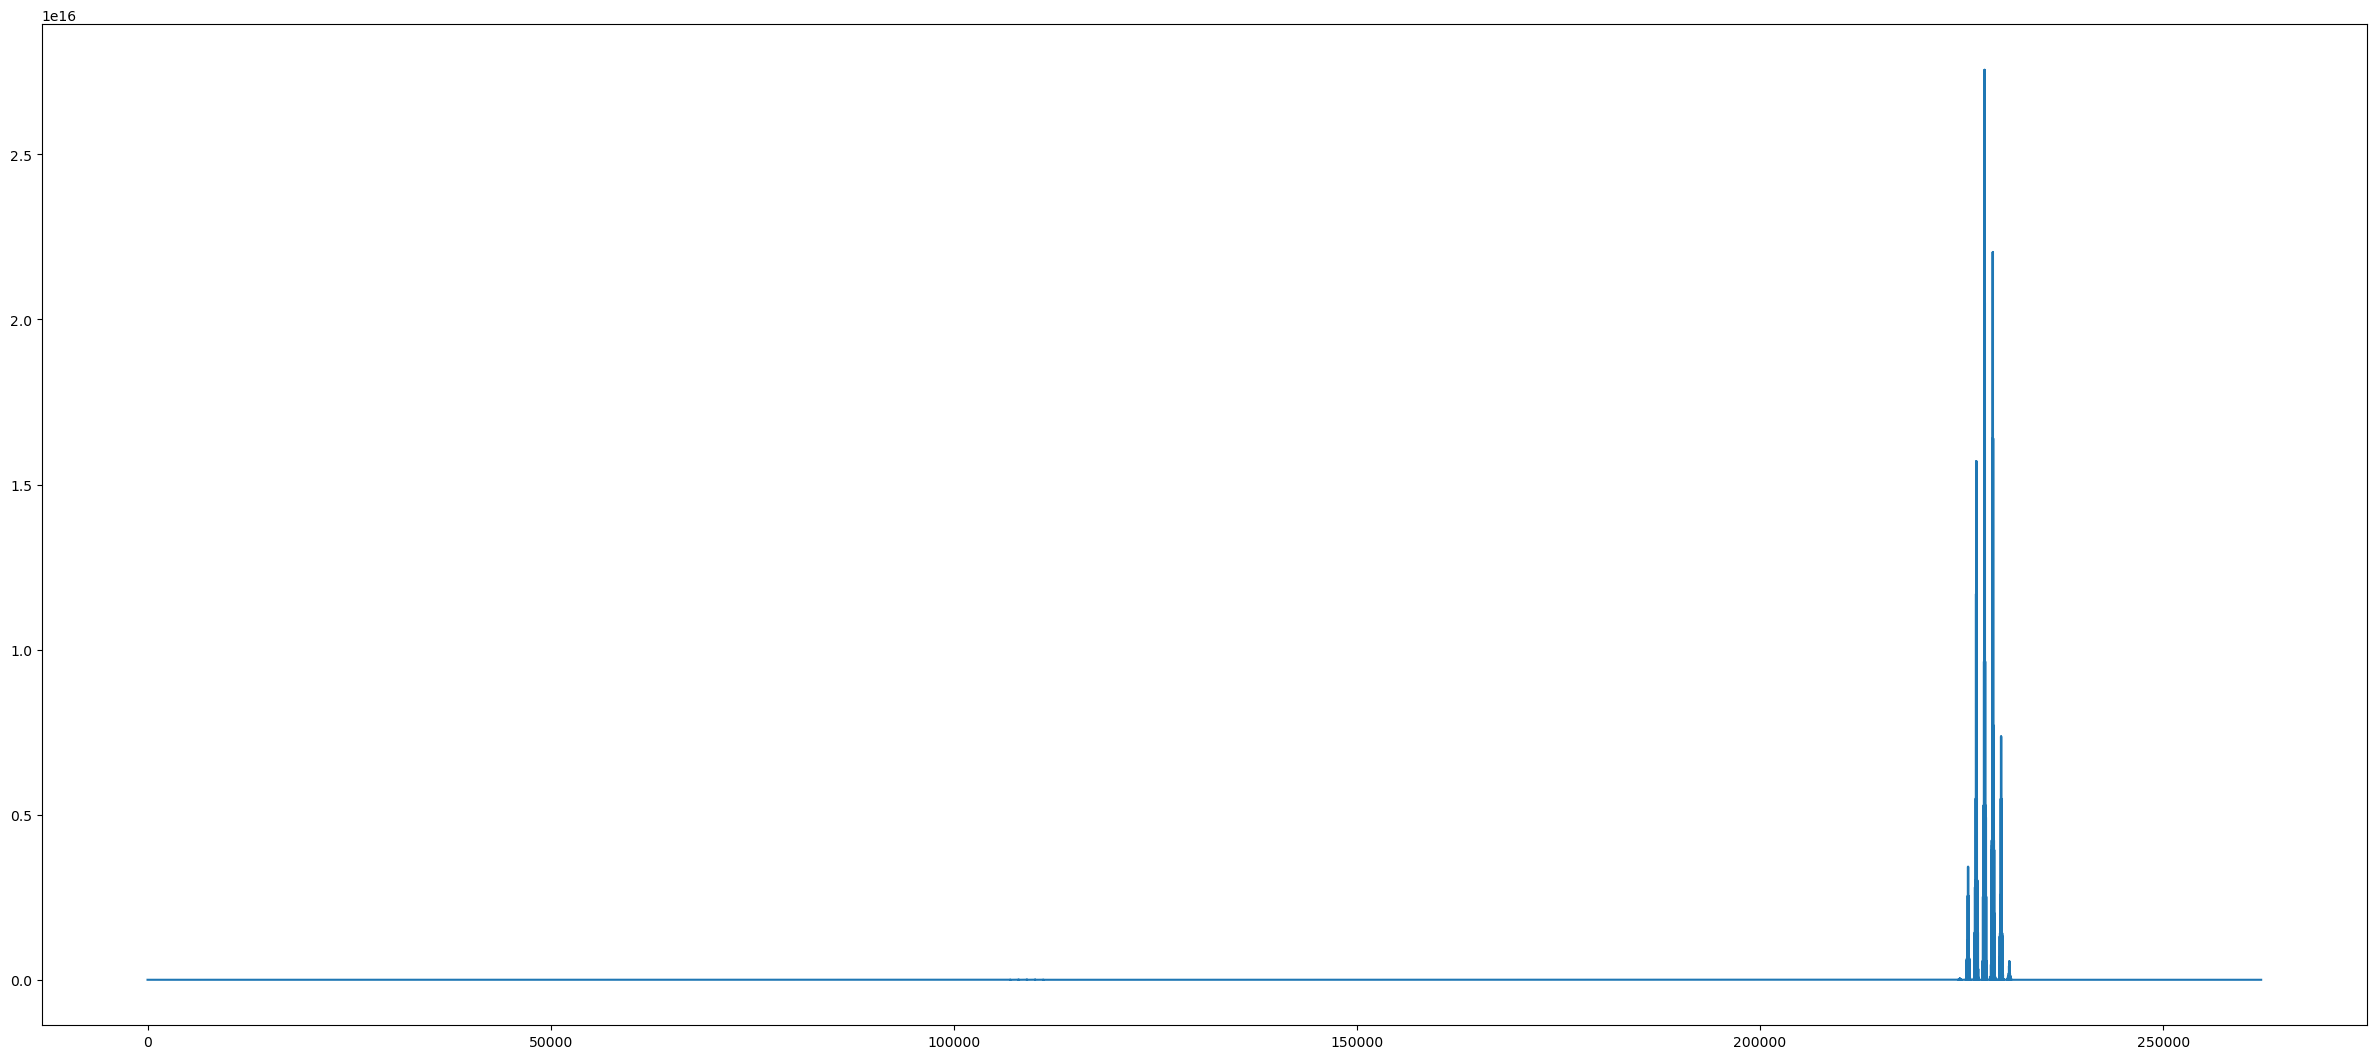

Index: 25


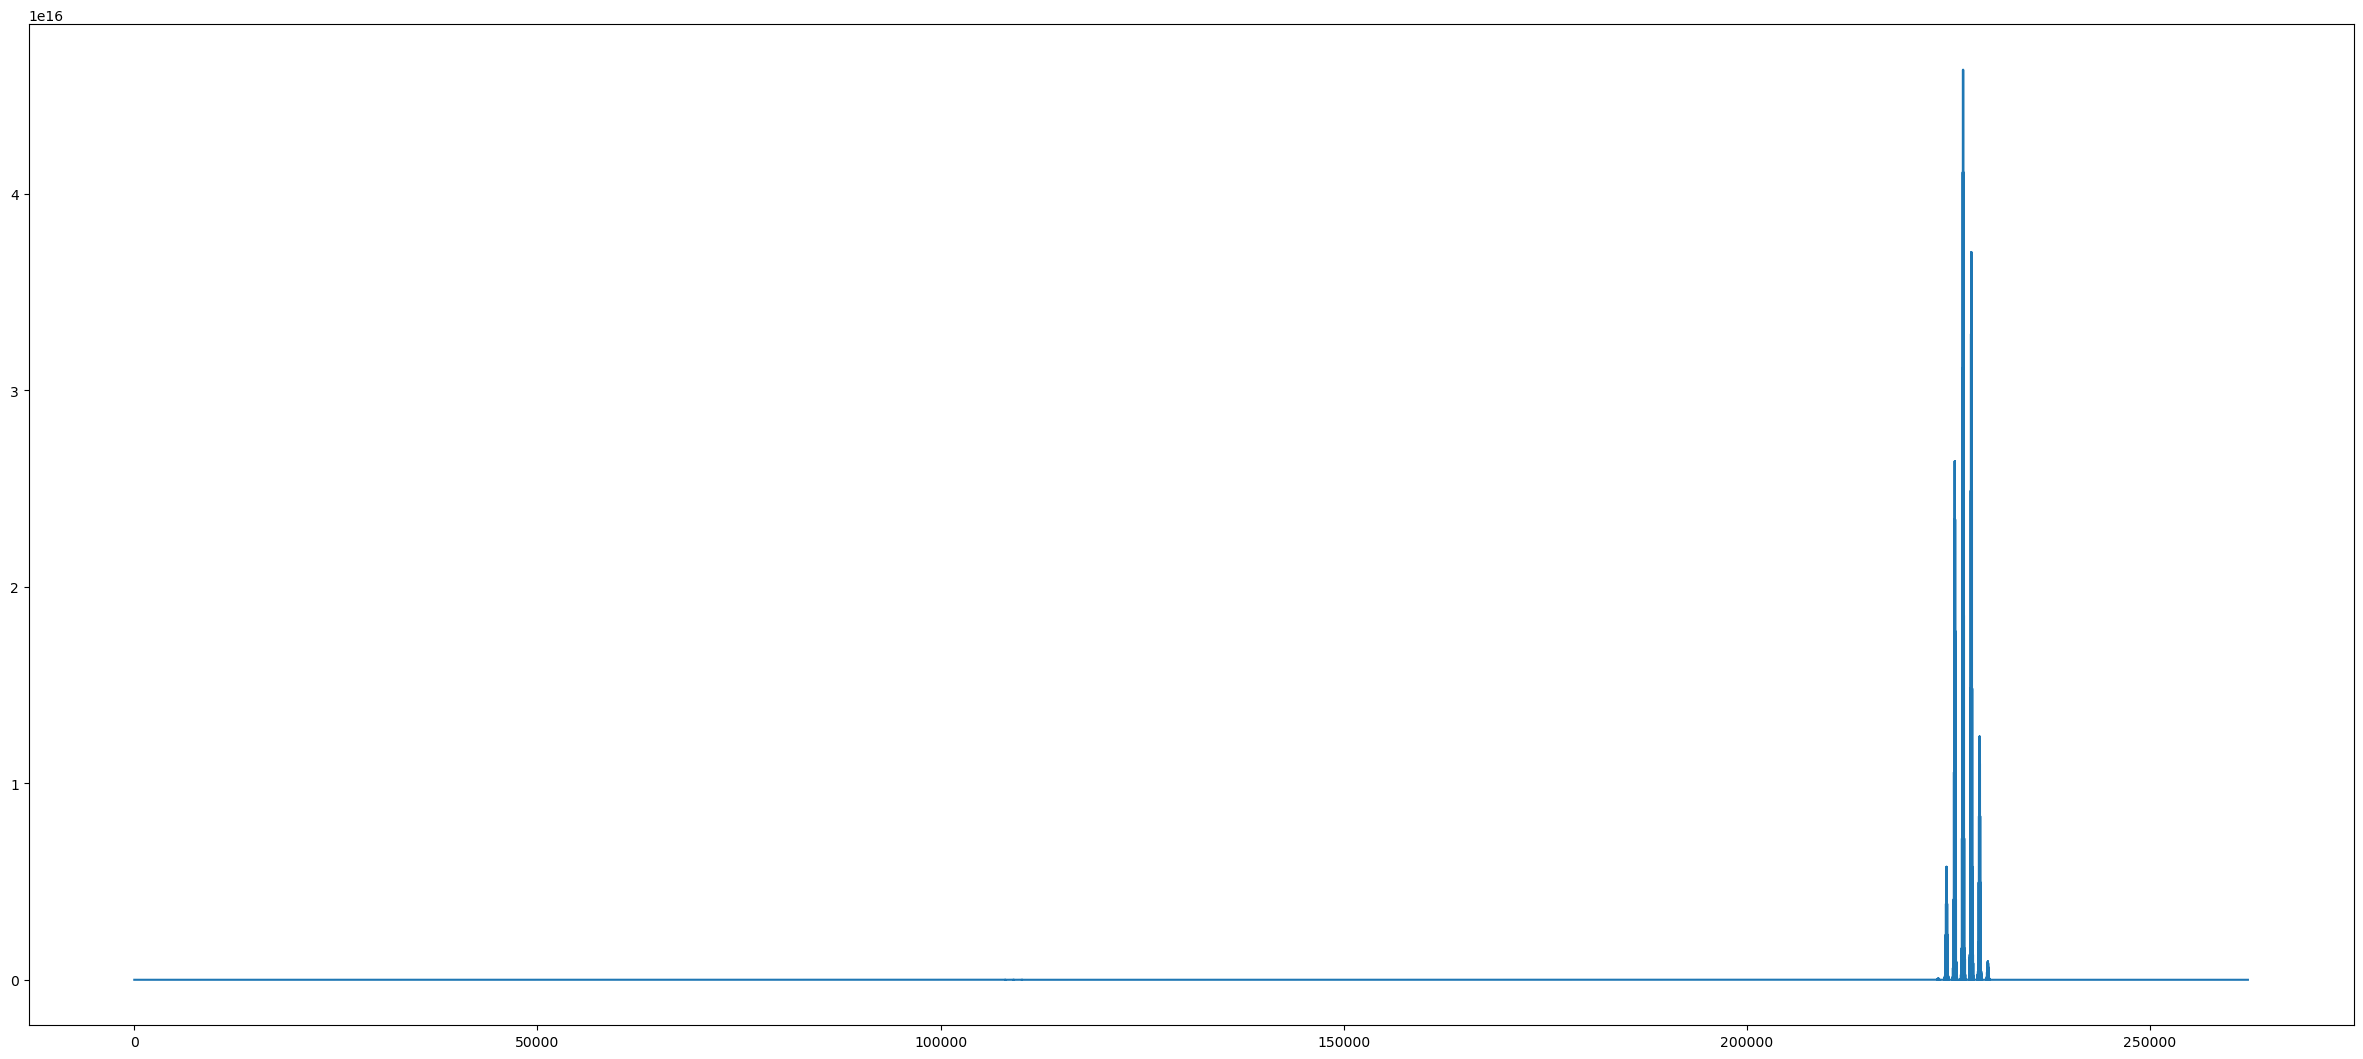

Index: 26


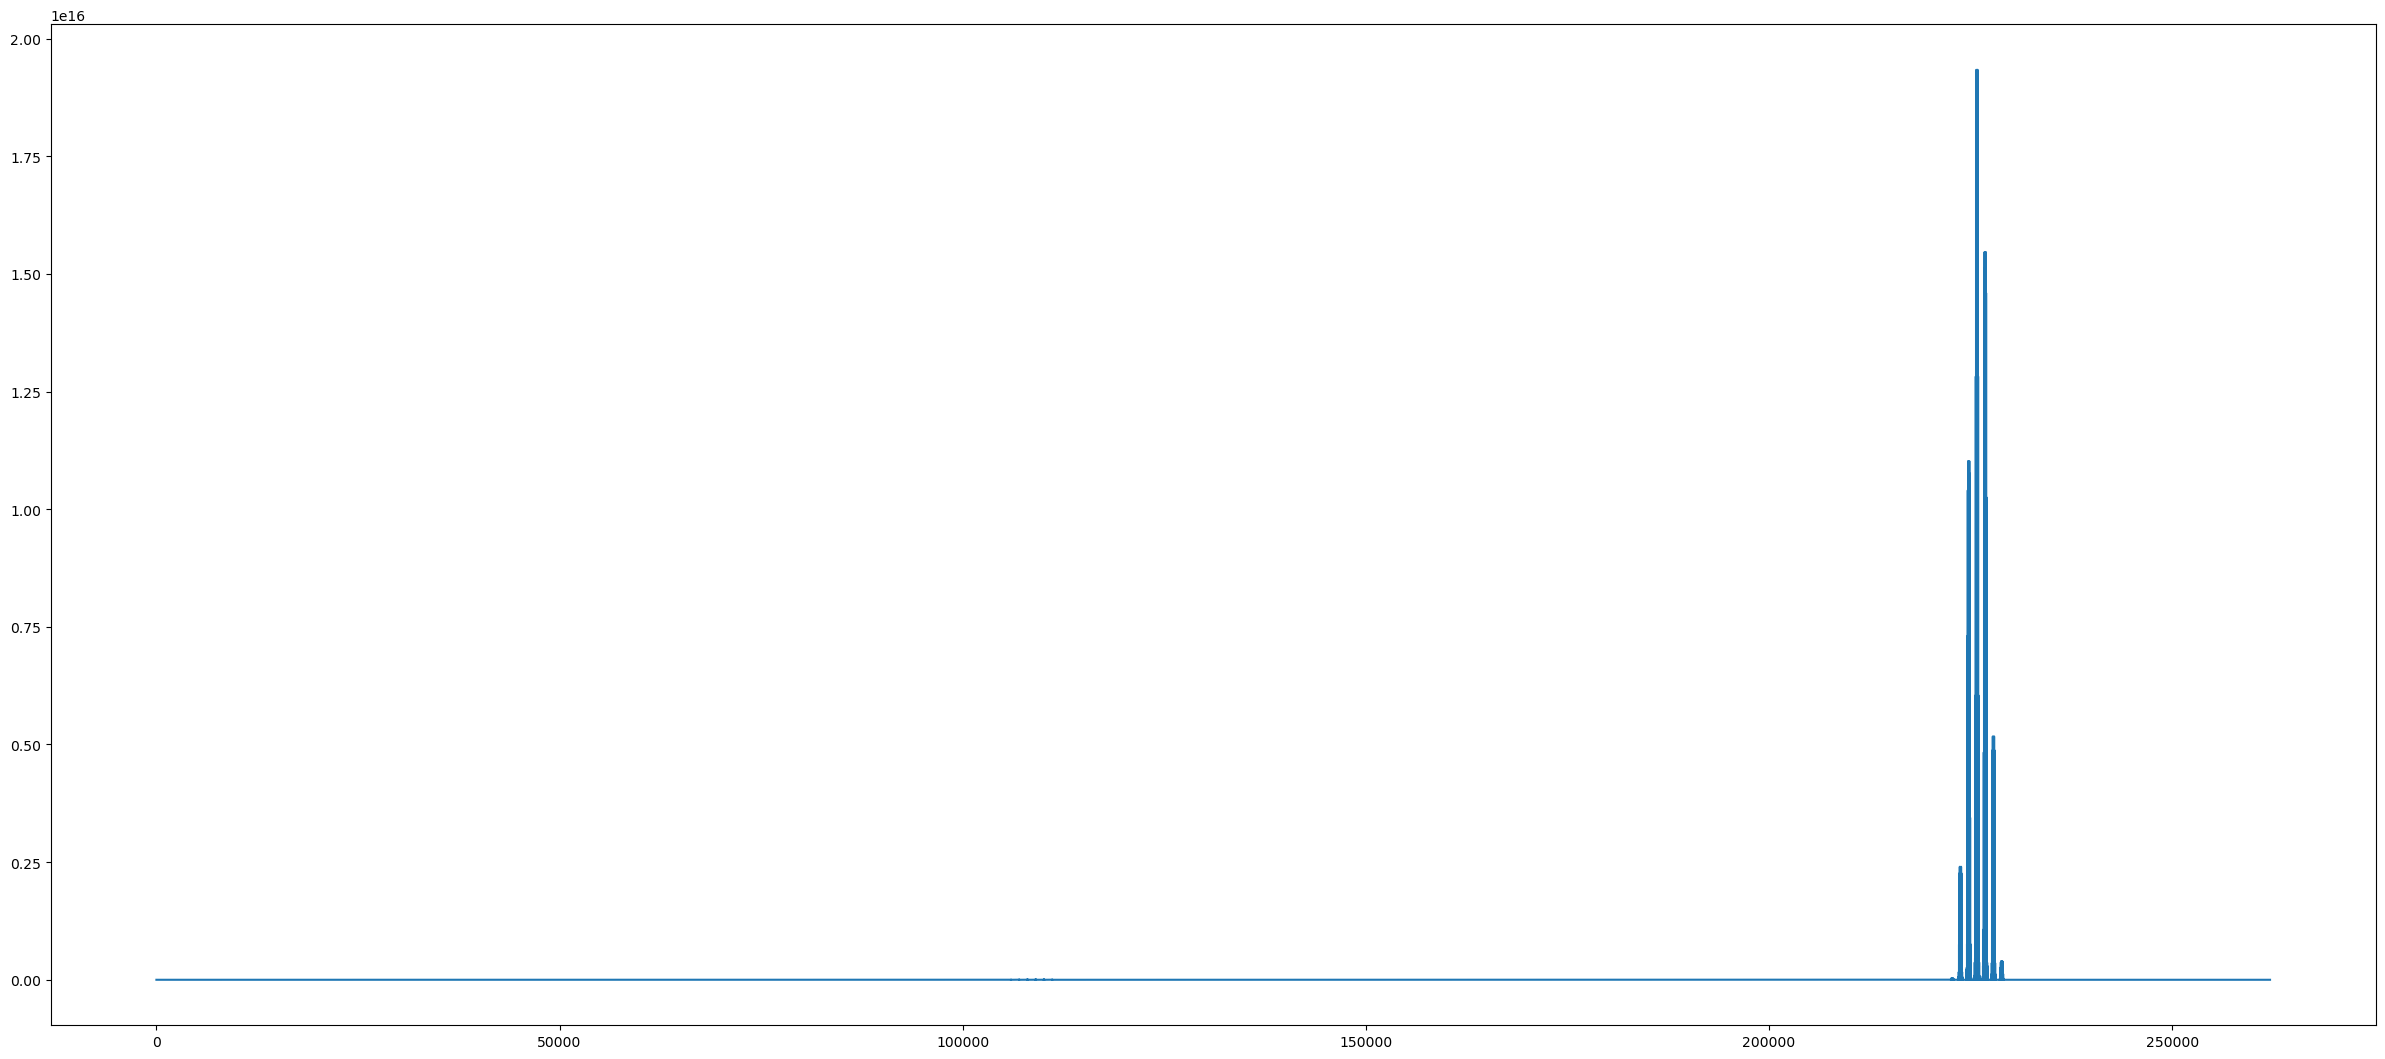

Index: 27


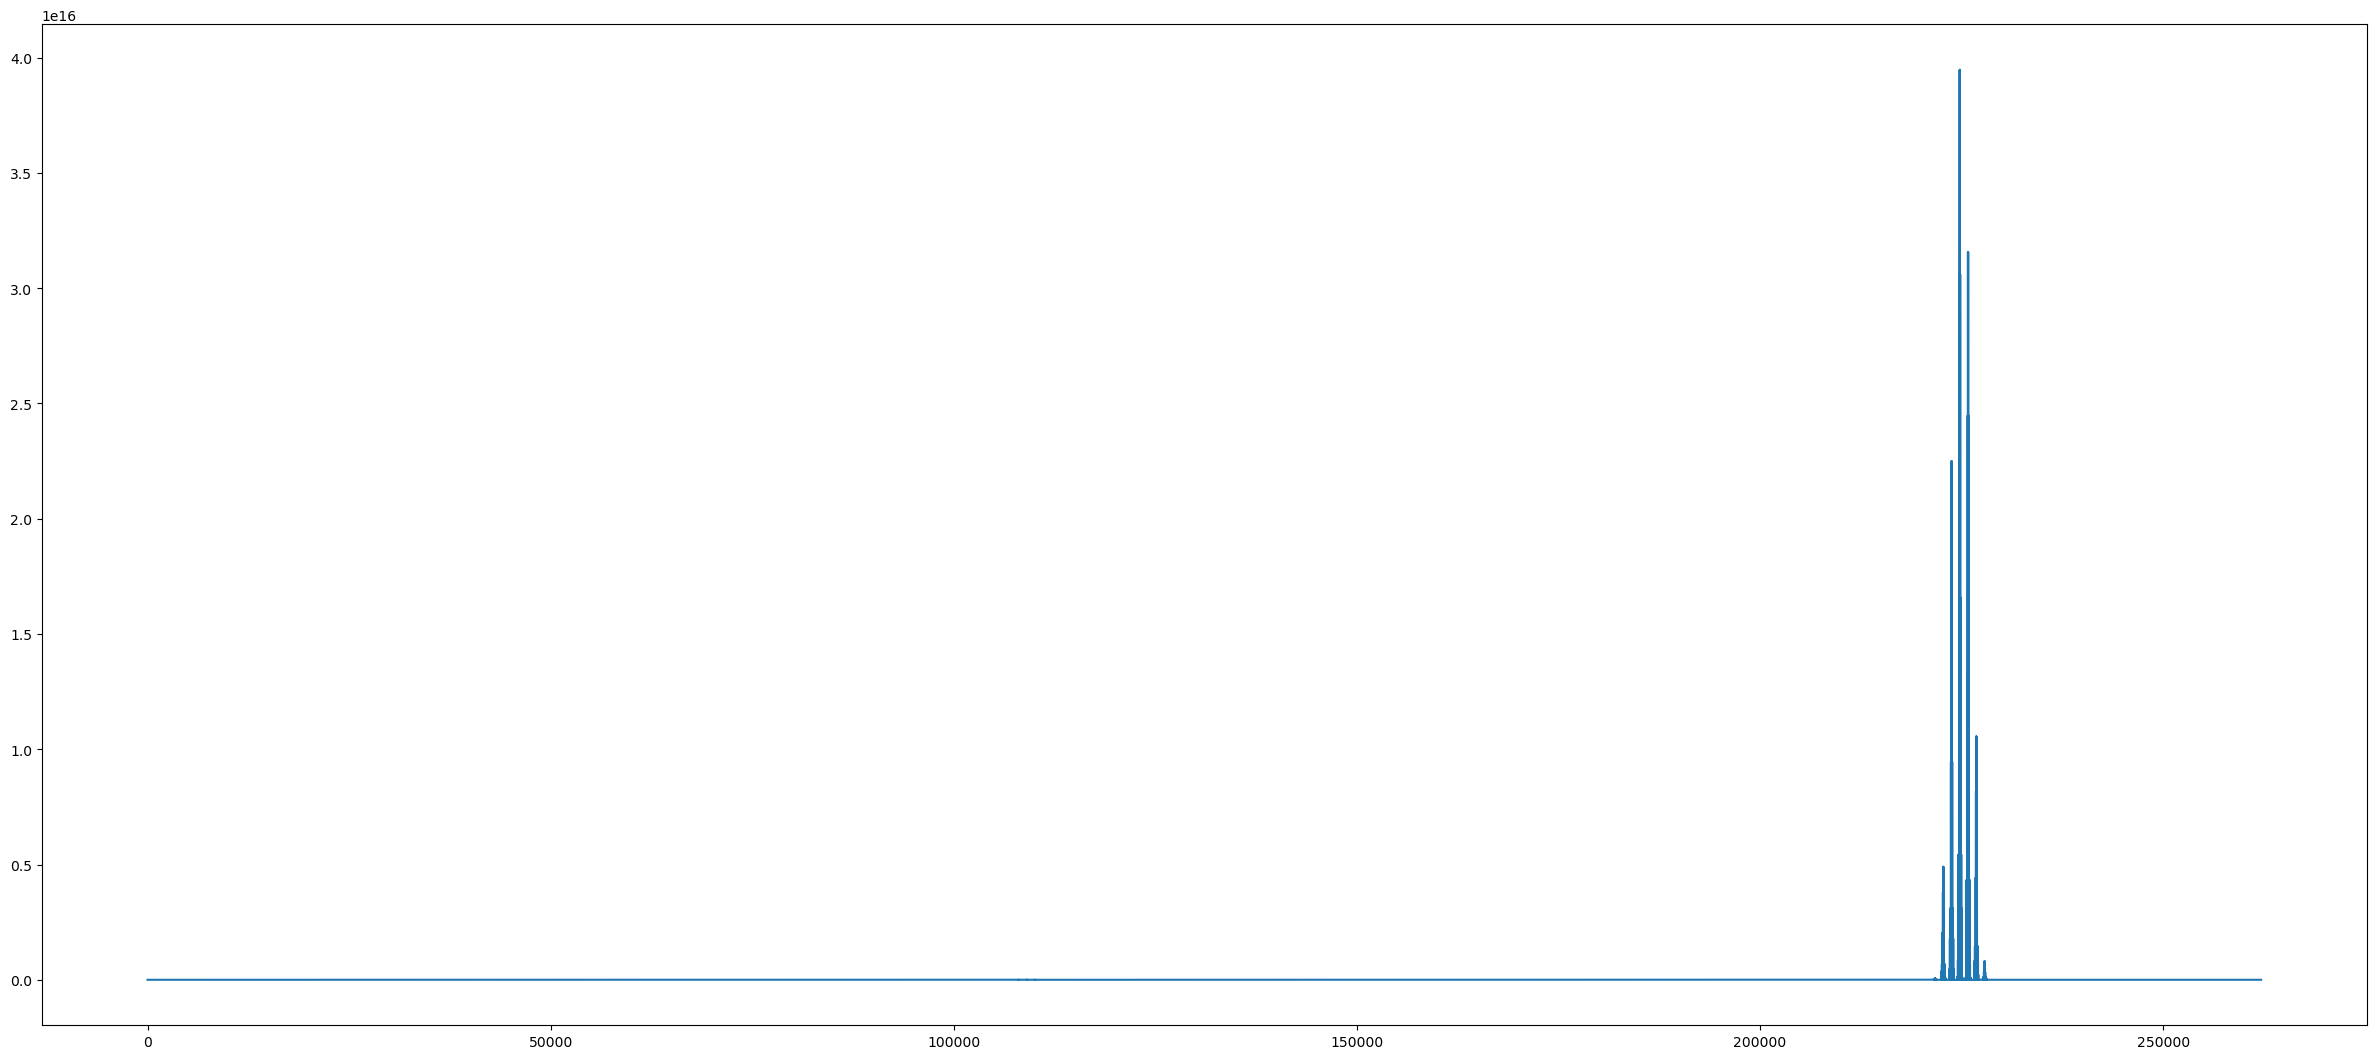

Index: 28


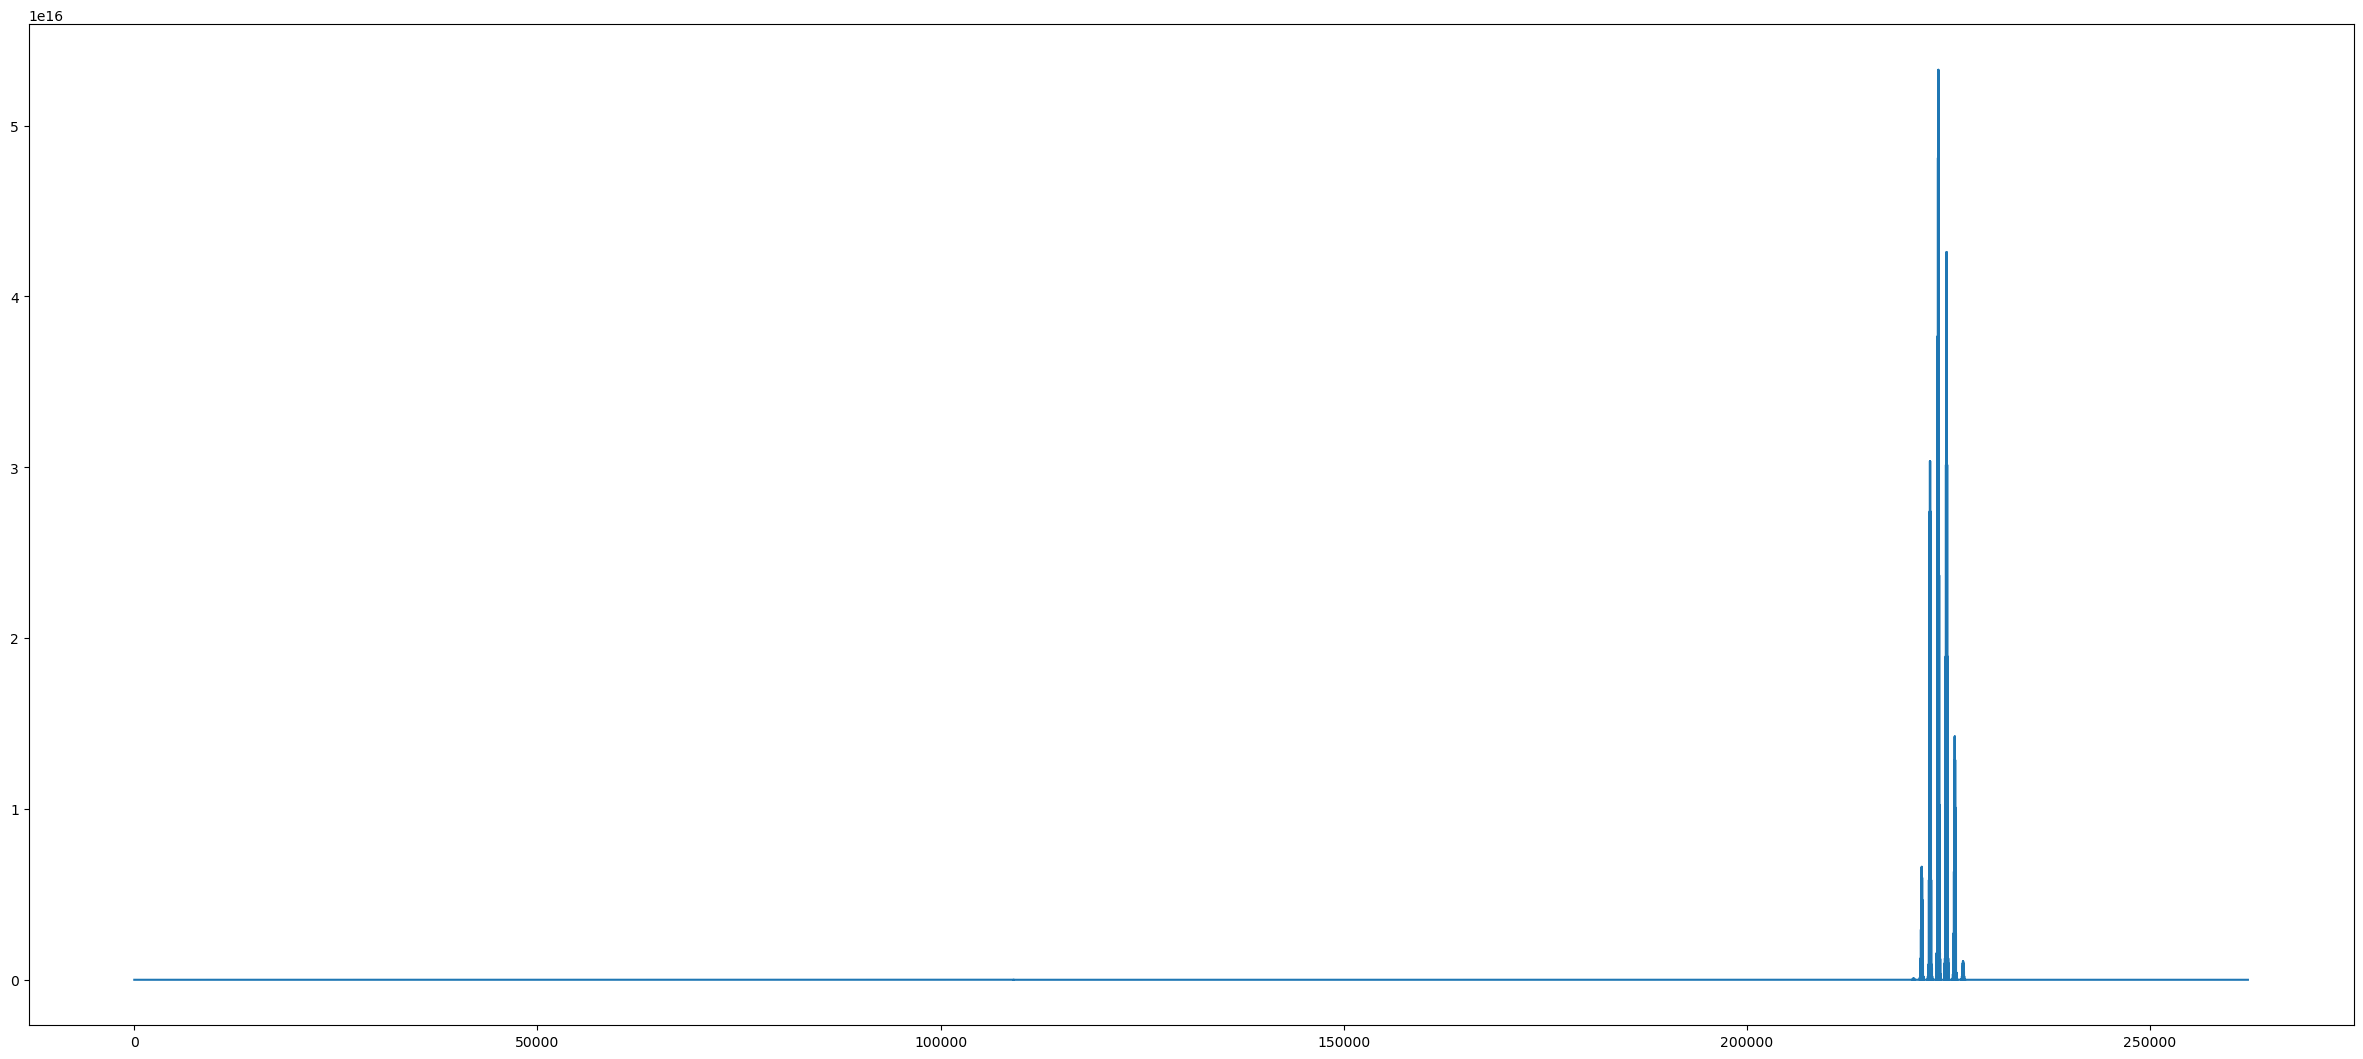

Index: 29


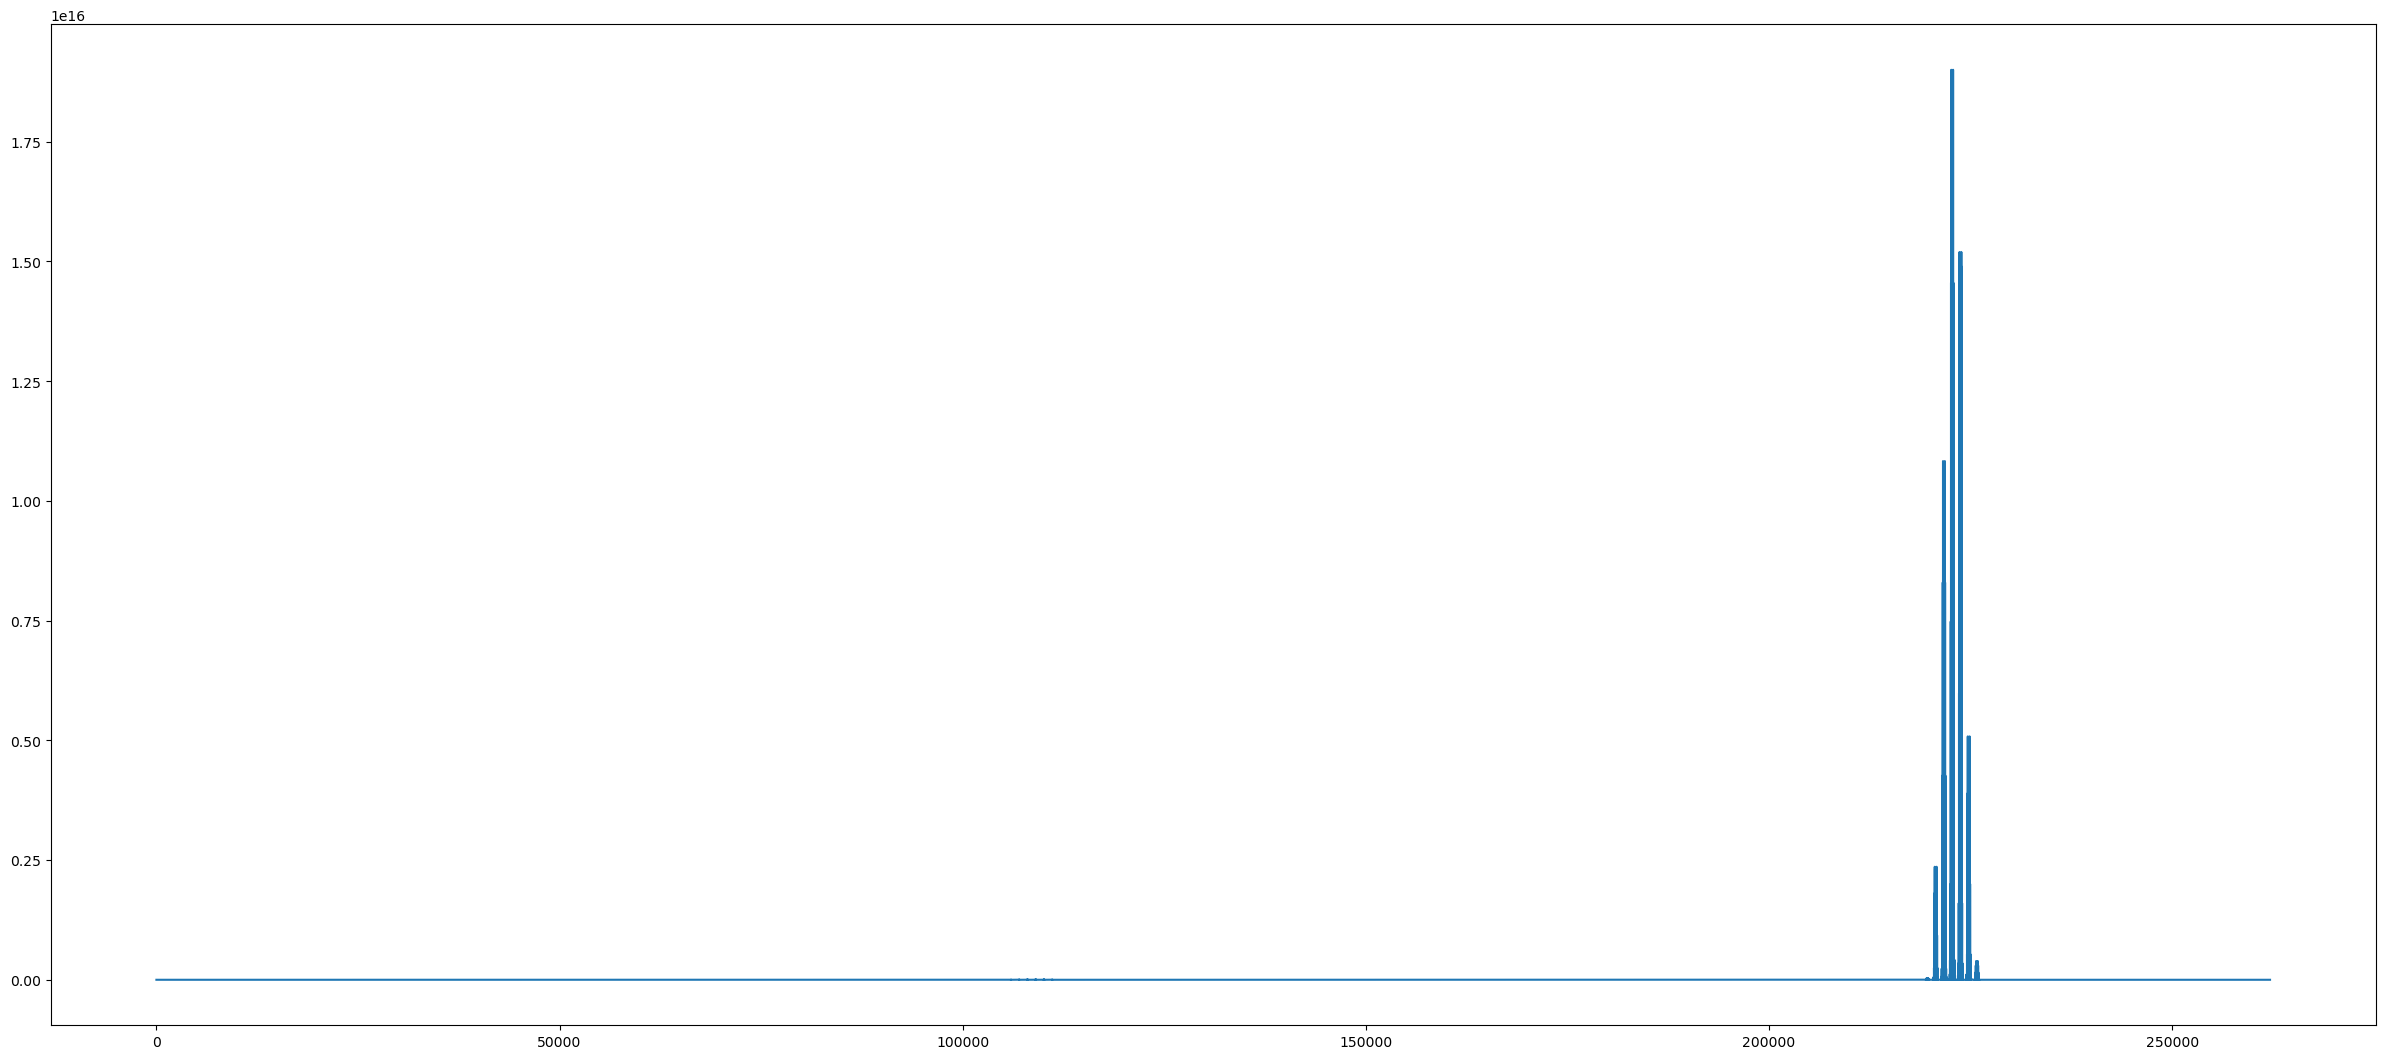

Index: 30


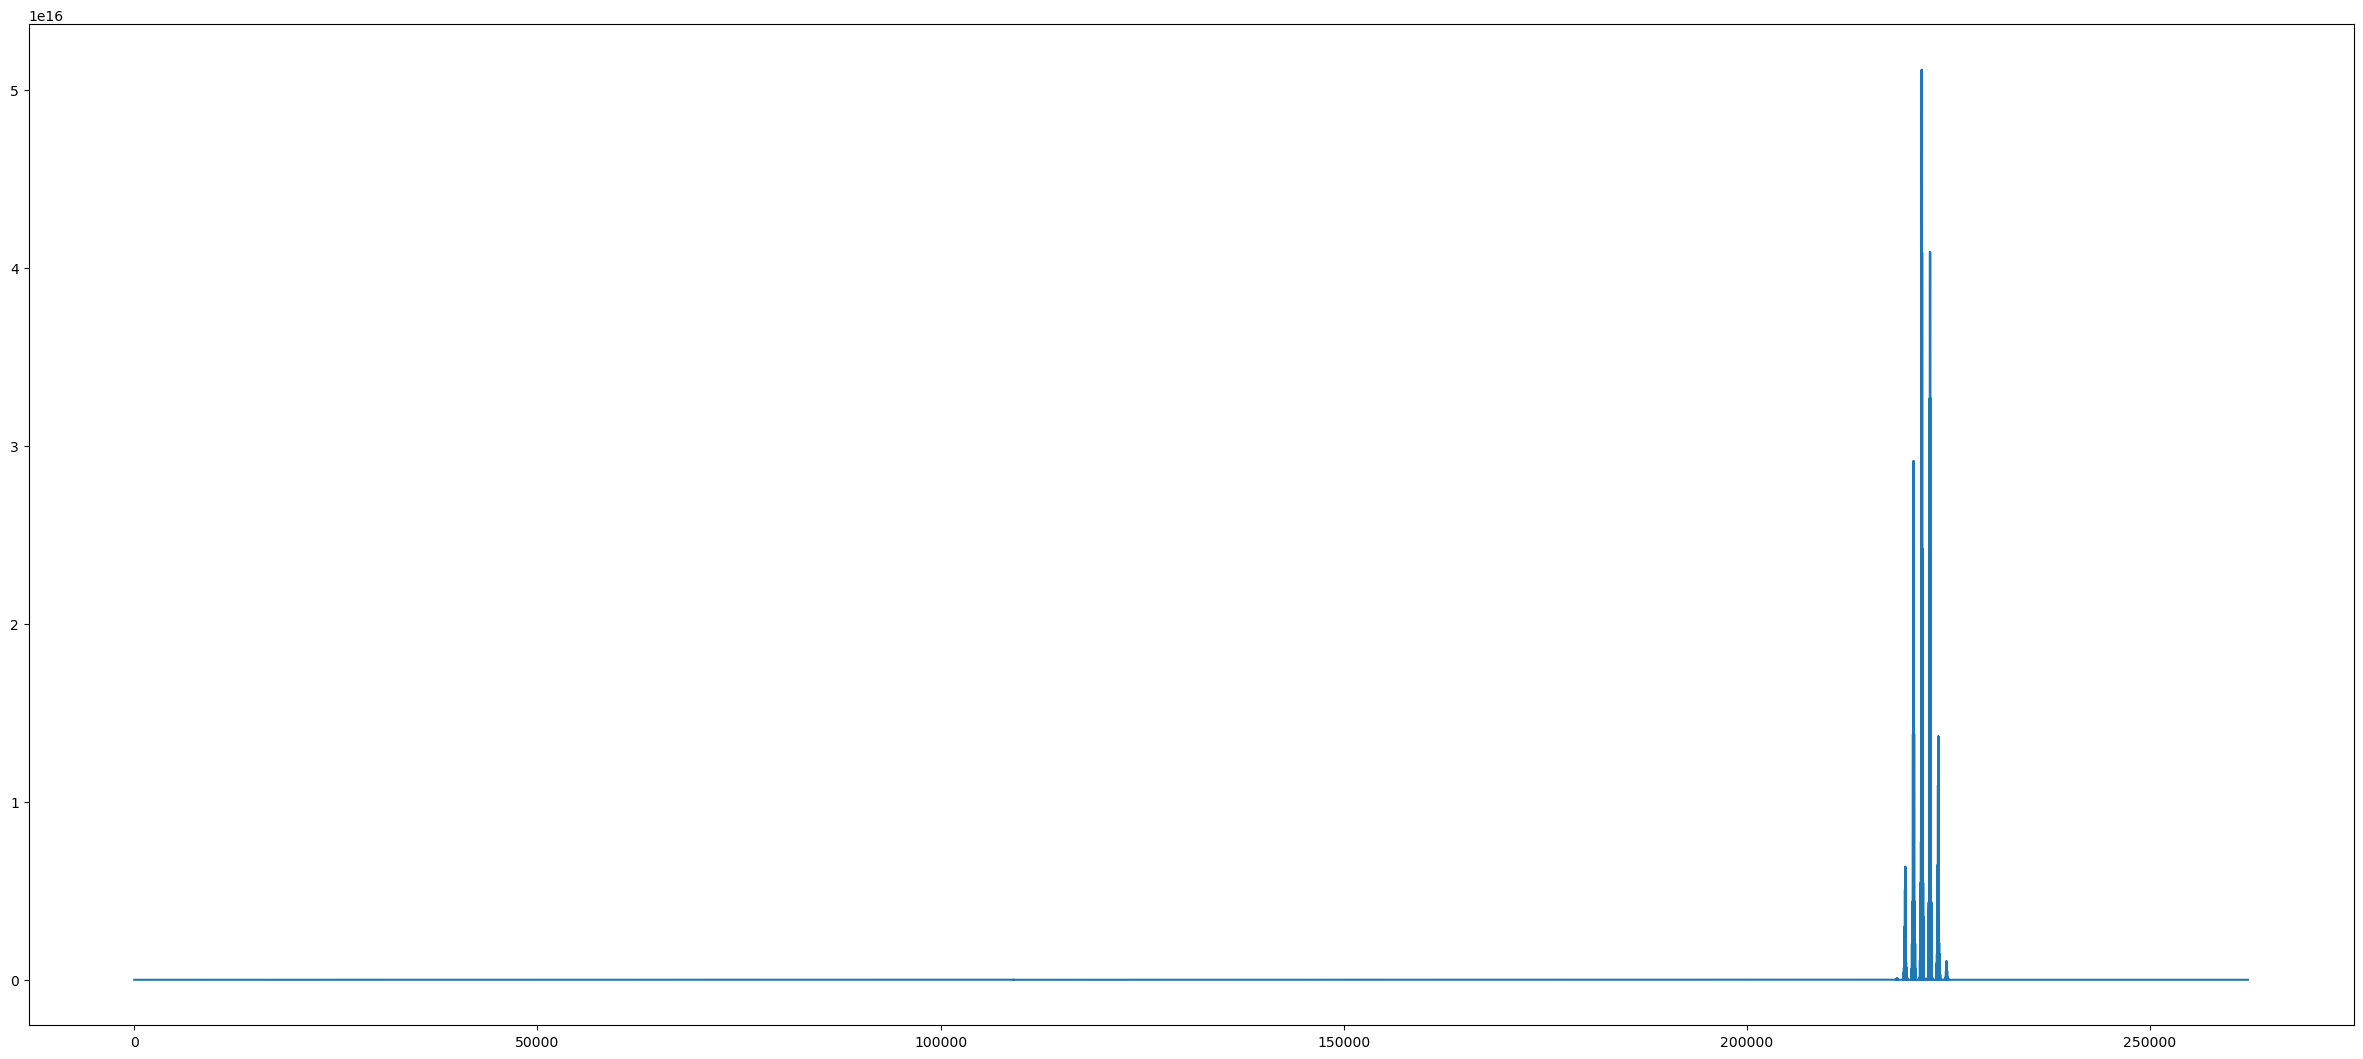

Index: 31



KeyboardInterrupt



In [6]:
###################################################################################################
# Program for storing max and min values of various data types for the dynamic res neural network #
###################################################################################################
import numpy as np
from openpmd_viewer import OpenPMDTimeSeries

num_timesteps = 260 # give number of frames you want to render in gif
file_index = 0  # stores position in file list later
starting_point = 0

file_names = []  # List to store filenames for deletion

J_max = 0
all_J_maxs = []

B_max = 0
all_B_maxs = []

ts_3d = OpenPMDTimeSeries('Physics_Sim_Outputs_PMD/diag1', check_all_files=False)

for i in range(num_timesteps):  # Keep looping for all frames desired in animation
    file_names.append(f'Physics_Sim_Outputs_PMD/diag1/openpmd_{format(i, '06')}.bp')  # Grab all respective output files that coorespond to number of frames & add them to file_names list

for file_index in range(starting_point, len(file_names)):  # move through the file_names list
    print(f'Index: {file_index}')
    # Read the file
    # ts_3d = OpenPMDTimeSeries('Physics_Sim_Outputs_PMD/diag1', check_all_files=False)
    it = ts_3d.iterations
    time_PMD = ts_3d.t
    
    # Create field 3D numpy arrays for electric field and current density. 
    Jx_3d, info_Ez_3d = ts_3d.get_field(field='j', coord='x', iteration=file_index, slice_across=None)
    Jy_3d, info_Ez_3d = ts_3d.get_field(field='j', coord='y', iteration=file_index, slice_across=None)
    Jz_3d, info_Ez_3d = ts_3d.get_field(field='j', coord='z', iteration=file_index, slice_across=None)    
    
    Bx_3d, info_Ez_3d = ts_3d.get_field(field='B', coord='x', iteration=file_index, slice_across=None)
    By_3d, info_Ez_3d = ts_3d.get_field(field='B', coord='y', iteration=file_index, slice_across=None)
    Bz_3d, info_Ez_3d = ts_3d.get_field(field='B', coord='z', iteration=file_index, slice_across=None)
    
    # Flatten all the 3D numpy arrays into 1D numpy arrays
    Jx_3d_flat = Jx_3d.flatten()
    Jy_3d_flat = Jy_3d.flatten()
    Jz_3d_flat = Jz_3d.flatten()
    
    Bx_3d_flat = Bx_3d.flatten()
    By_3d_flat = By_3d.flatten()
    Bz_3d_flat = Bz_3d.flatten()
    
#     print(f'J MAX 3D: {np.max(Jy_3d)}')
#     print(f'B MAX 3D: {np.max(By_3d)}')
    
#     print(f'J MAX FLAT: {np.max(Jy_3d_flat)}')
#     print(f'B MAX FLAT: {np.max(By_3d_flat)}')
#     print(len(np.nonzero(Jx_3d_flat)))
#     print(len(np.nonzero(Bx_3d_flat)))
    
#     magnitude = np.sqrt(Jx_3d_flat**2 + Jy_3d_flat**2 + Jz_3d_flat**2)  # freaky function
    
#     fig = plt.figure(figsize=(30, 13))
#     plt.plot([i for i in range(len(Jx_3d_flat))], magnitude)
#     plt.hist(data[0].get("d").get('fEx')[::10], bins=200)
#     plt.show()
    
    J_maxs_for_loop = []
    
    for i in range(len(Jx_3d_flat)):
        numbers = [Jx_3d_flat[i], Jy_3d_flat[i], Jz_3d_flat[i]]
        J_max_each_i = max(numbers)
        J_maxs_for_loop.append(J_max_each_i)
        
    all_J_maxs.append(max(J_maxs_for_loop))
    
    B_maxs_for_loop = []
        
    for i in range(len(Bx_3d_flat)):
        numbers = [Bx_3d_flat[i], By_3d_flat[i], Bz_3d_flat[i]]
        B_max_each_i = max(numbers)
        B_maxs_for_loop.append(B_max_each_i)
        
    all_B_maxs.append(max(B_maxs_for_loop))
    

J_max = max(all_J_maxs)
B_max = max(all_B_maxs)

np.save(f'Training_data/Current_density_max/J_max_max_all_128.npy', J_max)
np.save(f'Training_data/Magnetic_field_max/Bxyz_max.npy', B_max)

In [11]:
import numpy as np
Bx = np.load('Training_data/Magnetic_field_data/Bx/Bx_3D_vol_32_32_256_118.npy')
print(len(Bx))
print(len(np.nonzero(Bx)))
print(np.max(Bx))

262144
1
4330.291765559821


In [2]:
import numpy as np
np.save(f'Training_data/Current_density_max/J_max_max_all_128.npy', 1)
np.save(f'Training_data/Magnetic_field_max/Bxyz_max.npy', 1)